In [2]:
import ROOT as rt
import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list
import math
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/00
3.6.8 (default, Apr 25 2019, 21:02:35) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [3]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
bkg_path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/RunIIFall17DRPremix_QCD_upperbound/"
sig_path = "/mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/signal/bbbb/vh/"

# bkg_path = "/nfshome/christiw/llp/jet_timing_studies_root/gammaMax_p/"

lumi = 137000 #in pb-1

# fpath_bkg['QCD15'] = bkg_path+"ntuple_RunIIFall17_QCD_Pt_15to30_TuneCP5_13TeV_pythia8.root"
fpath_bkg['QCD30'] = bkg_path+"ntuple_RunIIFall17_QCD_Pt_30to50_TuneCP5_13TeV_pythia8.root"
# fpath_bkg['QCD170'] = bkg_path+"jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8.root"
fpath_bkg['bbbb_mh125_ctau1'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl10000.root'
# fpath_bkg['bbbb_mh2000_ctau1'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh2000_mx975_pl1000.root'
# fpath_bkg['bbbb_mh125_ctau10'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl10000.root'
# fpath_bkg['bbbb_mh2000_ctau10'] = sig_path+'ntuple_RunIISummer16_bbbb_vh_mh2000_mx975_pl10000.root'

# process['glueBall'] = 'pp #rightarrow  #rightarrow bbbb'

start_t = time.time()

for k,v in fpath_bkg.items():
    print (k, v)

    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['ntuples']['llp']
    a = tree_bkg[k]["jetPt"].array()
    a = tree_bkg[k].get("jetPt")
    print (len(a))
print("time: "+str(time.time()-start_t))

QCD30 /mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/RunIIFall17DRPremix_QCD_upperbound/ntuple_RunIIFall17_QCD_Pt_30to50_TuneCP5_13TeV_pythia8.root
63826
bbbb_mh125_ctau1 /mnt/hadoop/store/group/phys_exotica/delayedjets/jet_timing_studies/christiw/signal/bbbb/vh/ntuple_RunIISummer16_bbbb_vh_mh125_mx50_pl10000.root
82611
time: 2.8766672611236572


In [4]:
legend = {}
legend['bbbb_mh125_ctau1'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 1 m'
legend['bbbb_mh2000_ctau1'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 1 m'
legend['bbbb_mh125_ctau10'] = 'Signal (m_{h} ,m_{x})=(125, 50) GeV, c#tau = 10 m'
legend['bbbb_mh2000_ctau10'] = 'Signal (m_{h} ,m_{x})=(2000, 975) GeV, c#tau = 10 m'
legend['QCD15'] = 'QCD Pt 15-30 GeV'
legend['QCD30'] = 'QCD Pt 30-50 GeV'



wH = 1


trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])
if wH:
    trigger_paths = [87,135] #PFMET120
else:
    trigger_paths = [177,362,87,135] #PFMET120

# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET


In [19]:
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5
def ptD(pt_list):
    pt_list = np.array(pt_list)
    return np.sum(pt_list*pt_list)**0.5/np.sum(pt_list)
def moment_diag(pt,pos):#list of pt, pos is list of eta or phi
    mean_pos = np.sum(pt*pt*pos)/np.sum(pt*pt)
    return np.sum(pt*pt*(pos-mean_pos)*(pos-mean_pos))
def moment_xterm(pt,eta,phi):#list of pt, pos is list of eta or phi
    mean_eta = np.sum(pt*pt*eta)/np.sum(pt*pt)
    mean_phi = np.sum(pt*pt*phi)/np.sum(pt*pt)
    return -np.sum(pt*pt*(phi-mean_phi)*(eta-mean_eta))
def sig(pt,eta,phi):
    pt = np.array(pt)
    eta = np.array(eta)
    phi = np.array(phi)
    m11 = moment_diag(pt,eta)
    m22 = moment_diag(pt,phi)
    m12 = moment_xterm(pt,eta,phi)
    a = (m11+m22)/2
    b = 0.5*((m11+m22)**2-4*(m11*m22-m12**2))**0.5
    #returns sig1,sig2
    return ((a+b)/np.sum(pt*pt))**0.5, ((a-b)/np.sum(pt*pt))**0.5
def sig_mag(pt,eta,phi):
    matrix = np.ones((2,2))
    matrix[0][0] = moment_diag(pt,eta)
    matrix[1][1] = moment_diag(pt,phi)
    matrix[0][1] = moment_xterm(pt,eta,phi)
    matrix[1][0] = moment_xterm(pt,eta,phi)
    u, s, vh = np.linalg.svd(matrix, full_matrices=True)
    return s[0],s[1]
def sig_dir(pt,eta,phi):
    matrix = np.ones((2,2))
    matrix[0,0] = moment_diag(pt,eta)
    matrix[1,1] = moment_diag(pt,phi)
    matrix[0,1] = moment_xterm(pt,eta,phi)
    matrix[1,0] = moment_xterm(pt,eta,phi)
    u, s, vh = np.linalg.svd(matrix, full_matrices=True)
    print(u,s,vh)
    return(u[0,0])

In [20]:
met_cut = 30 #GeV
jetTime_cut = 1 #ns
lepid = 13 #muon


sig_et1 = {}
sig_et2 = {}
sig_et = {}
start_t = time.time()

for k in tree_bkg.keys():
    if True:
        sig_et1[k] = []
        sig_et2[k] = []
        sig_et[k] = []
        
        T = tree_bkg[k]
#         eventNum[k] = T.array('eventNum')

        jet_n_rechits_temp =T.array('jet_n_rechits_Ecut0p5')
        jetEta_temp =T.array('jetEta')
        jetEcalEnergy_temp =T.array('jet_rechit_E_Ecut0p5')
        jetTime_temp =T.array('jet_rechit_T_Ecut0p5')

        jet_rechits_T_temp = T.array('jet_rechits_T')
        jet_rechits_E_temp = T.array('jet_rechits_E')
        jet_rechits_eta_temp = T.array('jet_rechits_eta')
        jet_rechits_phi_temp = T.array('jet_rechits_phi')
        
        genTime_temp = T.array('gen_time')
        gLLP_decay_radius_temp =  ((T.array('gLLP_decay_vertex_x')-T.array('gLLP_prod_vertex_x'))**2+(T.array('gLLP_decay_vertex_y')-T.array('gLLP_prod_vertex_y'))**2)**0.5
        gLLP_daughter_match_jet_index = T.array('gLLP_daughter_match_jet_index')
        nJets = T.array('nJets')
        for ev in range(len(nJets)):
            for j in range(nJets[ev]):
                if jet_n_rechits_temp[ev][j]<5:continue
                if abs(jetEta_temp[ev][j]) > 1.48: continue
#                 print(j,gLLP_daughter_match_jet_index[ev])
                if not k[:3]=='QCD' and j not in  gLLP_daughter_match_jet_index[ev]: continue
#                 print("here")

                if not k[:3] == 'QCD':
                    genTime[k].append(genTime_temp[ev][list(gLLP_daughter_match_jet_index[ev]).index(j)])
                    llp_id = 666
                    if list(gLLP_daughter_match_jet_index[ev]).index(j)<=1:
                        llp_id = 0
                    else:
                        llp_id = 1
                    gLLP_decay_radius[k].append(gLLP_decay_radius_temp[ev][llp_id])
                    
                rechits_et = jet_rechits_E_temp[ev][j]/np.cosh(jet_rechits_eta_temp[ev][j])
                sig1,sig2 = sig(rechits_et,jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j])
                print(sig(rechits_et,jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j]))
                print(sig_mag(rechits_et,jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j]))
                sig_et1[k].append(sig1)
                sig_et2[k].append(sig2)
    
              
        sig_et1[k] = np.array(sig_et1[k])
        sig_et2[k] = np.array(sig_et2[k])
        sig_et[k] = np.hypot(sig_et1[k],sig_et2[k])
      
        
        print(k,(time.time()-start_t))
        start_t = time.time()
    else:
        print(k)

(0.0021251145021471385, 0.0009475684740404641)
(0.0012225603857211995, 0.0002430674784254088)
(0.14961626389300192, 0.02943484177837069)
(0.5129146681703253, 0.019852304097788077)
(0.1287707912747795, 0.005808439104454684)
(0.10317236019146162, 0.00020991695505387668)
(0.10595635914597282, 0.0629795715264506)
(0.1622312481582437, 0.05731652596871363)
(0.0235393758614205, 0.005213413994368296)
(0.03556329664235709, 0.0017444420712233956)
(0.14837572966232535, 0.05944761941276892)
(0.3160573301301553, 0.0507351638884024)
(0.13429772050530936, 0.050058676895360706)
(0.32487291478721214, 0.04513723540135658)
(0.05498409882075792, 0.031124568540816702)
(0.15459208755814569, 0.049535861285338226)
(0.04737722513886694, 0.009044058457456558)
(0.06769680951760458, 0.0024669234964686823)
(0.056809644268392384, 0.016160536981129008)
(0.09162586271752775, 0.007414562186211452)
(0.029992277118547933, 0.0132164360443946)
(0.015285666028161426, 0.002968207127911772)
(0.16895579191906124, 0.1006416873

(0.06366808896186309, 0.013815803867669885)
(0.10012749766903091, 0.004714786727656159)
(0.15486167551933067, 0.09793025458035226)
(0.2795691018732818, 0.11179825648711095)
(0.020477329199625315, 0.005024969368264989)
(0.021181482220738207, 0.0012754885388560147)
(0.08143458444700749, 0.016837837288295424)
(0.07318200852051832, 0.003128665783006008)
(0.050636470454755146, 0.016463219077074487)
(0.04582617155844834, 0.004844135013714262)
(0.07892662741583663, 0.055906892222338474)
(0.045824760119572094, 0.02299237380500151)
(0.03775127484407785, 0.017812215959423682)
(0.08353474622968068, 0.01859686837639693)
(0.08903284129841971, 0.011420359911091173)
(0.03891679007111103, 0.0006403186140875579)
(0.06767965080594607, 0.011368726684584095)
(0.27471814617499085, 0.007751661150324437)
(0.20164277103350386, 0.07901298174776296)
(0.5991959571728153, 0.0920026767483541)
(0.09760969058980246, 0.03658971214865167)
(0.2922537598227425, 0.04106692836105544)
(0.18950009356523154, 0.05954485015995

(0.026048554950531648, 0.0040372827290568215)
(0.1452497325259165, 0.0034892042895664902)
(0.024804404040029232, 0.017728184876837336)
(0.02667722527381595, 0.013627356151420592)
(0.046263511501448466, 0.03324328896430737)
(0.05391321347292477, 0.027837228909110216)
(0.02177108337763468, 0.008652808598451666)
(0.0244555866195392, 0.0038630666130488284)
(2.909686336873188, 0.12757253941968819)
(48.778665106673905, 0.09376741916424204)
(0.09232223660417317, 0.04085807684995449)
(0.0404883043617726, 0.007929992865181316)
(0.06958672831949907, 0.030334628568522197)
(0.01465783887320258, 0.002785444246997122)
(0.1534711614442757, 0.017851002272601047)
(0.07485406992862567, 0.0010127145962977942)
(0.05343473330795375, 0.03628879478592809)
(0.031390777564387566, 0.014477709919191634)
(0.12349093531078048, 0.08655793092733557)
(0.06275754847605906, 0.0308325570263527)
(0.023227605494070387, 0.012548028494470974)
(0.004809124615137305, 0.0014034861808869855)
(0.06459326418710537, 0.012936695975

(0.10877438520057528, 0.01764656309884943)
(0.2403190454018401, 0.040211059878622175)
(0.05895389191734859, 0.001650544132797042)
(0.061230336266940105, 0.02057657527672944)
(0.07623063585306847, 0.008608796463587457)
(0.0651604939821857, 0.0045114420603912095)
(0.09529687682859204, 0.0004568153618340413)
(0.044365001859773295, 0.035480622576023926)
(0.06499094412923402, 0.04156753790151944)
(0.08869293881551198, 0.028890193723882268)
(0.17769859173052602, 0.01885414328925916)
(0.057259133710959274, 0.0375218487479813)
(0.04117647550943606, 0.017681865434776057)
(0.10610716239371983, 0.05035270715414229)
(0.11025806448840161, 0.02482942219950454)
(0.22395463283812317, 0.0778186131656375)
(0.21416168127751084, 0.02585762539437794)
(0.07303855095058927, 0.0063751893467090025)
(0.1078472943080005, 0.000821658085475292)
(0.1182653478746166, 0.07181077238503122)
(0.09760732497198486, 0.035987077517882014)
(0.11952931079157163, 0.07481513982914775)
(0.0995966570636459, 0.0390188903925945)
(0

(0.2503275808447871, 0.028468430680170957)
(0.03335964935234512, 0.016935459001661636)
(0.04482196416684231, 0.011551592858588516)
(0.03210883660566506, 0.011160288920392659)
(0.017620587214479434, 0.002128737510222372)
(0.06647890460660404, 0.0298751003803131)
(0.2878127756910524, 0.058124750887785875)
(0.14371304469971521, 0.07265286074970369)
(0.32250338190067135, 0.08242279383854985)
(0.1827463957579438, 0.006469366043367711)
(0.16980295476000437, 0.00021279971988509433)
(0.16511279575520538, 0.03858984199930412)
(0.40714693364488763, 0.022240047319354996)
(0.012015188150781987, 0.0028592397265144683)
(0.0025238885153564426, 0.00014292564280201368)
(0.07925112582999742, 0.01810564131163598)
(0.07943269072134511, 0.004145875135906036)
(0.013953299492439812, 0.0030661766291871554)
(0.0031573270782141176, 0.00015246146213166302)
(0.1390760500089373, 0.04598203935678741)
(0.26448852582551796, 0.028912030851502214)
(0.012839072781250314, 0.011193090151796755)
(0.004604213605217445, 0.00

(0.06271697868365894, 0.003790546160222183)
(0.005341191025504604, 1.951063628588774e-05)
(0.044501505623268, 0.019207067180538124)
(0.004852333457955264, 0.0009039061468748302)
(0.06606386852698518, 0.00830133080266913)
(0.1735880827668209, 0.00274086310697484)
(0.07254544835523292, 0.010702071764820274)
(0.06444385582112727, 0.001402480710854689)
(0.10972607346756645, 0.03546715781254939)
(0.0659784137233114, 0.006893423620604668)
(0.03131847431753395, 0.01834279035651151)
(0.012436050234090838, 0.004265913825573218)
(0.10933691040779539, 0.0320145490730149)
(0.16930357074722385, 0.014515342936055407)
(0.12910027293951892, 0.03685044240002646)
(0.04035441511674473, 0.003287926862425714)
(0.04802707394649793, 0.017841197938868115)
(0.23076163292803617, 0.031844861946539516)
(0.06965957985436286, 0.017257044726083193)
(0.05437480785324203, 0.003337097404666275)
(0.13382039322008848, 0.07722666094818398)
(0.15465656683552526, 0.05150605379632351)
(0.06934380949846047, 0.0178996930580911

(0.12546255066120124, 0.005742284955895307)
(0.22173836988859158, 0.0004644961362312452)
(0.09270984952120782, 0.023178509808612156)
(0.09641314864459997, 0.006026366436534622)
(0.13653960401133938, 0.03414477467388453)
(0.19248162724477125, 0.012037062229556502)
(0.0921950531863339, 0.02368190633215203)
(0.11877763839745822, 0.007837052675820357)
(0.0416433930359987, 0.02974393628675541)
(0.025389381372650323, 0.012952595041601612)
(1.7347333733590145, 0.02481335755168834)
(54.961644976229216, 0.011245151799182864)
(0.024537785544154176, 0.008923678100281544)
(0.08519671588012107, 0.011267820313597963)
(0.13191873333423673, 0.05117951442822144)
(0.1279831837967877, 0.019263370906248266)
(0.008781771904379355, 0.006259959064847077)
(0.012264733757576118, 0.006232134337393427)
(0.06820392077766871, 0.02988450478691516)
(0.09009064433474225, 0.0172962971423541)
(0.047529740752897155, 0.03315311017613803)
(0.02580831226509237, 0.012556750576122046)
(0.18714885671121187, 0.0044943376067364

(0.07625038983160423, 0.0015972047880169653)
(0.026779442734857672, 0.010905067468739735)
(0.03045791108529208, 0.005050725403673164)
(0.24603178475469048, 0.03328735236601667)
(1.230394478456384, 0.022522699681104295)
(0.13689652245493028, 0.09020373834313589)
(0.06710752724723922, 0.029136372272310973)
(0.15149254127184855, 0.017732597947765116)
(0.12320178150314316, 0.0016880263466350846)
(0.11076658813839035, 0.06416052021274847)
(0.21529709459652097, 0.07223644502521867)
(0.050425357924844885, 0.038347548679345714)
(0.02426818644416596, 0.014035069208585733)
(0.0593812673321368, 0.04383822030314665)
(0.14422775860808576, 0.07860601132342207)
(0.125387552458382, 0.008802646482270386)
(0.14203396750572483, 0.0007000191000049632)
(0.04247276872904638, 0.02415469507145372)
(0.03236687316894749, 0.010468458096636027)
(0.20305584685539269, 0.09293379259184144)
(0.17772161792541094, 0.037226875053060396)
(0.09011095576146773, 0.05562191093952639)
(0.04106476510058954, 0.01564609495078589

(0.13419061454179362, 0.024386377388104726)
(0.02520928978295987, 0.011356252760231115)
(0.060774967104243495, 0.012333138589848304)
(0.20926129849978195, 0.03828041291973244)
(0.46271934558931926, 0.015484352620958012)
(0.11323141968850052, 0.022651902981181863)
(0.11555977993727941, 0.004624685316869814)
(0.042638544380005534, 0.015388301328897559)
(0.02215652993293367, 0.002885880659550857)
(0.09177503811590938, 0.017615101697731433)
(0.4297816718764957, 0.015833212975412497)
(0.024512830874958227, 0.01116659390453489)
(0.0713302754356399, 0.014802272949990307)
(0.03819495140807901, 0.0070983024604018286)
(0.10197595276361741, 0.003522044586605266)
(0.03881328781235236, 0.01799067750077749)
(0.06122886026704819, 0.013154984691476449)
(0.16267079100070375, 0.008502145136348135)
(0.052985189584022936, 0.00014474126514304266)
(0.1725093754781077, 0.029146652931267447)
(0.8309121633581859, 0.02371958518643604)
(0.03535457484661816, 0.026027451481512493)
(0.014002039265491822, 0.00758862

(0.09672624757447068, 0.05509423851604468)
(0.05763859188919474, 0.03237539991324448)
(0.016179736414388732, 0.0051047561458195155)
(0.11833933600566345, 0.037227114522983204)
(0.23271900426608563, 0.023029915493981)
(0.1731520397931451, 0.06399313090908895)
(0.2385398763345896, 0.032581605683126666)
(0.13526988049914432, 0.05721371150767634)
(0.10857912946853122, 0.01942425568873535)
(0.1764200302151071, 0.03507695892183107)
(0.15847984354927905, 0.006265015039416161)
(0.04564773403629389, 0.012560330877741836)
(0.31026348134618414, 0.023490614282465416)
(0.1179935854722805, 0.06096292246397328)
(0.12717874596853013, 0.03394918073367102)
(0.08235044832108412, 0.04304344838951982)
(0.12984539801568076, 0.035473883927745364)
(0.10635286975454732, 0.07398235598060089)
(0.0895708048707666, 0.043343538671690066)
(0.06331595814431207, 0.009259861546614793)
(0.013011092720975455, 0.0002782892250800661)
(0.08910639549264292, 0.024799077054007038)
(0.22968848975660197, 0.017790678688214073)
(0

(0.11232430568049363, 0.08096757041547167)
(0.19065173303981642, 0.0152509777353805)
(0.2453954065946923, 0.0015702915312286439)
(0.033532799619296304, 0.016519600354900583)
(0.09248642499055287, 0.022445921412683506)
(0.034287841903293495, 0.004524782977250301)
(0.0519319815917682, 0.0009043782306362106)
(0.17026697242055733, 0.09945541550219093)
(0.17127473166237772, 0.05843719217325127)
(0.1591513793372027, 0.08330941548856897)
(0.20486407758437716, 0.05613492846650282)
(0.045610526476341805, 0.02066030749154164)
(0.08390112652249646, 0.017215164752640077)
(0.05793659770100638, 0.033457819293538825)
(0.14637914887729744, 0.04881670971273641)
(0.07455550946788944, 0.03631937456832472)
(0.17630899615526377, 0.04184000334907451)
(0.11114514820587645, 0.07729412736575486)
(0.07063493587424671, 0.03416107536927015)
(0.17636402616566665, 0.0441420887299715)
(0.33770938388064714, 0.021155772003774255)
(0.10196136263583037, 0.03812630373547236)
(0.44801376160635886, 0.06264256026372472)
(0.

(0.03538664520182997, 0.009783279716907282)
(0.006625171496323928, 0.0005063925209266135)
(0.07626102406767864, 0.026724030665742856)
(0.030417155623450053, 0.0037352292073462626)
(0.0353728115887525, 0.02696881871968939)
(0.0058508644702962055, 0.003400985063315829)
(0.13426545392889214, 0.018450407455787236)
(0.11038683296743006, 0.0020844938950707937)
(0.049801617654073704, 0.016612479225835773)
(0.24631725899038984, 0.027407968430066352)
(0.05316965249480476, 0.027801931135589368)
(0.24007893702079033, 0.06564117437368452)
(0.11601216771829899, 0.05152365767613723)
(0.031827051951064965, 0.0062777309912515865)
(0.08521607803530344, 0.009665985255721763)
(0.031482615576369485, 0.000405060578054196)
(0.06638158654476342, 0.00503148072773137)
(0.11136232023033303, 0.0006397858666263556)
(0.06927652402375496, 0.042294767761665936)
(0.07755515982402127, 0.028907584850227357)
(0.16101228402557244, 0.019998371169042444)
(0.0737072958561142, 0.0011370556121946527)
(0.1307981137509018, 0.10

(0.14714105606776778, 0.002030321348984807)
(0.07308824466492347, 0.04499815637858695)
(0.29454516203524744, 0.111646797866999)
(0.142397672996941, 0.029325535478647365)
(0.7990192553370412, 0.033887799021689896)
(0.06177656255025244, 0.010099484448512575)
(0.010614949484290096, 0.0002837062237524384)
(0.19429697647733474, 0.10709383294507732)
(0.6660630189366747, 0.20235417141181997)
(0.12753624965008833, 0.014975962642605338)
(1.0515303556899838, 0.014499199540798624)
(0.16098500217492906, 0.1127283340497144)
(0.44136164455634624, 0.2164162818166777)
(0.03866248731211443, 0.007881630232481373)
(0.2134338774449649, 0.008869842033030626)
(0.03238185232533504, 0.0095437455035655)
(0.033115340831814444, 0.0028764945337982737)
(0.0477318597656555, 0.005899364364550137)
(0.0934523622082187, 0.0014275259525869633)
(0.09053872025064683, 0.04727320540010096)
(0.0757997159841761, 0.020664693935593538)
(0.16003700905412466, 0.023148166773280868)
(0.11620640307953277, 0.0024312096537287106)
(0.0

(0.1263466134683295, 0.005814246594565637)
(0.030996934932212748, 6.564149057961039e-05)
(0.11787255666740896, 0.028331018544529803)
(0.2601365127833163, 0.015027968766556217)
(0.10596887919499562, 0.046053465933951605)
(0.10383087107083691, 0.019610761419230342)
(0.08688184531630419, 0.04492903789505639)
(0.1391118241279012, 0.03720147931868985)
(0.1555568125899787, 0.06634384780036066)
(0.2088960028603491, 0.03799735537503149)
(0.07394440415215563, 0.01241877724060227)
(0.0545570116478122, 0.0015388547187507105)
(0.038965574484657366, 0.021696720916974832)
(0.04422389924664999, 0.013711440082887924)
(0.05780325240281041, 0.003181579688287657)
(0.028787955491474976, 8.72151400274176e-05)
(0.08803000800275688, 0.025963024726311925)
(0.1772237013109911, 0.015415971322967612)
(0.16669303928898277, 0.02216825236834414)
(0.8574149410546522, 0.015164183487313099)
(0.06045122966051738, 0.039594675773874585)
(0.06169085303004516, 0.026465742257631437)
(0.03338217008416524, 0.02273351417331262

(0.04297137209658999, 0.032638750085913666)
(0.145039542824184, 0.08367486449461296)
(0.06870431709168091, 0.057059860124393895)
(0.4294659916775592, 0.2962252876849836)
(0.08911063812760242, 0.02611803673713951)
(0.2506060326265073, 0.02152848509152893)
(0.05227214288665734, 0.019052310942369186)
(0.08079773205542325, 0.010733809505991315)
(0.012670392596294907, 0.0038448521233405667)
(0.002978362289790537, 0.0002742563317661396)
(0.04784487854658801, 0.006534259374505657)
(0.006104117841010323, 0.00011385306731333639)
(0.12670922466598356, 0.06921191318584775)
(0.12425439360853588, 0.03707293724331251)
(0.11015485842173865, 0.041138693001712336)
(0.089533878243301, 0.012487659925067769)
(0.10080864486054879, 0.021137275527896383)
(0.2997035905158348, 0.013176328375293658)
(0.11037566283557979, 0.06919275427653002)
(0.19866480923344357, 0.07807204082426353)
(1.0101698221753188, 0.007020116435687919)
(40.03276854625888, 0.0019333722283698975)
(0.07072434875533795, 0.03563726420955577)


(0.07557163305799994, 0.01772826685153032)
(0.09633270330945867, 0.005301377052494373)
(0.025283045428253107, 0.009865838668849778)
(0.037358727818037035, 0.005688546696313149)
(0.04472923580535563, 0.03231048001989291)
(0.03746728888134817, 0.019550421831902698)
(0.22355336439291987, 0.168632265904933)
(0.12894973454353614, 0.07337352489972924)
(0.13342581616321023, 0.050149797563280855)
(0.36356423546821365, 0.05136174693203777)
(0.06311017581642211, 0.011330698088656723)
(0.03497078361396811, 0.0011272491572638075)
(0.13189565876359124, 0.05673258072144214)
(0.6459732966950086, 0.11951396154556569)
(0.04631710349565507, 0.024817245130455228)
(0.1199660063311436, 0.03444153964736158)
(0.13434557000904132, 0.008513533573392181)
(0.08878822230955703, 0.00035655650669746253)
(0.0879610952969265, 0.06871294106432826)
(0.09262530263465882, 0.056523033043617)
(0.13138067040685283, 0.05196134158997919)
(0.1409798189940705, 0.022052341664492697)
(0.10553329671725788, 0.03593021953046784)
(0.

(0.1821897314770513, 0.006151515607964043)
(0.032531983956592916, 0.0018474140522154307)
(0.03575421164097555, 0.00011530140332641304)
(0.1328580432060034, 0.005789463280845229)
(0.06123211632742002, 0.00011627334703670724)
(0.024502662519437803, 0.00918901007862025)
(0.1457673768314425, 0.020500820228970647)
(0.12789458727546596, 0.014164467399171269)
(0.06091500482756114, 0.0007471717648099959)
(0.07661719390462687, 0.014387869529633382)
(0.041257252581159615, 0.0014549256547582163)
(0.05646819327856172, 0.01500472812353042)
(0.03563458482342618, 0.002516055284550458)
(0.037336900286917295, 0.025391296629878855)
(0.07561962016386184, 0.034972584636189935)
(0.11803054199305454, 0.06872920656988642)
(0.06963333861352652, 0.02361082031042074)
(0.03266556645056284, 0.010174135648179733)
(0.004078604967661127, 0.0003956637873609218)
(0.23653295616792164, 0.008154515848067137)
(0.35266974277892943, 0.0004191613631763428)
(2.25078997010014, 0.005382260567468881)
(47.64994423213441, 0.000272

(0.0501880419908805, 0.02108809920894194)
(0.07271638497844107, 0.012838274196278551)
(0.0411869561184464, 0.01134574307247555)
(0.1185856787914415, 0.008998678565795863)
(0.12361141066859609, 0.0541433208812068)
(0.3485783979415199, 0.06687643648323928)
(1.564489131167732, 0.06307860899363023)
(36.437527592399604, 0.059233584647784054)
(0.08304658954194408, 0.042606296432598646)
(0.27344814161745845, 0.07197454719854991)
(0.070794024513423, 0.01342216407357004)
(0.014110041049209451, 0.0005072010689271135)
(0.041455732825356605, 0.014344779066260051)
(0.014593689179473797, 0.0017473649756356855)
(0.1563759993592466, 0.07568420190966267)
(0.3471566365132444, 0.08131969609255728)
(0.018705505044961022, 0.009713111659925774)
(0.003593333623873131, 0.0009688921266366456)
(0.00791798193436354, 0.003926711676861221)
(0.001910063971747719, 0.00046976096664957126)
(0.008395931335332023, 0.0021921894315689023)
(0.00568109069341219, 0.00038730234419617776)
(0.16965971205607955, 0.00118663643605

(0.06496521180975069, 0.0029117737399258267)
(0.12266340590518122, 0.00024641580041657605)
(0.09497151905515695, 0.07532984009753853)
(0.14824995978533742, 0.09326998486197104)
(0.04006861437919454, 0.029723438074652622)
(0.07954498508503882, 0.043772589647959596)
(0.20864375815134484, 0.013323080420368607)
(0.2289147681510608, 0.0009334097150787589)
(2.9040662481959254, 0.03031549587743859)
(63.98892826130469, 0.006973023848680398)
(0.0600424557316499, 0.004237006668040225)
(0.03426832640584709, 0.00017064528646452775)
(0.15865846968513153, 0.04581338946678831)
(0.24101250329407484, 0.02009545756101259)
(0.10825694000804868, 0.02241452675728578)
(0.13227124966806167, 0.005670392353926158)
(0.06382178963047228, 0.016444429102003794)
(0.01988355929758437, 0.0013200603121769979)
(0.02491706276523351, 0.008773525436867354)
(0.1116731874723781, 0.013845335980471142)
(0.16073784986807071, 0.010903770028850544)
(0.2367488331958271, 0.001089443982658696)
(0.05877285263743059, 0.01282493085071

(0.10708073175054814, 0.02141853547082228)
(0.4117125715237952, 0.016472177418948027)
(0.020870795051821402, 0.007095715615203679)
(0.08497804949161572, 0.009822480479440164)
(0.12435118872613533, 0.021843372088112687)
(0.09168277193319595, 0.002828962693694216)
(0.09630017766971115, 0.022978980280222182)
(0.09505289251606418, 0.0054121853997443955)
(0.07880982596405531, 0.03669586674165469)
(0.11519809206972241, 0.024975767876028555)
(0.06986823037565962, 0.05504055230805999)
(0.07842982095815816, 0.04867290896227626)
(0.08389071421198437, 0.03279867928318219)
(0.15185809842975875, 0.023212551806195574)
(0.021877319425923202, 0.005326028893673782)
(0.009889867227838309, 0.0005861506915841913)
(0.045361053226671846, 0.012118873107923043)
(0.06932869280461801, 0.004948473266884707)
(0.0832677797441773, 0.027995394246952198)
(0.2776511114326214, 0.031384746307344155)
(0.27743649398865045, 0.04411134709982005)
(0.7466395586520953, 0.018874891439120977)
(0.12023272264088956, 0.009209717305

(0.056966256874576474, 0.03638903005771553)
(0.0379634640800804, 0.015490713637627575)
(0.15031415811495064, 0.03753780391237643)
(0.33985624643698353, 0.021194989298807563)
(0.08264901585414904, 0.024401670383267186)
(0.07439456052213957, 0.006484924470286191)
(0.11726402522046007, 0.03471250645758786)
(0.09419566121733924, 0.008254166986208527)
(0.02403480264169893, 0.00740154643311346)
(0.021477171959280915, 0.002036764935775152)
(0.03454392894008593, 0.004097180445694611)
(0.1751287495446197, 0.002463679252414631)
(0.07576120742929725, 0.021818038098450242)
(0.07329077909379786, 0.006078367510053761)
(0.11377773339245545, 0.037588386933022536)
(0.16241769187973626, 0.0177266290423521)
(0.04644561877370476, 0.024693439402006266)
(0.031924785835141446, 0.009024053368291079)
(0.07887149816347933, 0.03176477622593883)
(0.07520064967316159, 0.012197561382324097)
(0.1098585936044412, 0.039306110152374375)
(0.06930959419138545, 0.008872487986245818)
(0.05585857525977553, 0.026179839242780

(0.2581435848014561, 0.022214169543586213)
(0.07587091554583937, 0.017644535430233158)
(0.1711013914780526, 0.009253869019365223)
(0.15435957779375076, 0.038101264056260985)
(0.5733528191251052, 0.03493281279881901)
(0.06513936888717545, 0.03587216149579477)
(0.23092577267527647, 0.07003262491975927)
(0.10803734076686816, 0.07189540010090813)
(0.103224793565795, 0.04571286710505467)
(0.17056016610703648, 0.11997103875739373)
(1.0283752174096126, 0.5088024804401113)
(0.039503866110611394, 0.01807050405888557)
(0.025153835138711687, 0.0052633899000917965)
(0.18741215857465815, 0.10544667880480081)
(0.10491277592867024, 0.03321227795169714)
(0.07226792730690787, 0.04550563656226794)
(0.062839788813661, 0.024915746674837813)
(0.10194335273556525, 0.05142218807111414)
(0.13904943791773472, 0.03537956730496317)
(0.02969241325345546, 0.009149785738435511)
(0.03188836602380711, 0.0030280505583783115)
(0.0831984574071765, 0.037758127584845494)
(0.012151018581332653, 0.0025026668215389724)
(0.14

(0.08290985710931739, 0.007662835874127454)
(0.03773802341973607, 0.000322363501073654)
(0.07526124784056423, 0.01886030176275362)
(0.12430829850867713, 0.007806467695403612)
(0.07146434474418951, 0.03155490328332152)
(0.0700731387141136, 0.013661753515776564)
(0.07457020582878628, 0.03676773461712131)
(0.05429667543298635, 0.013200071990157346)
(0.15874106118842995, 0.02163879047659719)
(0.10764025801562775, 0.0020001480131350818)
(0.10779945872831333, 0.02105750813783209)
(0.09876817703907172, 0.003768754361133071)
(0.050881290838206264, 0.019253026436751277)
(0.01989960788574078, 0.002849222018715444)
(0.07448963452655005, 0.07098626290635378)
(0.059408611216380504, 0.05395184980033669)
(0.008543199149755426, 0.00779529907604662)
(0.0004221355169286733, 0.00035146039858359473)
(0.23040558492038607, 0.15288441375469256)
(0.16988472556017867, 0.07479882118494412)
(0.15447727305713096, 0.04076934153279249)
(0.0839952834154801, 0.005850501641024021)
(0.05387678934056226, 0.0060069393286

(0.18207445707701794, 0.043974181549848036)
(0.1412913197203788, 0.0731309192892844)
(0.08535414746077807, 0.02286629126128678)
(0.11989435246543433, 0.04317235539127623)
(0.07662923236207524, 0.009935929676639513)
(0.069006762297577, 0.014887831910786282)
(0.05959656189700991, 0.00277396397724597)
(0.11736114763127375, 0.045380278832313097)
(0.1712538616044408, 0.025605071794060182)
(0.1974124709546607, 0.022784497413304756)
(0.3095787954143387, 0.004123831802745981)
(0.015036232941797845, 0.0033013566710090106)
(0.00782629043348464, 0.0003772791146058861)
(0.05248664937767277, 0.026903666730370385)
(0.07631863607588174, 0.02005191480064902)
(0.1174437831112027, 0.061203181712335485)
(0.24782272349849932, 0.06730216899201905)
(0.1408830734530129, 0.02960342577422952)
(0.1742697385307042, 0.0076946396777319665)
(0.06907067221469827, 0.0546820935166921)
(0.08544080309233745, 0.053551078645059993)
(0.06907041437768566, 0.007304860943281999)
(0.08330074614914748, 0.0009317269865960245)
(0

(0.09420094819594405, 0.01862463938071133)
(0.08562865705567863, 0.003347220550822241)
(0.04457638411094344, 0.01780808487572064)
(0.03435932029841598, 0.005483644898960934)
(0.14748801888385518, 0.010956021905643843)
(0.23179888118378372, 0.0012790974560187923)
(0.09283341222727216, 0.05459117607395871)
(0.2684800242316815, 0.09284280470969927)
(0.035981180540576425, 0.003775756223014131)
(0.02993438219850115, 0.0003296304901457277)
(0.07661479527419443, 0.01757118318483461)
(0.05463297816549028, 0.002873634953181398)
(0.07960325259498201, 0.040195994447236844)
(0.4082293560130454, 0.10408979666955276)
(0.11963794669998809, 0.03668495926494234)
(0.8002251932273109, 0.07524027959977944)
(0.024383943419331235, 0.013970450017859607)
(0.015439514594847192, 0.005068116043871458)
(0.2579348118510156, 0.021224896565415118)
(0.33612745863193655, 0.002276015611855159)
(0.14286053511734975, 0.06793244013023833)
(0.1333537204457352, 0.030153311966330976)
(0.09315685104301795, 0.02215240866820166

(0.1593882629361927, 0.013143722688494133)
(0.1294101383536608, 0.029292404492370056)
(0.18718386503175888, 0.009590513314882355)
(0.040583583356298455, 0.0038854009590893234)
(0.022396247548665087, 0.00020527977536554897)
(0.06197768675602865, 0.007515982629095922)
(0.06539113507548239, 0.0009616558680974291)
(0.895509195042561, 0.014518966351855135)
(15.098437726706731, 0.003968837436206355)
(0.05283302039404759, 0.02293343463182606)
(0.04294922193975034, 0.008092498459766501)
(1.9808630757754062, 0.1571453934097485)
(40.91407777096068, 0.25749402872312027)
(0.07145878068002516, 0.02535914625554556)
(0.025131283187220608, 0.003164992738445153)
(0.04079666267903263, 0.034998991714173894)
(0.04668366608396931, 0.03435791054856225)
(0.17110090692334767, 0.03099009963215394)
(0.22683562176995087, 0.007441364500864783)
(0.05341479929456041, 0.01016514142160553)
(0.007498909475215026, 0.00027158248597714175)
(0.1477803157798425, 0.05423517780894322)
(0.21482278667574173, 0.0289340549634250

(0.09007269829857634, 0.04367055269692127)
(0.05746961880323624, 0.01350919116075949)
(0.04375633047738554, 0.028964680091451943)
(0.20621973293791618, 0.09036201461559507)
(0.05331470581648781, 0.027369616590195697)
(0.1741647402119926, 0.045899042854585695)
(0.0667230178447674, 0.02060647136024067)
(0.05589709184918505, 0.00533144718357815)
(0.11964212573611935, 0.0464345341334348)
(0.12670754319944663, 0.01908606568940491)
(0.06751836344513729, 0.02567683023484255)
(0.05925612537467303, 0.008569830967308364)
(0.12459447726393104, 0.029171823627941938)
(0.04851708817397279, 0.0026596488542894757)
(0.07373124329695446, 0.02280640677816862)
(0.3786281916264526, 0.036226265444359994)
(0.014385228782152606, 0.008503767546087792)
(0.026421436632989286, 0.009233059658122867)
(0.022466035061026682, 0.004387438786849321)
(0.07908977351364739, 0.0030164046929116186)
(0.1848452016267312, 0.048681716832937705)
(0.4739654410566942, 0.032874721751548173)
(0.00784449747271712, 0.004189846472905112

(0.10155107571599922, 0.04580831251563426)
(0.083137564221962, 0.016916745941894247)
(0.029082316707887253, 0.00669982265603703)
(0.009833988461513767, 0.0005219132340859414)
(0.040576864928132214, 0.006562426446372869)
(0.05007656549016796, 0.0013098044269519921)
(0.16070256000292132, 0.05276451679685695)
(0.5559017038077082, 0.05992890541437315)
(1.4998446797721001, 0.06156305495126806)
(71.13971701830582, 0.11985602904245875)
(0.04404427338897703, 0.03064232508606631)
(0.038768651708445935, 0.018764855716560298)
(0.11237147901186997, 0.09492071443236752)
(0.1576092413451694, 0.11245829147841994)
(0.1784895184432894, 0.04773943852930279)
(0.2805348046332002, 0.02006854690885583)
(0.01129443154157417, 0.0029949129387413613)
(0.007899156697841535, 0.0005554185477108348)
(0.10579597538477141, 0.07620859171886321)
(0.1312405330825492, 0.06809850292014005)
(0.10222289399294222, 0.07189078755110774)
(0.0699350120627078, 0.03458954050328912)
(0.036283449320950074, 0.0143040704163557)
(0.016

(0.12500358260411024, 0.12025821401647371)
(0.12129436321721168, 0.11226004143567189)
(0.15526669105769414, 0.021490766084093723)
(0.14358458845208505, 0.0027507747332570424)
(0.07616043365738742, 0.0688951682961608)
(0.20933703673991036, 0.17130292809373313)
(0.16113307913529154, 0.006943363542677168)
(0.13638809505219623, 0.00025324848774194186)
(0.047704595854860816, 0.04014633956258851)
(0.06543487721258359, 0.046342638562098734)
(0.043535737402242654, 0.023735689615391915)
(0.05089164326578328, 0.015127193872092878)
(0.023821254940598828, 0.008231794732925523)
(0.008923169087753856, 0.0010655624635999494)
(0.06419259665195601, 0.007391675015831504)
(0.04453672030673652, 0.000590519269280449)
(0.10609490757114255, 0.04167950912784235)
(0.13952987713295956, 0.02153393140194516)
(0.08344162267908697, 0.05892053800298479)
(0.18218719278977702, 0.09084180798943825)
(0.214476178701055, 0.040407812722407975)
(0.19164625924070147, 0.006802568214775059)
(0.012757649275138215, 0.00923632606

(0.06246545999834696, 0.0064642944777876105)
(0.011756794676749631, 0.00012590741665767193)
(0.10381394409166132, 0.07553709078151057)
(0.03749081452224563, 0.01984878844384813)
(0.07551611286066152, 0.06376434806588903)
(0.029699591289752032, 0.021175177849600737)
(0.15381284517752833, 0.04270817669026046)
(0.3379437239254495, 0.026054409557807013)
(0.010448786012280735, 0.0017341386697500266)
(0.007354794863806034, 0.00020258465186969707)
(0.06809862018664894, 0.02858493361475993)
(0.08997522391534943, 0.015853336842713592)
(0.1411812386528684, 0.03741652504468517)
(0.9561271214863832, 0.06715657890075628)
(0.06278195645402752, 0.03323177359156631)
(0.021768726489295735, 0.006099164863868004)
(0.06967303233670973, 0.025449008227699188)
(0.024697741596977404, 0.0032951071518980716)
(0.08922337715834715, 0.0501660661510079)
(0.31285062349473464, 0.0989007995906292)
(0.1525302065053876, 0.01990891598924979)
(0.09666188920059059, 0.0016467921587161646)
(0.09510498767721226, 0.03469882532

(0.026067824922120147, 0.013367805842086463)
(0.06297245840810879, 0.016560037482607377)
(1.2384859195634506, 0.024432343995309393)
(8.29452382264957, 0.003228045003607187)
(0.09963965918050173, 0.036416900643097626)
(0.2576307714994495, 0.03441432294672944)
(0.07708200378008735, 0.03764072529885561)
(0.1049774385407067, 0.0250325992436658)
(1.6377976889002797, 0.06321576010908762)
(109.51974714020575, 0.16316336488347824)
(0.04853819274870031, 0.0017527470148861522)
(0.04523952955438313, 5.899148765676462e-05)
(0.13478102841885628, 0.030600925775985287)
(0.272073247889376, 0.014024824659125624)
(0.21485144591428568, 0.06000340317866385)
(0.24258370852611863, 0.018920684109453335)
(0.050323839955153514, 0.014109110291761033)
(0.05250539873365486, 0.004127201499977612)
(0.12121632994700389, 0.0767024493320037)
(0.10638382509928425, 0.042596292926846566)
(0.08411060083586297, 0.0464847496746362)
(0.5900992965585499, 0.1802372778004145)
(0.09634978182461335, 0.024465290182373537)
(0.18590

(57.606298670576344, 0.15721270193343645)
(0.10501505314982909, 0.041791709898744894)
(0.05981070484928737, 0.00947231405300862)
(0.10660994831230432, 0.031493381130197874)
(0.23246179104776463, 0.020285919232008003)
(2.184909423780254, 0.029650305253265615)
(44.23327303665434, 0.008145927455713043)
(0.16077204150549404, 0.07141363521064477)
(0.09428822996616676, 0.018603673610949962)
(0.05212154623742311, 0.010013667276351109)
(0.1656205332970617, 0.006113162083408275)
(0.04216356553987277, 0.0234613793248685)
(0.29437968777740703, 0.09114655604920727)
(0.21617972576683403, 0.0684270473747422)
(0.30743408220020757, 0.030801912998439995)
(2.107896164034066, 0.008961979597544075)
(507.91915959957987, 0.009181297716298229)
(0.02510353972387359, 0.020403577072336792)
(0.03284487319211991, 0.02169752953524486)
(0.02454300755864346, 0.00881948127887533)
(0.01054943883758587, 0.0013622596143401055)
(0.13777139678500244, 0.012846862949481792)
(0.01916484854755844, 0.000166640841766564)
(0.053

(1.9300784863246492, 0.04378752117069734)
(101.92713638606841, 0.05246148790741045)
(0.05649822423227622, 0.02786836597011679)
(0.021640132159909873, 0.005265181213890519)
(0.10735978544371086, 0.07674619025862482)
(0.30531344730864296, 0.15601857790803672)
(0.11071063392390688, 0.015499356989914635)
(0.10691107206312361, 0.002095421386094005)
(0.19829651416267915, 0.12236777776021213)
(0.3879425631680984, 0.14773092514468184)
(0.1273781185773032, 0.04948750416961396)
(0.6541692395663821, 0.09873964505686608)
(0.07240744088735056, 0.012030658547006306)
(0.1361198588839085, 0.0037578020166472645)
(0.14619924995891312, 0.0327807237082612)
(0.08622788735867634, 0.004335054195874741)
(0.08139088622483673, 0.024622049235055187)
(0.0665448494939322, 0.006089915733344904)
(0.05441075378108849, 0.010302718790551588)
(0.06267584415778749, 0.00224716208783351)
(0.04058716089312091, 0.005501117266099528)
(0.026460988618321933, 0.00048610548936160703)
(0.152507956146841, 0.06624740781437992)
(0.17

(0.049870857208164476, 0.004025970525039133)
(0.059520509107059756, 0.009434379741848397)
(0.012524116671684831, 0.0003146592738990282)
(0.07005805081009506, 0.014652496811892537)
(0.06852633045229553, 0.0029975376545672565)
(0.04097610700219909, 0.009386581568693056)
(0.007351701390021093, 0.0003857814891773925)
(0.03245644269160765, 0.008919416737072604)
(0.01899975263787427, 0.0014348913633660052)
(0.06352320173794199, 0.04663917243517003)
(0.479428535075066, 0.25844063026261455)
(0.044636793935299575, 0.016203250295792154)
(0.05253865821503518, 0.006923046862645748)
(0.0535279965503472, 0.008274390680424926)
(0.04683253957676154, 0.001119071346980612)
(0.062179904380231486, 0.017700457633996712)
(0.03625340782509729, 0.002937769561033358)
(0.07818473082568521, 0.051695022437283765)
(0.14676569890207075, 0.06416203542813795)
(0.1586814344833728, 0.07538199441847857)
(0.09417501073142903, 0.021252924033416897)
(0.052680424559683595, 0.04378826385255784)
(0.07315990652350596, 0.050546

(0.29176411324254525, 0.008761327734056168)
(0.14230451779257486, 0.01617870350054899)
(0.09415481604001089, 0.001217005651811694)
(0.028057008175073537, 0.02021194077147664)
(0.01532479751616556, 0.007952946508951172)
(0.026324082519664636, 0.008219228054476769)
(0.09775719565643572, 0.009530250343508503)
(0.11143044497475821, 0.03663565652937396)
(0.13640343917674322, 0.014744347173000358)
(0.045411386636733685, 0.02746881313380497)
(0.033323590239911244, 0.012192760661050387)
(0.06107834007059315, 0.021913248849113175)
(0.010877525684747629, 0.0014001327281028756)
(0.11871758757797508, 0.07488129087303859)
(0.35188130872311985, 0.13999506223040065)
(0.036712528182649265, 0.027338042070671007)
(0.07646420221855794, 0.0423998569056883)
(0.044196980719623746, 0.023928451945906495)
(0.12507367198134503, 0.03666147231101215)
(0.052843157249081445, 0.005629916687362159)
(0.021636654818235682, 0.00024559331280176057)
(0.059006269769287766, 0.045648854857306805)
(0.118700096116455, 0.071041

(0.1106166074013818, 0.07336255778728594)
(0.1422653836960348, 0.09136597907083963)
(0.11700553664766342, 0.04825884890808048)
(0.07474903857008855, 0.03151768130140978)
(0.04426325376395914, 0.007869382093819885)
(0.016655547028256175, 0.00783737485392262)
(0.005677722676414539, 0.0012571804305998731)
(0.17298759511151948, 0.01990729871728189)
(0.22292356534578298, 0.00295223364035935)
(0.06410433498551078, 0.014643260040583835)
(0.05542427556905838, 0.002892016567252531)
(0.06007820221232131, 0.04275875078834936)
(0.14349078489391223, 0.07268422630238718)
(0.1451930297002803, 0.004976958897302583)
(0.02660465816030853, 3.1260380219002505e-05)
(0.05633208493063514, 0.03365584652400722)
(0.02851341950139888, 0.010177911963096456)
(0.12578472698268559, 0.07679489580106721)
(0.08715061163572002, 0.032484734933906946)
(0.09664747395424321, 0.03046547897968353)
(0.3983890144993442, 0.039586067455706565)
(0.07255220216655688, 0.02569275242444758)
(0.07770339865858654, 0.009744511685812566)


(0.2054488740388792, 0.019554772944537804)
(0.10057457503481293, 0.04393939883594922)
(0.3084638677547564, 0.058875703420970434)
(0.10689568192502397, 0.042455412978895046)
(0.02734204005190481, 0.0043129729107960636)
(0.10869422818295119, 0.03249468653259461)
(0.2075741880368573, 0.018551758632744796)
(0.07944662965814447, 0.023514848019355383)
(0.10195486368727565, 0.008931848431025447)
(0.05155870191686234, 0.020691283504014467)
(0.126954261005701, 0.020446463192429997)
(0.11882191378780654, 0.10039441405170814)
(0.04662980362813453, 0.03328814535503325)
(0.02806165509678889, 0.005702961976102229)
(0.05200870499108569, 0.0021480798789975685)
(0.7377164175160256, 0.11232275068354959)
(10.458540385049961, 0.2424530441882071)
(0.17410611755581973, 0.041926093935795515)
(0.10066306109674358, 0.005837284714627249)
(0.2090322181027668, 0.03122187322887655)
(0.5554310356521845, 0.012391434827020984)
(0.08291415616037368, 0.008410331181770491)
(0.03149417542496245, 0.0003240403312247551)
(2

(0.07266677551664356, 0.007624829875561706)
(0.021813798330075993, 0.00024017059348926197)
(0.10222103334657065, 0.03415354695570491)
(0.6097858892633197, 0.06807199253808038)
(0.05086781836825733, 0.006512011555060336)
(0.024671169065334987, 0.00040432801214065265)
(0.08078503234423573, 0.0615916151372832)
(0.06983911752273826, 0.04059570822566269)
(0.06041616103649641, 0.012263845561135127)
(0.1650763710575749, 0.006801927629962812)
(0.12305122324557552, 0.08677333477846638)
(0.06606405854390283, 0.03285231330061245)
(0.16643548570959985, 0.05483741965081666)
(0.5834718967777361, 0.06334059074738883)
(0.05397685999202352, 0.02252249751155827)
(0.027587605009179766, 0.004803213168089984)
(0.04377866308523293, 0.013858220307599148)
(0.04363638280297598, 0.004372589176118617)
(0.09095811120464463, 0.007309579541991382)
(0.015418693825004765, 9.95748155398474e-05)
(0.1451551345183102, 0.05228925755478245)
(0.25622667482812417, 0.033249451568520896)
(0.038397422312332646, 0.00953834995956

(0.11003032521412474, 0.009942602288081793)
(0.1380424861960883, 0.07829994513643965)
(0.08791971585528298, 0.02828678870217579)
(0.08300416622160524, 0.041434023632644285)
(0.11467017248981069, 0.028573596116853915)
(0.027517779803038548, 0.024689586140271672)
(0.019832364158096766, 0.01596523539604625)
(0.15890468646812578, 0.050197552557913486)
(0.33937118839753105, 0.03386621365814758)
(0.11094461911157634, 0.1020802245736552)
(0.09667511358800468, 0.08184373445833218)
(0.045997481958611613, 0.02937148438994326)
(0.11901781478636012, 0.04852836372095462)
(0.5558640827770955, 0.06722796059429838)
(13.589313134015523, 0.19877426388468655)
(0.10433465004366325, 0.05057042581857214)
(0.05458902437204944, 0.012824529068141589)
(0.0976187200790615, 0.03692707221821877)
(0.03725708172733139, 0.005331290745543581)
(0.06933738910813621, 0.03984836247999201)
(0.04669049141322348, 0.0154210673824674)
(0.05018831789742522, 0.031205850868212662)
(0.1795049611848816, 0.0693974053387057)
(0.02867

(0.09214295075560107, 0.04326599002610273)
(0.2504689967909872, 0.05522338657794979)
(0.09811004142521582, 0.017200984044703493)
(0.2476649822106045, 0.00761279741888284)
(0.04835642899906032, 0.014673459189146794)
(0.13719046622383363, 0.012632243988682516)
(0.07271484528670782, 0.024108149479131053)
(0.05771749173369523, 0.006344377726307608)
(3.076043622821517, 0.0654884376715501)
(107.89064155141199, 0.048902161423966584)
(0.09119260095630144, 0.03157448444307018)
(0.03380606747124574, 0.004052732924424491)
(0.0135220198466487, 0.0023883633651957522)
(0.037257388554356084, 0.001162331680098465)
(2.119169630658671, 0.04556228420231969)
(64.53811344926669, 0.02983292253674421)
(0.08133931201391902, 0.021679795425449358)
(0.21302979406158107, 0.015133860195153753)
(0.08661937536995423, 0.03137410988513693)
(0.1308368931316843, 0.0171649662608201)
(0.12573148726042885, 0.07900111273980479)
(0.40427644393408724, 0.15960876904701396)
(0.09241968348798896, 0.06247035885810076)
(0.27723106

(0.06845476920696998, 0.034040063715055316)
(0.2011035807925022, 0.04972709752473125)
(0.20696185935471473, 0.14544930241084733)
(0.37901564019296863, 0.18719738688770915)
(0.04414018580092007, 0.009826625540210217)
(0.05572624538504716, 0.0027618512409292055)
(0.12006754739849625, 0.042237261500746956)
(0.19414060590962182, 0.024024624405965388)
(0.16689235270098465, 0.06260948872934637)
(0.3279777315366998, 0.04615851181687779)
(0.056783767479641055, 0.007329418831017662)
(0.13584279350710188, 0.002263222624612686)
(0.016835535530000566, 0.008979158129971555)
(0.04242489911488516, 0.01206808017475945)
(0.16166225286463756, 0.03346413791102364)
(0.11876457090785994, 0.0050889587829311)
(0.11453163730913875, 0.0908286353631826)
(0.13000325466591348, 0.08176150274783087)
(0.10332795265469995, 0.018219161266427173)
(0.21424194586612086, 0.006660788067444249)
(0.05368640690627639, 0.012817905868043081)
(0.02304277232686001, 0.001313530638149747)
(0.06497876856897129, 0.005076661845837714)

(0.1405187159762908, 0.07804629794567648)
(0.29292827933688775, 0.09036444181379824)
(0.05026876060665003, 0.03870255112751941)
(0.019420003418603272, 0.011511505695885469)
(0.11999574098458024, 0.010757326967621685)
(0.09353256151892674, 0.0007516919560030034)
(0.04438171343613982, 0.024158274680152136)
(0.18673955927212152, 0.05532991835853361)
(0.9287303411485083, 0.01284324410815086)
(3.2622379787354263, 0.000623858139660682)
(0.12586630722592113, 0.028445541855659867)
(0.2493795080732589, 0.012737089619610047)
(0.04393976330554485, 0.021848558741797912)
(0.12462959917783631, 0.030814232800872563)
(0.13744316558756103, 0.02800662849069469)
(0.09022358320379323, 0.0037462385920115334)
(0.17824434320248908, 0.023248797243421472)
(0.3224263311399361, 0.005485294755894984)
(0.14490743385629395, 0.03600376341939715)
(0.36125356284421445, 0.022301116490001244)
(0.08688928764315935, 0.04650392815311899)
(0.5132910074276886, 0.14703152451441373)
(0.02812346222259723, 0.004325373108565596)


(0.05527379372580078, 0.04680969455542364)
(0.14232944300706504, 0.102076981084223)
(0.18985025173942205, 0.04066091767873405)
(0.19373836392964283, 0.008886845405154453)
(0.10364260653242853, 0.011755756589194866)
(0.14595086196953633, 0.001877721509740284)
(0.12969036570595077, 0.03486939056497327)
(0.15830724818253786, 0.011443900784193252)
(0.043303788181324666, 0.037696678796044415)
(0.054979187990485394, 0.041663209254811255)
(0.047003225316276306, 0.014373728694124321)
(0.11709871966014476, 0.010950544475396139)
(0.07097560012854721, 0.027409544110813134)
(0.02574755132893574, 0.0038399132256047423)
(0.17277323095206068, 0.021895785174070127)
(0.127797330595153, 0.0020525319191140746)
(0.04806696543526631, 0.0068653146278920526)
(0.009417890035238704, 0.0001921237678837865)
(0.07070575295855351, 0.02692782849337422)
(0.02797228813314301, 0.004057150846232809)
(0.122366603496751, 0.014882656934772151)
(0.2526296950939152, 0.003736969285343443)
(0.08626949843444803, 0.042411069420

(0.15625632976155696, 0.01006222150040384)
(0.0492788891912201, 0.019731859497519277)
(0.09816536670451873, 0.015738832106121495)
(0.14260666879029088, 0.01218474935699265)
(0.3805263579825418, 0.0027780385907803405)
(0.04646495719385692, 0.006892557692008499)
(0.04091200193471364, 0.0009002444824424748)
(0.0980143058505825, 0.051171628892246426)
(0.05635833957340713, 0.015361645392265)
(0.08304919394921297, 0.02953220873366014)
(0.22346159528369228, 0.0282568606716956)
(0.12830600616455573, 0.027379947984158638)
(0.16285982718142175, 0.007416264895787049)
(0.09900057880467647, 0.05295187483985512)
(0.2206704113923383, 0.06312935038708889)
(0.08734091697149902, 0.0472520818060071)
(0.11397847470193279, 0.03336024571843854)
(0.08823661115547998, 0.0479521686108115)
(0.06145002036816415, 0.018148506709863142)
(0.011613627156011089, 0.0022467806216547575)
(0.06941310733638727, 0.002597927736560388)
(0.12066087465634594, 0.08388357436050803)
(0.24560942929931723, 0.11870416392858706)
(0.07

(0.017215358696954435, 0.00021691304459445232)
(0.013517328708391646, 0.004057258861959307)
(0.003334637052092356, 0.0003004223622337786)
(0.13879399553350824, 0.004897181961310392)
(0.10255959628681378, 0.00012768133898487396)
(0.03238451860218101, 0.0222390234610981)
(0.03851650683420281, 0.018163662667348018)
(0.1167492514836092, 0.07865370690479095)
(0.28934587931462524, 0.1313250222586352)
(0.13564095462239356, 0.08098488239929545)
(0.09621841020161682, 0.03429923338824976)
(0.02869366588986929, 0.014900000383851265)
(0.08654005685992221, 0.023335529580887818)
(0.08737916725467922, 0.03183188258438701)
(0.2690019943232237, 0.035699681808107675)
(0.042158532525161996, 0.017911698222050815)
(0.046634399523084305, 0.00841800046838296)
(2.421798914569017, 0.005873228286911752)
(71.37287948384503, 0.00041976944347835166)
(0.015138565883218684, 0.007505754207067059)
(0.0033578077781510215, 0.0008254200938140083)
(0.2944008055382639, 0.014094900791705632)
(2.4633034730907712, 0.005646300

(0.08558546831587814, 0.018074790165463015)
(0.12952128501415747, 0.012787347438151691)
(0.11776460311936107, 0.0011478718734480432)
(0.057659861110113425, 0.016573790759836973)
(0.05061293812256063, 0.004181750029869039)
(0.10036353186302092, 0.06703471061527104)
(0.05961432558492974, 0.026594892603489233)
(0.24008462558590446, 0.010501837897933637)
(0.11238633007962023, 0.0002150380984298165)
(0.1143924724310597, 0.010500824407049286)
(0.060721306352691844, 0.0005116735947970022)
(0.03971385776508388, 0.018778897783730972)
(0.04307462274050737, 0.009631136241393778)
(0.12691002274283394, 0.003935061929407888)
(0.3807887007299182, 0.0003660963106495662)
(0.08340029204967092, 0.026804020563000103)
(0.15693328296904527, 0.016209880083411916)
(0.10409808835713175, 0.01742281002075839)
(0.47018819779813187, 0.013171117293884186)
(0.0979084216158269, 0.027228701842916387)
(0.24794100404114208, 0.01917618141341797)
(0.8788642247985305, 0.012467173664592454)
(19.223373863076144, 0.0038683170

(0.05072428902187039, 0.004371586120915239)
(0.052206080678695664, 0.00592351178987081)
(0.027270776556272157, 0.00035108626452248304)
(0.09731912967733465, 0.02127075472142486)
(0.07672021881526787, 0.0036650440549615285)
(0.18380365438756188, 0.0803509813011153)
(0.4363793287797458, 0.08339466269441262)
(0.08490807223994827, 0.06024765344573332)
(0.14688203045565068, 0.07395217966890344)
(0.048120460121594266, 0.026184192081026566)
(0.022609868659256124, 0.006694480073739286)
(0.13179080250761874, 0.054842080211974294)
(0.19950818757287345, 0.034547637779872374)
(0.10652440332008005, 0.0393770673395207)
(0.16813245576407396, 0.02297418281276811)
(0.10748652961993892, 0.026463005701090236)
(0.13449827216817176, 0.008152427842511146)
(0.10638993319231994, 0.005249486365971908)
(0.056535371058185714, 0.00013764257817666198)
(0.060088674363391756, 0.02308943873918139)
(0.04030702153146831, 0.005951442111742945)
(0.12162952745634209, 0.02073400616609689)
(0.06734931598617484, 0.0019571386

(0.14882604392467547, 0.11940987661168577)
(0.15382393848381784, 0.09902538756768003)
(0.119691041080601, 0.03265756528767243)
(0.11737876474897985, 0.008738438886897007)
(0.1737650137972585, 0.06956887228981531)
(0.22685973947238774, 0.036363248819215696)
(0.14048864623308088, 0.0698187015418055)
(0.3044730916761939, 0.07519864193111657)
(0.03352718058112612, 0.019770627723755235)
(0.0933943583300317, 0.032476370882305844)
(0.043058035127354295, 0.00819279935704388)
(0.020271586001972555, 0.000733911935906076)
(0.15534504844693553, 0.05286966015960776)
(0.1542048412148478, 0.017861429607859015)
(0.09224986997099822, 0.03264485295246178)
(0.10956428712767516, 0.013720404819098909)
(0.13740658628942345, 0.057204506693621544)
(0.250609300116765, 0.04343527473373203)
(0.14411410373222713, 0.0367387569583244)
(0.4653048271791155, 0.030239423257563236)
(0.08166543350059924, 0.011854687990949856)
(0.13511839577305573, 0.002847201428904359)
(0.049678776435911204, 0.03529594528366898)
(0.11711

(0.07697174196393276, 0.019201490207987414)
(0.04720134618442859, 0.0029373900854524648)
(0.07008747512551827, 0.033355801536985336)
(0.11842482989047963, 0.026822836476566025)
(0.13451896357160772, 0.03974332897035801)
(0.228033768079317, 0.019904928491164927)
(0.0415477411144032, 0.0037259463319396324)
(0.017493339845878635, 0.00014068606734386798)
(0.05733582210945382, 0.01453069506828479)
(0.05237244860202927, 0.003363748904072594)
(0.12152545793013753, 0.02268689061725421)
(0.16780594796551682, 0.005848207485500577)
(2.379462877666518, 0.02122718689545641)
(245.11827012382676, 0.019507548843326776)
(0.09724072251814302, 0.05526871372484809)
(0.047806755467302245, 0.015443709740855129)
(0.0720400846777494, 0.034095589962455895)
(0.15694427092926927, 0.035155514377842215)
(0.145878451591736, 0.04187459634199358)
(0.1712520777849035, 0.01411090366177628)
(0.07043723802056669, 0.03462073153743485)
(0.12061844405988778, 0.029139464491089992)
(0.04057229118412092, 0.021650709325854837)


(2.4327672723046136, 0.0683898901651191)
(88.25015489678839, 0.06974260412486724)
(0.06883798513345198, 0.03238946820460271)
(0.045302568733157744, 0.01002938175739559)
(0.12419463459489749, 0.018799286079996688)
(0.16232565911660995, 0.0037193257819966093)
(0.1138146364761084, 0.01966675390917482)
(0.21327536552164186, 0.0063680993560153954)
(0.02547370267496191, 0.011121909893018431)
(0.05035627437011862, 0.00959904846947458)
(0.0967661548449582, 0.0791099062488056)
(0.15806561957402146, 0.10564578868450515)
(0.05414079644988014, 0.022527472427746418)
(0.09595083128785624, 0.016612094568486738)
(0.11913937154722541, 0.015216920864093205)
(0.070911719779432, 0.0011568071720632705)
(2.5876574867390354, 0.05002015884938949)
(78.72817770788077, 0.02941756696782358)
(0.08433400431509419, 0.057389329220844214)
(0.25001232719011707, 0.1157759294812311)
(0.05449714748282892, 0.03628322001158687)
(0.055823262086988706, 0.02474453598230503)
(0.13342976854379868, 0.030783769464483142)
(0.331288

(0.07993211595130842, 0.052624167574818345)
(0.09583758311846163, 0.04153973404850963)
(0.1334148804125287, 0.03305249036649756)
(0.083274735924612, 0.005111084914272831)
(0.045894112791906104, 0.027489379357179315)
(0.16681133908739706, 0.05984687537672126)
(0.08460801389955179, 0.022589405817896754)
(0.12048575668457087, 0.00858859895231852)
(0.01749896721363142, 0.008357937170170885)
(0.056207201664576364, 0.012822282270630888)
(0.03457523197059122, 0.012739241885463035)
(0.06161063043251072, 0.008363972867726888)
(0.08213671638652284, 0.03632231359816754)
(0.06008140468838772, 0.01174931132040152)
(0.02468330002541504, 0.015020152370558976)
(0.07541282264973088, 0.02792463009638948)
(0.10751893670716275, 0.01820111001533691)
(0.05555712813775457, 0.0015920826730456094)
(0.08381648883219006, 0.04364251310762109)
(0.06486981595151033, 0.0175874647586641)
(0.06975925879225905, 0.02995727994720465)
(0.19709238197924303, 0.03634719316593552)
(0.15964506486066377, 0.07544241911552405)
(0

(0.009207036265737331, 0.00046503024977809665)
(0.10689915550692884, 0.06398723799791098)
(0.08069085271567883, 0.028910958140823586)
(0.07732110109815286, 0.05729510015035201)
(0.37555415326174774, 0.20621083223367634)
(0.06573320715244768, 0.025813888273036288)
(0.22159413122699737, 0.03417397220086554)
(0.07750703396296868, 0.04054320328808607)
(0.5885577892506016, 0.16104342354852913)
(0.12331799870148064, 0.005259406152487905)
(0.11809282617628411, 0.0002148048091062214)
(0.18265334855259954, 0.05251617602259644)
(1.1778629896677613, 0.09737011646526848)
(0.11005779690215352, 0.036627001123939705)
(0.3855240637958342, 0.04269849668010459)
(0.055107062497497104, 0.025619613986953636)
(0.03045700795364213, 0.006582909395818826)
(0.08176701384986763, 0.06297478110746577)
(0.07694485006498722, 0.045641153923202914)
(0.07470571995886724, 0.02317548897826462)
(0.016003381403116204, 0.0015401458744460415)
(0.1655213779688276, 0.04912658315056226)
(0.2912836065682089, 0.025659073760441867

(12.443575230735735, 0.02600223141017992)
(0.022526361115124193, 0.006643160596289787)
(0.028286719684576193, 0.0024600843935037894)
(0.044323543943080246, 0.01439327410164135)
(0.037695722039970805, 0.003975047322022567)
(1.6259319494249989, 0.024244364393346235)
(29.135121572339187, 0.006477892107049017)
(0.03635015608510391, 0.0197317901077837)
(0.12221914884519902, 0.0360130305185312)
(2.916236255324691, 0.013234869998416495)
(44.880158886812886, 0.0009243753066381923)
(1.6988040566948843, 0.024212173781341974)
(8.857045549486008, 0.001799160319185563)
(0.07497481098329574, 0.007360742573113018)
(0.049272246455242266, 0.0004749138806130583)
(0.0704113352640982, 0.037981797097002105)
(0.4028093126110748, 0.11721018753232298)
(2.143864531330935, 0.009588130320659425)
(35.44000516241531, 0.0007088705835463866)
(0.03873918466726075, 0.02591048505278396)
(0.04123685564475058, 0.018447421749679078)
(0.08069011489442716, 0.051852848456986574)
(0.16224904335835233, 0.06700183769279916)
(0.

(0.03038630026307741, 0.0042543297573666775)
(0.14648333363704044, 0.07842302225495769)
(0.08135076004847026, 0.023316981868415788)
(0.027854681106990985, 0.009036713545383955)
(0.02128293094929655, 0.00224004161155109)
(0.20150654700023554, 0.12325946875222966)
(0.24714463178050208, 0.09247267965122638)
(0.10132998050849808, 0.04945318322068101)
(0.2771391357510927, 0.06601010801345342)
(0.12452127966792058, 0.08275076865266634)
(0.2632820411898696, 0.11627280752778552)
(0.11333101086424983, 0.028183876606703524)
(0.11532228807178917, 0.007132096045266989)
(0.16343995251110546, 0.005370693821685073)
(0.4704145981174289, 0.0005079548651658663)
(0.1342021287337557, 0.08067437758555547)
(0.12036990630750646, 0.04349810726720589)
(0.11464597783190891, 0.01803267458712285)
(0.13143209526359143, 0.0032516521259944487)
(0.07504638933120446, 0.014825330387064689)
(0.1468682196356517, 0.005731614691149513)
(0.08865771365701668, 0.06958511472754925)
(0.06864051761390459, 0.04228440174284832)
(0

(0.01963600542241089, 0.0018077979920913324)
(0.19973190791008022, 0.016930557120574473)
(0.19820012889060734, 0.001424136213911314)
(0.16160483844364154, 0.06579938850001753)
(0.13885955688232549, 0.023020288991672827)
(0.030257535573608923, 0.014242216266501673)
(0.06312993126870031, 0.013986960995022)
(0.23222718247163307, 0.09953658326835767)
(0.7909938819447635, 0.14531567918024374)
(0.15340003919779502, 0.10020325894115259)
(0.28926837000577194, 0.12342800235668536)
(0.027357046966609042, 0.004888576561858509)
(0.03343105046150517, 0.0010675210156804273)
(1.0158023602445447, 0.03585604131254454)
(24.47207111848573, 0.030491372252331964)
(0.1551988105416433, 0.03397179371542703)
(0.25260922050576134, 0.012103455516289361)
(0.038738819703539235, 0.012158283166313759)
(0.01605834831492691, 0.0015818037929684738)
(0.04789672665981441, 0.030422841064646138)
(0.01695364894237961, 0.006839920518350788)
(0.09570855014968561, 0.038181776926322374)
(0.20673554457525303, 0.03290227665289227

(0.22596370719979034, 0.04443292739434545)
(0.11252416973262401, 0.0298849847982604)
(0.2786653744049628, 0.019656104527215047)
(0.17300432445480893, 0.03600418928784674)
(0.05353582477723126, 0.002318657771125672)
(0.06500400631348494, 0.040342465700388984)
(0.08652902904165273, 0.033327785669836366)
(0.08507129276872805, 0.017243565422946142)
(0.13943213137889984, 0.00572863219334116)
(0.113798594595889, 0.008324721405936847)
(0.25458663996211933, 0.0013623893149881468)
(0.0461941643214204, 0.023553211999864335)
(0.03971531599244128, 0.010324857700754487)
(0.16013319162533166, 0.02072270472561415)
(0.2122658982839081, 0.00355476083174185)
(0.1614362767029612, 0.03529643096855974)
(0.09293023750078873, 0.0044423867881367065)
(0.13601605598697614, 0.045751317433722745)
(0.2871046570230187, 0.03248381964408581)
(0.11120304296363147, 0.016682972541656668)
(0.03390167641247691, 0.0007630178559960588)
(0.208669948873932, 0.06304367286497538)
(0.502237997757495, 0.04584297159139054)
(0.1578

(0.09914345018330313, 0.014358382014460519)
(0.05339524829215299, 0.02345298479062075)
(0.011720811879044106, 0.0022612507224686633)
(0.1499682060093387, 0.06795142330688624)
(0.08482071573541682, 0.017414084841790158)
(0.0294530764287366, 0.009516589101402169)
(0.015204653490964216, 0.001587368781038415)
(2.940922695267449, 0.04172586794189858)
(87.8864101145454, 0.017691524818626483)
(0.10095448953046597, 0.0711985174991236)
(0.06632978155040711, 0.03299128217696334)
(0.14536939467822801, 0.030256174546178898)
(0.33722643194964075, 0.014608434487491719)
(0.07162296705909926, 0.03407338930252089)
(0.07830589904258535, 0.01772231837955003)
(0.13694700280296354, 0.012235298540436685)
(0.17456743414984147, 0.0013934368969978118)
(0.04271570397703841, 0.008120480485748902)
(0.15114587785970002, 0.005462414158307618)
(0.02364703674220217, 0.0034720658834821935)
(0.027291822767898162, 0.0005883760751224537)
(0.10931215967479509, 0.06088948105835242)
(0.16422400300652296, 0.05095469776795389

(0.06498947360575139, 0.0009871126333410656)
(0.1249661556162253, 0.034233846021632236)
(0.10132491116463763, 0.007604012081968088)
(0.05512374859727371, 0.015634907649830068)
(0.008895937221544388, 0.0007156569008857736)
(0.05430895737618434, 0.03510208291214505)
(0.038843799488117156, 0.016227235854874456)
(0.28037742466003734, 0.010679788954362735)
(0.5604302977283145, 0.0008131316438780546)
(0.035727668368170123, 0.025248037955085147)
(0.04455456446703361, 0.022250415350839103)
(0.19783105463450684, 0.08594404919249876)
(0.6647449469989566, 0.12545781945837117)
(0.11482384415928934, 0.06809185463079445)
(0.14088722388770472, 0.04954476507063594)
(0.08301214504168902, 0.0630979850801185)
(0.07171281718548628, 0.041432820020191816)
(0.04250634497024781, 0.03354372029927077)
(0.06381673409086194, 0.03974198050301696)
(0.08139643120575248, 0.054169261757197835)
(0.0685778387711525, 0.030372385274568005)
(0.05815721673030668, 0.05383417381231784)
(0.029443469784908954, 0.025228873843776

(0.25993140041443447, 0.08306998015730811)
(0.30983121815853515, 0.031644329263185625)
(0.07366782389887382, 0.03884374526079514)
(0.4465317769688009, 0.12414775845967638)
(0.13679857912617852, 0.012966625690468301)
(0.10557822106862048, 0.0009485606738193537)
(0.056705936379487926, 0.013774310974740694)
(0.054267320609689106, 0.0032019982766928875)
(0.06846316767378108, 0.016707424050185077)
(0.10668657919245678, 0.006353525869121965)
(0.17688236676831703, 0.017707716485644297)
(0.43785074471413504, 0.0043881567361269145)
(0.07907612740966155, 0.025762070632435945)
(0.03961904408486914, 0.004205084633803557)
(0.9873693576744569, 0.0025778839669002625)
(26.98089428178124, 0.00018391780748946645)
(0.094263013630774, 0.029379276662000797)
(0.7257855128149758, 0.0705030414550086)
(0.16679236097673542, 0.04934936440972702)
(1.245536272654084, 0.10903531794792173)
(0.17589745593535078, 0.04212081391402028)
(0.3077397321726937, 0.017646474967111192)
(0.08253957547175945, 0.03785745629893187)

(0.14256476269422755, 0.05714921018810746)
(0.20218987836320948, 0.03249043197055173)
(0.15832699472027997, 0.006303967710337591)
(0.558325563630989, 0.0008851268933579653)
(0.14443087148763925, 0.01837296482584699)
(0.29205608465301, 0.004726119323634223)
(0.10278523143285712, 0.07418113125404006)
(0.07345361455534052, 0.0382594426874571)
(0.11923711882787023, 0.027442909376938995)
(0.32852901289820036, 0.017402477655862485)
(0.00873712522020776, 0.005650388941102739)
(0.00262217275281736, 0.0010966823820416048)
(0.07096244091374483, 0.01193788829997832)
(0.16711623421584407, 0.004729514610615386)
(0.07517624707465774, 0.02109156044326126)
(0.15350491169703528, 0.012083101329270327)
(0.2541718320239924, 0.004997488351659888)
(0.39209353507888384, 0.0001515787858922809)
(0.1121964907086104, 0.044424678442350825)
(0.15126596489927058, 0.02371544408366608)
(0.042809260923891305, 0.024919689950262176)
(0.09704429347920206, 0.03288363443241655)
(0.13228567812614772, 0.07247112058648109)
(0

(0.09102988790200976, 0.06265016542646566)
(0.23904072562402434, 0.11322656359939708)
(0.08502784954337407, 0.027565898270824556)
(0.03843079096820771, 0.004039254620789749)
(0.11119183692686141, 0.0415691846538873)
(0.7915951116914229, 0.11063697838193065)
(0.12874321606056652, 0.016421092841948717)
(0.10189637690069248, 0.0016577313385796831)
(0.1420986607103792, 0.0799620960138162)
(0.4210879419637255, 0.13334022240215682)
(0.09868540111352597, 0.015357044334994158)
(0.05570854371351736, 0.0013490599840881232)
(0.0678512777065589, 0.014229357215500778)
(0.07214057878780891, 0.0031727373850491403)
(0.06977156840084978, 0.025568575949170762)
(0.20735423904147268, 0.027846398126087087)
(0.6384378892619834, 0.021363941038577444)
(27.368697783825112, 0.03064640729786848)
(0.15505051523288352, 0.03206684005120632)
(0.11991308076403544, 0.005128997229495531)
(1.4813414067861526, 0.04553527925783894)
(27.45620604836389, 0.025943359221260676)
(0.05509360073066863, 0.0420845640476267)
(0.0263

(0.0767734091615148, 0.03495178459216002)
(0.0420762612935726, 0.008720757327067495)
(0.14033585271882393, 0.04549205937615976)
(0.15254900902935573, 0.01603036125754302)
(0.04790676040175407, 0.008978683843065879)
(0.028156734538466184, 0.0009890404143024724)
(0.17737913523632282, 0.025934074340479493)
(0.25586747056138853, 0.00546954893345459)
(0.024167563710966216, 0.015466505675764427)
(0.030578985851260863, 0.012523962087029916)
(0.17658023629728095, 0.013060932458939634)
(0.285900833081114, 0.0015641543283235282)
(0.08523719787508256, 0.057808997120675644)
(0.2882918331336342, 0.1326065212084116)
(1.5308119923701913, 0.10958383285092463)
(29.44654373916816, 0.15089803639128324)
(0.0997416081833335, 0.041751326238268896)
(0.15791239411987126, 0.027669673615709038)
(0.09095234402063994, 0.07989386363352968)
(0.1264112980589354, 0.09754049304389274)
(1.8365413341106738, 0.1089167672871529)
(57.46074082474497, 0.20209673252035285)
(0.012326512956544277, 0.006825779659016619)
(0.00115

(0.11057328561631667, 0.003218136987695549)
(0.08764481687310571, 0.031281953604909526)
(0.12055767511481588, 0.015357839462352557)
(0.0837874635286033, 0.03009708115234015)
(0.10012665640747145, 0.01291934171994201)
(0.12675585448979104, 0.021430847170466123)
(0.17507319692283835, 0.005004518351344072)
(0.04841638676566383, 0.01687229347684268)
(0.056758872842916336, 0.0068928250072074265)
(0.059834877033082476, 0.02285762366472298)
(0.08355923769359792, 0.012194045740143943)
(0.07554077855676265, 0.04458337683230674)
(0.06953807369580947, 0.02422175808258015)
(0.20155725356201826, 0.03277892877454581)
(0.29929451409095514, 0.007915737899886388)
(0.08040154409602344, 0.047333836730884336)
(0.1831977046465841, 0.06349428924229696)
(0.04715834036766982, 0.026950787401745707)
(0.0363703137639149, 0.011878810076812095)
(0.03982648138386634, 0.013878855116032887)
(0.021265805880002167, 0.0025825292665876275)
(0.051258947333839275, 0.01362386516228408)
(0.05905255558731906, 0.00417157450106

(0.13454114588580932, 0.03637063540066324)
(0.08166238634704052, 0.005967790914115962)
(0.06750562893031069, 0.02869536324939498)
(0.18738149435356571, 0.03385869193796908)
(0.1299679379582787, 0.0751831323424229)
(0.17759793275268973, 0.05943007529722204)
(0.06536248925112119, 0.015259184508923825)
(0.004479152546522898, 0.00024411886125140508)
(0.17570819359029868, 0.10696048918562993)
(0.13351271389635563, 0.04947494921229401)
(3.0489443653372277, 0.0837066602663252)
(48.804095916195166, 0.03678555407895284)
(0.09840483645990576, 0.07092195071153867)
(0.19397859646561466, 0.10075863365584938)
(0.10905672581812649, 0.05555371260984792)
(0.4320773144454626, 0.11211990752008241)
(0.053486521997883556, 0.02199234939904459)
(0.13534791355951534, 0.022882638606867588)
(0.08235805155527054, 0.023668761860699713)
(0.011798975471767455, 0.0009745031597504552)
(0.04958237767741526, 0.03160534130835804)
(0.13343153240290154, 0.054215659469343466)
(0.1812585118156818, 0.021312970426795964)
(0.1

(3.7122255896549228, 0.01447523626496061)
(0.21650594205882526, 0.02434314641666738)
(0.2723205590617032, 0.003442660623075195)
(0.10499928547779531, 0.046607592307134495)
(0.27739037707768666, 0.05465526952228995)
(0.02276834056215015, 0.005477633450037859)
(0.1026503234333209, 0.0059413275814844185)
(0.05190825675941987, 0.020577564261698777)
(0.04488503991526785, 0.007053694735047217)
(0.08131613998064906, 0.0368479661809177)
(0.09340509963341186, 0.019179802132073737)
(0.1188544089792362, 0.0025953693759946063)
(0.07202959423702913, 3.434620252628361e-05)
(0.10815480967487265, 0.05850115346120506)
(0.38602648876258316, 0.1129416920708685)
(0.19026879948988715, 0.027108691819427662)
(0.5145594048161573, 0.010445217440224424)
(0.06769311346732282, 0.02019795928328774)
(0.13471367240697613, 0.01199327194729478)
(0.5419390837613771, 0.025317242310658454)
(9.476372260455548, 0.02068111567621758)
(2.0571784454125206, 0.06821102843847048)
(131.01642639155233, 0.14404262062840206)
(0.16446

(0.07035375077654839, 0.05145113667254653)
(0.0429693152977095, 0.022981261734160836)
(0.14107170142008385, 0.08845258260960438)
(0.13898439932660006, 0.05463957109129997)
(0.06885688519318275, 0.05304090867940137)
(0.11238652565282738, 0.06668703533030727)
(0.651230056172536, 0.021703772279175665)
(36.423002227073084, 0.04045547604144378)
(0.15289263577071777, 0.031587796178979284)
(0.7219874225807505, 0.030817340062429137)
(0.1631614750905059, 0.03832959950323593)
(0.7532355725993986, 0.04156847948300709)
(0.09959315255872495, 0.0423666006988433)
(0.15107523374858353, 0.027338932597972355)
(0.12588564071440186, 0.028945037051680614)
(0.056249195743984584, 0.0029738026738460755)
(0.09436893321781856, 0.08106514727908508)
(0.05019476250805522, 0.037039802693518864)
(0.04860562311851328, 0.011410817952230309)
(0.022153779907960205, 0.0012209794654287204)
(0.14706281703677948, 0.036329988416953986)
(0.7735511503199635, 0.047207803460334624)
(0.15540634575969525, 0.08101727422217575)
(0.4

(0.04324306283806801, 0.024800004450565877)
(0.004633177640328246, 0.0015238758122893337)
(0.10057268899528866, 0.040694093260986546)
(0.2828926283403983, 0.04631527626419582)
(0.052605183206972245, 0.02816094566942856)
(0.18694883227230016, 0.05357474977446163)
(0.06698782535111704, 0.022248120253592043)
(0.05495882753770763, 0.006062229128246751)
(0.04204636362504511, 0.022498159867815008)
(0.25836191354521576, 0.07397170102814696)
(0.1530685408588877, 0.06845624866699053)
(0.36399474029568163, 0.07280302364543573)
(2.3700769235386905, 0.008272023299629947)
(18.70984695519337, 0.00022791286974948612)
(0.06243882674544058, 0.01897810075852749)
(0.0853319086005254, 0.00788328972385483)
(0.22571371279881866, 0.10541190660244659)
(0.5668048565735331, 0.12362235445026157)
(0.13669301895151276, 0.06801752321094347)
(0.10812114772467209, 0.026770692375963606)
(0.11202144959530475, 0.054544198209169094)
(0.17901000155182628, 0.042439674459360636)
(0.05763626960084369, 0.005196460449997144)
(

(0.047530040802703774, 0.013277935798735018)
(0.13018724538239443, 0.010159987941778545)
(0.1331533946574176, 0.026103343804378804)
(0.24362565885061277, 0.009362909543131447)
(0.11146947070268491, 0.048789950030888825)
(0.2752483885582449, 0.05273192841325615)
(0.05300360740775326, 0.018127510336927645)
(0.012285786725904115, 0.0014370386131518922)
(0.13690991868504385, 0.1018756356802847)
(0.31842479891941367, 0.17631031505974987)
(0.06472561473809821, 0.022964916308359052)
(0.6158073963096855, 0.07752151778514046)
(0.008075337665471874, 0.006333388856375602)
(0.0036339363882250558, 0.002235261024949778)
(0.1212764407448065, 0.04767768062665595)
(0.13080720038119406, 0.020216641304553477)
(0.015335300738172563, 0.003041208798943854)
(0.0045887120369959905, 0.00018046736890582575)
(0.06088373138973359, 0.025024854691013797)
(0.089769946170566, 0.015166018138145786)
(0.08123178983334789, 0.025279467870064912)
(0.17351577406909216, 0.016804390799623963)
(0.10123956449752243, 0.046224048

(0.05032496596019738, 0.01895136993665288)
(0.0398758861244592, 0.005654895529188212)
(0.05566754609082146, 0.027432374936975416)
(0.05248784700582583, 0.01274622028913542)
(0.09774190407791068, 0.030624513592179606)
(0.06296937847377025, 0.0061816756711689765)
(0.09161664577201788, 0.011523479694808738)
(0.053860507536970054, 0.0008520968272995935)
(0.08752605754811839, 0.012113651567023835)
(0.041310875957399774, 0.0007912975576569466)
(0.07508491787259078, 0.05464018377073962)
(0.10776855410563455, 0.05707040291126497)
(0.09371716214955397, 0.006359973076266751)
(0.11928663324423035, 0.0005493689086089607)
(0.16475871869866593, 0.11166921648757709)
(0.3380240987239944, 0.15528081068494737)
(0.04640708268325781, 0.030394680201899654)
(0.02282212893374034, 0.009790001881974408)
(0.04700100839394868, 0.0075584397260077775)
(0.006797741861447931, 0.0001757982815823571)
(0.03057045489475438, 0.008682426573469942)
(0.092056810530673, 0.0074256480274981634)
(1.0952179031645577, 0.030496309

(0.19563528416120132, 0.00589455614573111)
(2.815257801918784, 0.028183843402206567)
(76.55417038737718, 0.007672430219758904)
(0.09000474826764539, 0.04781519898702394)
(0.1104605102039726, 0.031175120200231273)
(0.1866724282461937, 0.055746579521495074)
(0.3156688825389511, 0.028151910277496094)
(0.07377810526201704, 0.01899632852233643)
(0.15729503422621713, 0.010427960086847755)
(0.22773643699038498, 0.025882360142922)
(0.6538943295962674, 0.00844598449478301)
(0.06462288456474477, 0.00866895531524289)
(0.049448379841238885, 0.0008898420321661743)
(0.22657921645527, 0.05068456801163649)
(0.3637342702041522, 0.01820101378698787)
(0.12552518524333112, 0.059487231689525556)
(0.12151688131612275, 0.02729118485069551)
(1.6020814395056076, 0.06829535923001416)
(95.76329032658013, 0.17402525104708513)
(0.22757373744269463, 0.11371879177168884)
(0.5818936606001869, 0.14529939816639129)
(0.0716866768101756, 0.026810837586068354)
(0.09841955343585339, 0.013766554466605631)
(0.168650968008711

(0.031799891202480786, 0.022717938457860617)
(0.06067328373623369, 0.03096592584842209)
(0.04748063936363573, 0.02818475779160584)
(0.026516304088551677, 0.009343476293553775)
(0.15922980615218563, 0.04650970576252157)
(0.8494755241215467, 0.07247518311900099)
(0.12892854432261833, 0.04585988502012969)
(1.057645664284438, 0.1338159735142172)
(0.07566441643693589, 0.024458287484249622)
(0.08134246067492142, 0.008499356053678322)
(0.12315947628744162, 0.024452956833186594)
(0.13952000359023803, 0.005500011204128816)
(0.017366876054109703, 0.008036346808300825)
(0.015751746727918983, 0.0033728936791680517)
(0.13211161824461837, 0.03320215259867701)
(0.21767067550174618, 0.013748343772367444)
(0.09974619676228692, 0.04782868086700116)
(0.11949638941109608, 0.027475075753957242)
(0.18640185228689846, 0.0704956065717976)
(0.28021871253864794, 0.04007936106793295)
(0.15065444650102272, 0.03970105883779242)
(0.6128009423280022, 0.04255589173684543)
(0.13304253880031652, 0.0032577300840787677)


(0.25936431071006544, 0.01812682029176636)
(0.06860375534771355, 0.00033509713641401986)
(0.09185106028156068, 0.03269063899210898)
(0.19953456934899294, 0.02527531748274174)
(0.09658573905467731, 0.019403393179972875)
(0.15671139422539945, 0.006324554335184346)
(0.03143317629836312, 0.014668829187592365)
(0.0753266242777552, 0.01640449522014013)
(0.10284390392078593, 0.03714282654097069)
(0.07182105032766274, 0.009367949575825145)
(0.0361276306775339, 0.022882795785692054)
(0.15942625039707634, 0.06395861347211027)
(0.08013912755840016, 0.050459696408655504)
(0.06947955129059354, 0.02754590537488364)
(0.062221099908439666, 0.007928858359136457)
(0.01478968929307964, 0.00024016239262282806)
(0.04510288205735245, 0.022719478089236432)
(0.07803659712397626, 0.019800968655995788)
(0.046599630072613835, 0.02211679413625613)
(0.04569367738340354, 0.01029284716065466)
(0.03772692318469027, 0.011808832895442711)
(0.063793783071716, 0.006250136981777868)
(0.0403639800796967, 0.0147380573736175

(0.14464344486944686, 0.07425773079424576)
(0.22060921306842965, 0.0581446123990911)
(0.10828312676926066, 0.03303028164314713)
(0.44674706350041815, 0.04156853169770966)
(0.1843521860123578, 0.02876831888893821)
(0.45434124356363104, 0.011064060632964829)
(0.06289584441012028, 0.00993230549827288)
(0.03567230682300584, 0.0008895849538779127)
(0.04142021687685836, 0.008591119185494373)
(0.06123842043860051, 0.0026345032049843098)
(0.21017107745961422, 0.05052737152670886)
(0.19538103752460678, 0.011292495420166568)
(0.08209884349328798, 0.025253586131856708)
(0.1003276105485409, 0.00949276014870366)
(0.08966350999804955, 0.06784898739944935)
(0.06739293497485382, 0.03858954336756178)
(0.2065368493191007, 0.04039989693957153)
(0.19860210433283124, 0.0075988743784301165)
(0.01169930032470348, 0.003462754326659543)
(0.06431504697121487, 0.005634250775530868)
(0.058644396383301135, 0.009610114251673045)
(0.02211346642220637, 0.0005938282946890103)
(0.044942965584913556, 0.01126918691673560

(0.06315270434860458, 0.009925770521002089)
(0.14126355683221806, 0.051632005536391946)
(0.3551802373337831, 0.047448939289119904)
(0.04765404789724312, 0.03087303913178413)
(0.06045000244126946, 0.025372046316643828)
(0.009508046429026758, 0.006376156345188317)
(0.00838980967380165, 0.0037730054830253158)
(2.6605137103646492, 0.06514762390283053)
(43.6483396086852, 0.026171817675847666)
(0.07508825519741452, 0.0301638344761873)
(0.11431501450875556, 0.01844728034876086)
(0.19015973616431173, 0.07785055148352978)
(0.16033382020896872, 0.02687270563862763)
(0.03017518973534396, 0.012809120091638171)
(0.0777653357053983, 0.014012790428355171)
(0.18454459223059105, 0.04827767763465708)
(0.24541174445664937, 0.01679520992927961)
(0.9822048226423171, 0.05829438527741424)
(60.30884181915603, 0.2124370773217603)
(0.20895653050701823, 0.06454464295697333)
(0.6189135858911045, 0.05905253208189303)
(0.07070415989585449, 0.016448803732753946)
(0.12207290060392323, 0.006606903576369135)
(0.0708250

(0.08431164216730093, 0.053615952397846785)
(0.10158621846905794, 0.04108163761561534)
(0.024795060174179935, 0.004508429608019418)
(0.0038965865600931095, 0.00012882631419865398)
(0.13114222869680747, 0.04017617079342277)
(0.6172606701729398, 0.05793227308507771)
(0.12371253535635529, 0.09688961402554488)
(0.04905146353506285, 0.030087008360581213)
(0.19385451231636802, 0.10872242582578884)
(0.1729083158476469, 0.05438790365158209)
(0.05219093700862242, 0.022062712525264122)
(0.20616012176843837, 0.036841074346209486)
(0.08155427443433448, 0.04297060506841918)
(0.16170095300848975, 0.04489128746488446)
(0.01572527702300092, 0.00526789958697487)
(0.04118488330581119, 0.00462185382846847)
(0.10880953957490198, 0.012964103159290101)
(0.12810468694441296, 0.0018185114114777563)
(0.05014825187385562, 0.044752855494359416)
(0.09434373674636447, 0.07513511904955994)
(1.0815029642111387, 0.08387440282947328)
(24.709851289103145, 0.14861874365206149)
(0.09273361624454518, 0.012903933388431703)

(0.10691294815142845, 0.055464394397809855)
(0.1035582702732251, 0.02787101131672111)
(0.12391900539184306, 0.10351877463580854)
(0.16704859564410185, 0.11657494951704171)
(0.027999803990300276, 0.015417808901688368)
(0.00761032516795582, 0.0023074832012865603)
(0.09264079372818433, 0.005596772087024677)
(0.036359227121346746, 0.00013270440891759868)
(0.11464982959241649, 0.007640306007419031)
(0.05511245961863797, 0.0002447509988282624)
(0.21091006593832293, 0.016899126463678995)
(0.5664587508074432, 0.0036366557092931988)
(0.14018272033387497, 0.13412868994666474)
(0.10122746844767058, 0.0926729044755869)
(0.041783646109704295, 0.01610522118284866)
(0.09401715027163215, 0.013967793359555706)
(0.08596956027784637, 0.03637669038124651)
(0.1341236075049494, 0.024013871508289982)
(0.1592154365949621, 0.02586088268570266)
(0.3832138570396386, 0.010110148833511091)
(0.05946275458427145, 0.01577289720325505)
(0.21327058666268855, 0.015005962670794811)
(0.027227014255775117, 0.00623595376930

(1.7177891493707458, 0.029303359935637555)
(0.0745623387784992, 0.00584240500855471)
(0.05081671486444387, 0.0003119973187950426)
(0.07183988000090083, 0.008222113955928761)
(0.05879028283784735, 0.0007700897385554907)
(0.15273696079631954, 0.0701207497278179)
(0.4393145339173006, 0.09259347511807302)
(0.08522678381846274, 0.05025004139057466)
(0.09856092854455145, 0.03426300378188442)
(0.035395969950767214, 0.017696992524453777)
(0.04741726075979687, 0.01185298571698597)
(0.06503257658065523, 0.029853885938057084)
(0.17151355351351963, 0.03614417042145132)
(0.10338015399664544, 0.0029561479032880894)
(0.21750176501201124, 0.00017784462916496438)
(0.0538302045981846, 0.019834376097884715)
(0.21979228319851984, 0.02983990715860578)
(0.09201576216903981, 0.026468676511438888)
(0.3845574615915174, 0.03182007796186735)
(0.009489144251307426, 0.005344003319206529)
(0.00532868597187799, 0.0016900496690265864)
(0.18421341834997887, 0.030681269558048008)
(0.11269773899884035, 0.003126218526559

(0.19645264528800302, 0.10647212167962831)
(0.16534756365796546, 0.04856840649337904)
(0.017563579940402103, 0.00874414700382654)
(0.018168971078318094, 0.004503385763486959)
(0.11227215764370939, 0.016270504919264548)
(0.12906475139297396, 0.002710600862957297)
(0.12421929692052301, 0.08668167995741925)
(0.08288065897471139, 0.04035800605808147)
(0.16514609324765422, 0.0692618625334998)
(0.2367421708023264, 0.04164159433406556)
(0.04230087524771107, 0.03168504104379962)
(0.008481436784031616, 0.004758600770599886)
(0.05157713255898246, 0.023008571012124213)
(0.0325862087975045, 0.006484832189199826)
(0.16477051583880023, 0.056366179619971514)
(0.31403248157884495, 0.036749612914101865)
(0.06124061504121607, 0.026765492424386608)
(0.1358505273385148, 0.025949722434648517)
(0.8295892774121745, 0.060626745310781036)
(35.54052663536208, 0.18981306719857174)
(1.1376148168966367, 0.0459784194114065)
(54.628526650919206, 0.08923538113687401)
(0.007800814765732481, 0.0020875345276141254)
(0.0

(0.09220864440409957, 0.04385214730916193)
(0.30055186489856756, 0.06797635621395622)
(0.1355752666405776, 0.054896701216855845)
(0.45210216159315747, 0.07412558695689367)
(0.05570129351630376, 0.007991205290047456)
(0.06832170188396142, 0.0014062181206224167)
(0.02764843223478546, 0.013473797614438305)
(0.020496637745796648, 0.004867675788041331)
(0.0823699045363942, 0.008677752163146504)
(0.07397574430059278, 0.0008210445132055068)
(0.07538766110543954, 0.03383505295903095)
(0.06503188011183075, 0.013099643958529717)
(0.07807556486297065, 0.03986744837168889)
(0.2632427651901684, 0.06863775262886689)
(0.05699744405987328, 0.031269226734578034)
(0.053527108832888554, 0.01611006555143679)
(0.03251279058101762, 0.02037016147688782)
(0.05714835182588175, 0.02243283488577544)
(0.009205554526204092, 0.00809345267444372)
(0.0002690123252158696, 0.00020794090604966855)
(0.1187510323012021, 0.07698992864525175)
(0.32340244507332233, 0.1359365820774901)
(0.04477026171674496, 0.0081120900680131

(0.08470832888635364, 0.00849528898316922)
(0.12287027822347198, 0.001235807785800281)
(0.09031364839665945, 0.02651882077171453)
(0.06791478908055856, 0.005855527148927818)
(2.573743974474589, 0.05752068581650109)
(167.99526427326256, 0.08391014363279321)
(0.15636425700012463, 0.0948263521508717)
(0.09885484577605186, 0.03635641733676406)
(0.0238997734321125, 0.0015848186876066576)
(0.008881791029822261, 3.905459606491435e-05)
(0.1288204699763383, 0.017075731388222715)
(0.18559612534879516, 0.0032610523881235138)
(0.08814048602474513, 0.017790746100938226)
(0.15781678583003741, 0.006429698900456995)
(0.12949811239646977, 0.010745583339005426)
(0.033495961893105955, 0.00023063518953517326)
(0.04794246313259277, 0.026598507293515525)
(0.011700889676253828, 0.0036015771981898394)
(0.050809342556418446, 0.021599962563446158)
(0.08217644395551695, 0.014851358783068097)
(0.01823064609248946, 0.0077593569410513985)
(0.03681347988950891, 0.0066689001125836795)
(0.09745306128343377, 0.03497399

(0.0491467696836566, 0.000992245828830137)
(0.09772776474173088, 0.04905184477518272)
(0.426598264660294, 0.10747163199834933)
(0.1875272283399033, 0.007233665109177524)
(0.06513875962211288, 9.692317054984667e-05)
(0.09496748552731557, 0.035145803743718604)
(0.09438229740614808, 0.012926698667689553)
(0.09066531017206442, 0.04265363342540055)
(0.23813913965305403, 0.05270605870462857)
(0.053383360127567905, 0.014099186443543856)
(0.058176365398843174, 0.004058101259708987)
(0.05154154958474485, 0.0060809728659254264)
(0.02299272623857055, 0.0003200528190003711)
(0.17452644058278355, 0.02801838156055519)
(0.14378597987255343, 0.0037057845734522923)
(0.10393805561332922, 0.06472346088787644)
(0.11778550643163425, 0.04567369430875863)
(0.06772121627769753, 0.0286389864288754)
(0.07984184375327481, 0.014278952397129353)
(0.08646485808313824, 0.004500762643217697)
(0.10374933952298655, 0.0002811112944261216)
(0.5497240905548996, 0.023406260437362224)
(20.87830463170405, 0.03785033757264657

(0.10675982220671781, 0.07760171962107483)
(0.029184637749921527, 0.015419891349531254)
(0.1177461858301261, 0.09562970413147942)
(0.34887157238804173, 0.23012166686910182)
(0.0799111697525514, 0.025916207416403193)
(0.03681599746915989, 0.0038722598189906057)
(0.15061994685507463, 0.06834764603466276)
(0.1683455026825788, 0.03466439796107522)
(0.08610571683185946, 0.019085065333870152)
(0.11939955689175015, 0.005865783693187793)
(0.05661277610896212, 0.017938244787213477)
(0.09641546380311489, 0.009680051846838612)
(0.08357024724508175, 0.054282542312115684)
(0.07463094016938708, 0.03148733449461574)
(0.14383083653096568, 0.04459651400549773)
(0.1196689956556018, 0.011504810196099603)
(0.05216592529321122, 0.025822235802076363)
(0.08871029638603713, 0.021736413409384907)
(0.03091276088255442, 0.012822718627388043)
(0.00428206917088164, 0.0007367808245956844)
(0.08265215288954401, 0.015639165094590245)
(0.09486693018527745, 0.0033965157689804302)
(0.19933585837292997, 0.047000022515205

(0.158289724209337, 0.0392269992697389)
(0.2727673773377782, 0.016751633312299403)
(0.022733989413956622, 0.012871297470945228)
(0.005267664488155627, 0.0016885403916989579)
(0.0549625197104158, 0.014250185892867098)
(0.032172695311538324, 0.0021626948036266086)
(0.12077522532953734, 0.029307641060981864)
(0.2055614276525249, 0.012104521895855223)
(0.01985398119624844, 0.015796994543306953)
(0.03718446790901506, 0.023540478976088013)
(0.09886785606614966, 0.05986199775780979)
(0.1621013734071997, 0.059426325005352186)
(0.08066551559776523, 0.04828239652396166)
(0.16184933572261118, 0.05798460859396639)
(0.1353336100277523, 0.08442782169201195)
(0.5272166501516633, 0.20518657975263274)
(0.04923511990264485, 0.024525984060086763)
(0.15456527317304555, 0.0383543660972976)
(0.12775406408758017, 0.026294881950137707)
(0.18155277615148097, 0.00769123171365619)
(0.03696234714192022, 0.005337278478853457)
(0.02782518468802248, 0.0005801745833675884)
(2.855640256386424, 0.00910148146434094)
(27

(0.031658000837732264, 0.0004731380641295702)
(0.09367968066614134, 0.06576326203333435)
(0.0728018226309523, 0.03587716710280921)
(0.22563722583768875, 0.07872574537528565)
(0.3693983092992999, 0.0449683510628989)
(0.09526945469676293, 0.05209112985559493)
(0.14032605362599002, 0.041952563912614566)
(0.1794420329071547, 0.0821213192641262)
(0.19383325044140856, 0.04059679534881372)
(0.01106972250533357, 0.004781830341792712)
(0.005701567434899013, 0.0010639203692059864)
(0.06549574134922079, 0.024806992594572173)
(0.09762677730578938, 0.014005256357922269)
(0.0068730154747396925, 0.004251892066888138)
(0.0007348800111705742, 0.00028124593514742256)
(0.08042712393347323, 0.07289748958492108)
(0.09393784740519878, 0.07717216279688933)
(0.8956039803726199, 0.03720584055419636)
(49.54810047039301, 0.08551006184816201)
(0.1488122455044634, 0.060654838313003875)
(1.1596714182034675, 0.1926586497295898)
(0.11035383810258453, 0.04587046497593751)
(0.2704568377818626, 0.046729309731799874)
(0.

(0.04739044572513286, 0.015356609735155558)
(0.1029088962904507, 0.05566576503613765)
(0.26234045532502265, 0.07676014589128971)
(0.18624902140394817, 0.06411513859174209)
(0.3137492839350011, 0.03718055899935233)
(0.10458756868515202, 0.0615548239198725)
(0.16606132523807463, 0.057521811120454784)
(0.10518797644515065, 0.019689585204782027)
(0.10792551487671505, 0.003781508339113636)
(0.1441193911798474, 0.04276611225329095)
(0.6620779893673862, 0.05829936918492152)
(0.10166553351561117, 0.053663994061716486)
(0.054126047600912205, 0.015080815012760375)
(0.04749648663253313, 0.016436595139584363)
(0.12039280207304558, 0.014417875372373845)
(0.09204731356738655, 0.0381423280406207)
(0.18453182681807662, 0.03168570971064607)
(0.08542614067027486, 0.009035591433685361)
(0.033608019142298426, 0.00037598845765941737)
(1.0016309716193454, 0.019249958592316346)
(3.8889824318529262, 0.001436415525734929)
(0.053650609545768495, 0.040420235322547605)
(0.12153962484188177, 0.06898683896102153)
(

(0.060338657327056296, 0.008602434877873726)
(0.05656618419032405, 0.0011497631536880157)
(0.021036349138587394, 0.017753123925765876)
(0.03544309323018234, 0.025242969710060133)
(0.061246842231734266, 0.029916378517224087)
(0.17384974342607654, 0.0414786572187554)
(0.0584005741760491, 0.041684994248517855)
(0.4356555866046449, 0.22195684627829604)
(0.14163264956695978, 0.08333710067684637)
(0.13201036790284426, 0.04570440466269122)
(0.0877180801908226, 0.036091526199905)
(0.028759128831726828, 0.004868643611320182)
(0.06295828183994565, 0.0022162714556107402)
(0.09267102800721243, 0.00011483761172239786)
(2.6434820520708624, 0.023752143024057457)
(350.9151313455586, 0.028330547169308305)
(0.13919217206062076, 0.06608767369055378)
(0.10343501517321513, 0.023317333710029288)
(0.13632869919667792, 0.0984866015123419)
(0.3865270838009183, 0.20172496622047326)
(0.02817964306054804, 0.022663950099850654)
(0.10239861246351986, 0.06623603193849417)
(0.10820844409157539, 0.008319109344378297)


(213.82042845928146, 0.043656729945518474)
(0.17866058473334745, 0.04981040795942716)
(0.3699494439730809, 0.0287557748325889)
(0.11756240708646436, 0.06405143083574961)
(0.05710703560716307, 0.016951586462449757)
(2.623889295363754, 0.0777971748102711)
(107.88565341476985, 0.09484191897349536)
(0.07970163876150371, 0.03925426475511548)
(0.2013297262199495, 0.048836788305757745)
(0.0710955692490022, 0.023429497085549752)
(0.03334565011085588, 0.0036214296270762687)
(0.17301522044305673, 0.11928543607356329)
(0.09120122189051569, 0.04335177472039657)
(0.10280613370324432, 0.024960621676066306)
(0.1320185659907158, 0.0077822961458913565)
(0.13526500100647207, 0.03684315771229839)
(0.1541267135791863, 0.011434593452458086)
(0.05804834781052029, 0.03607729004726042)
(0.0859651051856387, 0.0332055202070305)
(0.10494761405927956, 0.08128185143726294)
(0.16215886337758595, 0.09727085367041499)
(2.424380309065679, 0.09503145070146725)
(98.54970548236804, 0.15142185171493394)
(0.066016129908781

(0.08414532819265876, 0.027260977839253006)
(0.14057611493405356, 0.014754835733099372)
(0.061290206110392306, 0.027766896686819177)
(0.06936035580915663, 0.014235864231816293)
(0.13230393526570938, 0.062459435502602155)
(0.38500913832051487, 0.08580678363007826)
(0.05139377619146079, 0.020342803674936624)
(0.07265866428544758, 0.01138381862241473)
(1.3399863002644434, 0.06652945747715303)
(41.91080098069071, 0.10331258027191288)
(0.060129046124107, 0.010528104226576027)
(0.03558401790484471, 0.0010909044338593952)
(0.02769785079036102, 0.007109599552331792)
(0.0634689574253124, 0.004181763824427722)
(0.0942574263304146, 0.0578819960037969)
(0.11239264709419473, 0.04238319996162124)
(0.997701882171692, 0.048105354125264184)
(28.104285547680988, 0.06533679069839442)
(0.052916851167298225, 0.020047665966009223)
(0.19042830524829854, 0.027331983534265476)
(0.05054853457217236, 0.0038296702550706307)
(0.055929525827318145, 0.0003210308445547529)
(0.2255068926485376, 0.030218457257118737)
(

(0.029602187413551227, 0.003560256915075389)
(0.036781139517560825, 0.007419901471606986)
(0.2842597813557349, 0.011568081358230172)
(0.024539154507549853, 0.011230336054143005)
(0.23335872595229806, 0.048875403881848904)
(0.055843603981650565, 0.013878059254177722)
(0.03948946369633788, 0.0024388878677946424)
(0.1250347639461539, 0.05155984010360967)
(0.18580948483098547, 0.03159580653067134)
(0.06769679538674059, 0.013870709185969308)
(0.053126970698896075, 0.0022303661467497006)
(0.09991696941198651, 0.026052290628387115)
(0.14009953919050236, 0.009524672016104739)
(0.05407753592082026, 0.028667498336957736)
(0.07741680672634992, 0.02175610051868804)
(0.2130229829710543, 0.017066871227215796)
(1.5461348667051433, 0.00992435460716726)
(0.1507217824287613, 0.08653232868121534)
(0.11882717469799434, 0.03916701829041661)
(0.09999908301054859, 0.025456420927859106)
(0.061294310120471776, 0.0039721241430595725)
(0.03934511059826183, 0.017606724851399528)
(0.011736110016624623, 0.002350172

(0.06395282742633658, 0.009693920912061376)
(0.022594037531805902, 0.0005191266093520127)
(0.06445145133282336, 0.03761079123870542)
(0.09418320215112062, 0.032072512963030535)
(0.03293389870612301, 0.005077185267411482)
(0.005976433230758436, 0.0001420371022126026)
(0.08090276433995733, 0.004056668929813962)
(0.027846068436089923, 7.001261442739322e-05)
(0.06042306496803807, 0.006224719065549592)
(0.08315874931210197, 0.0008825553621594943)
(0.10187109182520464, 0.06108802225329268)
(0.11482544838841836, 0.04129033041148191)
(0.08648281240671851, 0.031092373227039068)
(0.12332717519229837, 0.015940682798255935)
(0.05416059216104028, 0.014335000117056814)
(0.030334099336496414, 0.002125003737495461)
(0.06371133510019662, 0.020572872444745295)
(0.38663398616762723, 0.040314054796374094)
(0.1122264190631571, 0.061708538520253285)
(0.07268401562046652, 0.021975523195519448)
(0.0790829536274687, 0.013533668476790517)
(0.05755003523180626, 0.0016854306946468196)
(0.05914712569955909, 0.0331

(0.04950429247044197, 0.009251054615908024)
(0.030787692549920722, 0.0010751620215233332)
(0.06892467726246827, 0.03687892456494695)
(0.0817772516153563, 0.023412054379996595)
(0.09822749488153822, 0.006133019272034513)
(0.10339403626364993, 0.00040306771351470073)
(0.04912271378958673, 0.01591204683431461)
(0.20145337724831522, 0.021137905226375726)
(0.08167731754038222, 0.008258844111074212)
(0.12691050030099607, 0.0012975770668947116)
(0.16109100487724726, 0.058093581601658006)
(0.5015864014365274, 0.06523181727976651)
(0.17086640231577332, 0.026164695769355602)
(0.36814915399459625, 0.008632604315656352)
(0.1536884291090043, 0.06811265473355728)
(0.16585175406154506, 0.032575668804199154)
(0.04618789184578815, 0.013373804652711789)
(0.07105442241928765, 0.005957235704217366)
(0.06566582561741324, 0.025396348700650655)
(0.4955437669000224, 0.07412176677837462)
(0.12801923398465584, 0.08066981075426274)
(0.5185421260198182, 0.2058996800412175)
(0.08044497027930234, 0.0083934441243448

(0.08313826128766238, 0.05168346942362751)
(0.06411211973088436, 0.024776592592802096)
(0.12627240008645876, 0.03957625692761582)
(0.2081781386908228, 0.020449734986581855)
(0.051240401941463405, 0.019818785658069216)
(0.051446295069425434, 0.007696320240743528)
(0.07220748085151256, 0.01927375982700794)
(0.1445195029509601, 0.010296626453848809)
(0.058738654759899395, 0.020028286489608138)
(0.12383200753211536, 0.014397016806769131)
(0.07740359415244354, 0.030392018344074595)
(0.08412682907999228, 0.012969742412533148)
(0.038432986387694386, 0.03813800948769759)
(0.13505820931566806, 0.13299299548044174)
(0.1795212813062857, 0.07344553960387329)
(0.5004256392671347, 0.08376035819610837)
(0.007316852478908616, 0.003932152457861884)
(0.0006460570383853231, 0.00018658767807501486)
(0.03232168335990624, 0.015559659790511193)
(0.00791019718008295, 0.0018331565741292939)
(0.08946563774886622, 0.023625183758103956)
(0.5499178461647299, 0.03834737848375769)
(0.06216642176761996, 0.01183067937

(0.11783373188623938, 0.025592879876540773)
(0.08171904085543935, 0.029945296723798694)
(0.17391871610461215, 0.023353772276409935)
(0.06376562792374511, 0.0423487009669541)
(0.2743007084464634, 0.12098564215210371)
(0.07845560823921631, 0.03519001716785757)
(0.11100323683472074, 0.022331948259309262)
(0.03363943373807298, 0.007966448643119423)
(0.01674508119984782, 0.000939116402945449)
(0.09780787112757061, 0.009617834933426378)
(0.05258460815411309, 0.0005084703905602832)
(1.5596470405988172, 0.02868995925741725)
(24.86486110285109, 0.008413820636214306)
(0.12731142662466247, 0.006705312265838296)
(0.12829801160058713, 0.0003558960529292752)
(0.12274646467434297, 0.029674507623212314)
(0.19258751652995437, 0.011255821341134595)
(2.5433079233092304, 0.010431252866246344)
(51.46955993672422, 0.0008658158128053951)
(0.0971957012470606, 0.046371207453379595)
(0.12504981548085953, 0.02846333271974376)
(0.08029773805491978, 0.010752395959427697)
(0.059076156989497045, 0.001059293020272813

(0.03301761973161389, 0.00936614606421654)
(0.11062838764782777, 0.01823339937007853)
(0.1206984444579491, 0.0032787159728023905)
(0.16111246807800658, 0.0070706690694702)
(0.10537245793575391, 0.00020295036275822586)
(0.04842711894415747, 0.010168174349654002)
(0.08901516701884668, 0.00392439500808662)
(0.1340175744573678, 0.013477583774320366)
(0.05785394629799762, 0.0005851046655387324)
(0.08324588867310617, 0.04354619301035731)
(0.06083869814235898, 0.016647718006179514)
(0.06104540758131195, 0.011093588251464826)
(0.06223152205005522, 0.0020551736013343126)
(0.17007637233353082, 0.04545472284053392)
(0.14202921630503748, 0.010144899540905666)
(0.04280721304255535, 0.01250803722371044)
(0.008884489117200044, 0.0007585371954785445)
(0.1702910746518312, 0.011336832110712647)
(0.19432363229427602, 0.0008612421522831249)
(0.04829529913656077, 0.03329477559057486)
(0.0550077588629515, 0.026143661665872977)
(0.09641632590829291, 0.0051581058692397545)
(0.24034633487763699, 0.000687886602

(0.07753041932113734, 0.06155470025703975)
(0.03300812272350909, 0.020806498587992984)
(0.02980131187868139, 0.016133076107292827)
(0.005384026938405196, 0.0015778685659954275)
(0.10823095095111822, 0.061246575425540635)
(0.06964785959593722, 0.022303265092743222)
(0.15927186563127135, 0.10496272577898678)
(0.10970987391532246, 0.047647243665868186)
(0.0997486914770573, 0.02397169703022337)
(0.1827311653411251, 0.010553481902591562)
(0.043313755633478994, 0.023615692915410588)
(0.05208790120267133, 0.015484121138155288)
(0.13426326380738846, 0.017803536275328997)
(0.11563660332212208, 0.0020332626053568615)
(0.05115351100682371, 0.046914943584591265)
(0.09133521798726389, 0.07682627407727693)
(0.03535935531673905, 0.013777325139471306)
(0.03446830461614148, 0.005232883442898181)
(0.12425358394689309, 0.030945970563429195)
(0.2046002563129587, 0.012691020365508404)
(0.08962055309556496, 0.04688880909532904)
(0.0638952495939197, 0.017490077592989074)
(0.084389099716559, 0.028585040313242

(0.1024249329123195, 0.0041030829209272625)
(0.08499580049812007, 0.007655943752585421)
(0.04706401985229092, 0.00038184890518388743)
(0.0693438492835468, 0.033404883055647976)
(0.04884821349209888, 0.011335813835919235)
(0.18668104140469807, 0.10584726704350587)
(0.3311912312907357, 0.10647256044532287)
(0.07777256811758446, 0.04692649462658647)
(0.10633160182459062, 0.038712008485293735)
(0.10939279188507553, 0.03959845790474547)
(0.5531453231899587, 0.07248003240030879)
(0.019499989483388012, 0.005918904392172297)
(0.008834753116168154, 0.0008139698400398196)
(0.03818936136755851, 0.013283753682634625)
(0.033514676970107765, 0.004055009482663005)
(0.030901629385068977, 0.02049129451001853)
(0.009341790610949476, 0.004107770389747918)
(0.0826946736197959, 0.03134748248565719)
(0.02219451425238233, 0.0031893039181614545)
(0.0564300469665645, 0.021427316080723)
(0.01994011765685928, 0.0028750304265884085)
(0.20086642642029484, 0.02988829693350966)
(0.5833892248416577, 0.012916535309067

(0.06704334821430388, 0.011512514989580381)
(1.463526329655262, 0.03455234693478625)
(19.657494185830576, 0.010956760768289343)
(0.10954693174260366, 0.001806762965748518)
(0.13852173576705537, 3.7680776923053024e-05)
(0.11364250532897632, 0.01820146040782446)
(0.1254879615031105, 0.003219088644801635)
(0.019630702410016777, 0.006475887911093558)
(0.003784440507806671, 0.00041184011804502364)
(0.07915826716181568, 0.06423092142546916)
(0.21891355437480875, 0.14413465062332856)
(0.06960384264804229, 0.032209344551725486)
(0.11866107567377522, 0.025410056001625027)
(0.03228936111740568, 0.014713939297924285)
(0.046940374580199465, 0.00974732769463967)
(0.166415023980581, 0.06165924148287244)
(0.10111711656266727, 0.013881486296465252)
(0.10105708583505518, 0.03754450843375865)
(0.1887063234230713, 0.026046283155216177)
(0.09449395091414099, 0.03736887465370811)
(0.039278731557897524, 0.006142843879969875)
(0.046158254933639724, 0.01198573919340362)
(0.05441225498651584, 0.003668830166496

(0.054105088009620945, 0.01925052675936999)
(0.015365985712468406, 0.0019452232194338728)
(0.21643916734997254, 0.004750759133284148)
(0.4301578712301898, 0.0002072441064753523)
(0.240722966491992, 0.056563459505307515)
(0.17896709027527236, 0.009881208225379197)
(0.11249064085117105, 0.03751240686017896)
(0.24309679099201673, 0.027033128222620266)
(0.13172012221085294, 0.07329369258083773)
(0.2980637555306482, 0.09228648899327108)
(0.15083430949761886, 0.08645392021022356)
(0.3007169273900349, 0.09879318301018827)
(0.11924412054855811, 0.06981823999211398)
(0.09066013227977128, 0.031079941453798315)
(0.10498602693641326, 0.06598219949693507)
(0.7598247478755715, 0.3001262696367216)
(0.14035393039061914, 0.007759364362768046)
(0.2389611717699891, 0.0007303490575632838)
(0.13773998541862253, 0.08672107825420412)
(0.15704200602117405, 0.06225082436332627)
(0.012151648020699854, 0.005928122110407236)
(0.004775060854607664, 0.0011364303654412737)
(0.1610797585809596, 0.01706681107544992)
(

(0.100030016822822, 0.042841025020169954)
(0.03509512097734129, 0.006437329904045896)
(0.0852555335143942, 0.07150133188611958)
(0.17363334640778172, 0.12212828142000821)
(2.9269709858864026, 0.00881507193019142)
(71.8924285174545, 0.0006520757361105518)
(0.04976726994414281, 0.018609311790611396)
(0.09417767028715013, 0.013168033797205886)
(0.06090773185737397, 0.009212363997620706)
(0.0686667612992716, 0.001570883177069874)
(0.09736146583152852, 0.025665942013210482)
(0.46722396459490395, 0.03246873137409472)
(0.10003769053128757, 0.04537691046322046)
(0.3924806801771546, 0.08075339980744203)
(0.20743111126157457, 0.054374136703442474)
(0.703475260959931, 0.04833767871457181)
(0.12495510821227492, 0.05337452298108988)
(0.1393483975298735, 0.02542505858183942)
(0.07284687678157915, 0.02584888274971098)
(0.027491801402481687, 0.0034615043187433935)
(0.055538394578830315, 0.023157780836176665)
(0.009842892214712374, 0.0017113150313627125)
(0.16034239091057662, 0.02591319597138463)
(0.31

(0.1624124649265464, 0.12361016779835256)
(0.47155038561361995, 0.2731478465363148)
(0.0997765495639916, 0.017074900042747466)
(0.0769956908722003, 0.0022548922692589464)
(0.07071711095865046, 0.041858603596701655)
(0.07776437626518658, 0.027245899194304646)
(0.07430608742432307, 0.01193230045178781)
(0.033035244601186495, 0.000851877404181315)
(0.04836308424236495, 0.03599475200539995)
(0.09977914624955608, 0.055270090629204044)
(0.12484059931719402, 0.021257392576763214)
(0.16903237301768956, 0.004900926448778474)
(0.1132246581368831, 0.02541132796190917)
(0.07878997040768966, 0.0039686575311927465)
(0.05280143435581256, 0.015585362237370406)
(0.013034321084546704, 0.0011356140989150834)
(0.15442297964532406, 0.017364169007879463)
(0.13125882816539003, 0.0016596353438186424)
(0.07401763512054466, 0.06042474528457599)
(0.10437640179801022, 0.06956031941024012)
(0.1968447831207888, 0.0484034937310634)
(0.18195294853251184, 0.011001824139522208)
(0.11052567616530622, 0.02709738122387185

(0.20075045588216972, 0.07541903567434488)
(0.0556805749591582, 0.023317269660268893)
(0.1258026116705344, 0.022061631459898336)
(0.13436153481801508, 0.049977424337174337)
(0.40167306856543783, 0.055573857407708566)
(0.13104466061115824, 0.06784305256385134)
(0.2502152383300122, 0.06706344443247189)
(0.016934631529522147, 0.00280927031447254)
(0.0025158980979435412, 6.923546347352819e-05)
(0.10759742387620258, 0.06599807050554052)
(0.07570087657885892, 0.028481288908736732)
(0.1320347840701885, 0.03731185051140961)
(0.06749308814701065, 0.005389843537715111)
(2.216653369669141, 0.023615295035607508)
(205.38094382247226, 0.023310485883989852)
(0.07407676073756815, 0.044486703369126114)
(0.14521239058884133, 0.05237212035105059)
(0.05622505892735538, 0.013683663457922745)
(0.10727527284995454, 0.006353961193849294)
(0.04642675984476565, 0.02430279144169263)
(0.1199574067002404, 0.032870222075366905)
(0.08400674016352223, 0.0291481002361272)
(0.2118088830210706, 0.025499778832852198)
(0.

(0.07786718615051189, 0.045238057980189796)
(0.11846232609309963, 0.0399833519359807)
(0.08683404307656191, 0.01887609287216023)
(0.03996803314904827, 0.0018886737421863473)
(0.035745453933965186, 0.011573063275232687)
(0.0379779988723568, 0.003980953450177441)
(0.07215119682373836, 0.005781695271002142)
(0.07950390224905751, 0.0005105188270248715)
(0.027611865475180374, 0.012835984001835882)
(0.030599060022647857, 0.006612640643811871)
(0.02459968533939574, 0.0070116031931574665)
(0.021606620032863597, 0.0017553446137283995)
(0.0873438063957319, 0.0705497530104156)
(0.035167577123969625, 0.022944004292856902)
(0.05720347331666841, 0.013068873846681926)
(0.08336056752168237, 0.004351031179397147)
(0.0624733168458792, 0.00980295000242684)
(0.023246596816957326, 0.0005723791827591955)
(0.037080989669316604, 0.009485402982913215)
(0.05344888151695017, 0.003497418161737566)
(0.16952775049139251, 0.0027510610975304936)
(0.6659834164494243, 0.0001753808972772666)
(0.13891058448899907, 0.0113

(0.0782458581955798, 0.054357672483566086)
(0.3117794879641476, 0.15046882451798732)
(0.061644356508653186, 0.02266402285494193)
(0.054864253330145725, 0.007416121308691755)
(0.17131160185213304, 0.0577555077602439)
(0.06942723253207259, 0.007891201165046767)
(0.05680657792696971, 0.009369038121741387)
(0.05509891070467665, 0.001498772684886355)
(0.12126091680221475, 0.05936484196680705)
(0.41027466278738306, 0.09833126683971828)
(0.09709560059422523, 0.036471222043653766)
(0.12064027667572676, 0.017021344068770254)
(0.14277869629102574, 0.059077907955933644)
(0.2227909700471682, 0.03814353821062456)
(0.19414579751443792, 0.08065069424964445)
(0.09564195614209843, 0.016504739799340418)
(0.036689039831010836, 0.02349610213952311)
(0.007943420714930276, 0.003257815727190548)
(0.01444793880338573, 0.007698738932616865)
(0.009194454806377397, 0.002610678430939556)
(0.05814428493902903, 0.010143406856016455)
(0.0699812593616305, 0.002129783101863521)
(0.13223706709179187, 0.0705633528409229

(0.06510724970846198, 0.019610216887863914)
(0.09319087107084588, 0.008454335241244127)
(0.046173849309789516, 0.007199130298313723)
(0.18122225303121528, 0.0044053399839852955)
(0.07188120669885364, 0.005407597671280734)
(0.03338613333849451, 0.00018894880513604904)
(0.09981306601505592, 0.01702952407737865)
(0.8252838721100719, 0.02402335104113594)
(0.06702801088051998, 0.015948506270185053)
(0.10463179150510138, 0.005923672302527378)
(0.12305650669510612, 0.0816868159902819)
(0.5192175661300062, 0.22879374613186487)
(0.0786877392393831, 0.05399236165801853)
(0.0332762497050864, 0.015666965505353302)
(0.13340563476007244, 0.0813399664460919)
(0.2926428472226498, 0.10879214614206306)
(0.13517182020426916, 0.006180387729726341)
(0.08643355733849181, 0.00018069307424572112)
(0.09721312783845278, 0.053233312736264624)
(0.46936333326582524, 0.14074284075549937)
(0.11527721754016057, 0.006264809005305443)
(1.2672735161266142, 0.0037428210108151087)
(0.13921421822075009, 0.00624138173652703

(0.09951933682219696, 0.05000207651206435)
(0.11435614395222601, 0.04178571254342297)
(0.09431787403333887, 0.01259304114251484)
(0.062368845913719835, 0.007670814376419221)
(0.0461713270260468, 0.0006984251798115206)
(0.11426255543569763, 0.03345472059354043)
(0.11436806251213703, 0.009804189857836336)
(0.0765605870708891, 0.008354512076596305)
(0.1837344386400676, 0.0021878736566144407)
(0.11214198321926297, 0.004486181516480483)
(0.08986686700798031, 0.00014381918394128823)
(0.20991444073402346, 0.027249027178753018)
(0.30736697037793276, 0.00517934175027837)
(0.1055717612033289, 0.06089764571134945)
(0.05995531310864728, 0.019949552046645544)
(0.07730529051300204, 0.015372280143021383)
(0.0749605350511457, 0.002964086172826062)
(0.058293845026759626, 0.02003449765094906)
(0.03059494314141766, 0.0036137754310635096)
(1.6552662395869968, 0.06905963174451407)
(50.303657901171086, 0.08756133373731112)
(0.1251625138004364, 0.07485427086606163)
(0.16847559049707725, 0.06025895582152935)


(0.3878610802249072, 0.015254709208205553)
(0.0291587717064084, 0.0058233522182257955)
(0.005195103769422428, 0.0002072057928321339)
(0.09000154809823221, 0.013408102897785965)
(0.02715471483256128, 0.000602670529921289)
(0.09359127422165162, 0.03919237154045753)
(0.13922383860724993, 0.02441439521532523)
(0.2096780096614118, 0.04194418475922136)
(0.3278246247415827, 0.013118353125228311)
(0.04363860680206645, 0.028911009935814323)
(0.02459737747049047, 0.010796266041498677)
(0.10783313374658487, 0.025766019524809853)
(0.08359964317343742, 0.004773035164277139)
(0.1535927899108986, 0.11660481080279202)
(0.16258133464861135, 0.09370482703810576)
(0.05426233517191905, 0.02856756069240278)
(0.010971948756164387, 0.003041116998780561)
(0.17111457512353803, 0.01310061588290353)
(0.7137844489742264, 0.0041838538125207915)
(0.0916422505638544, 0.01824129807857573)
(0.08506047009092775, 0.0033701386357677483)
(0.13384873026827246, 0.06427137323586954)
(0.4244572029411203, 0.09786796431779943)


(0.2119168080883709, 0.026625398695545262)
(0.11311019905014795, 0.06105432227709757)
(0.12992563820218408, 0.03785507884373084)
(0.18411393026215095, 0.07236344419015324)
(0.11908611295177565, 0.0183961219721835)
(0.15202697962996975, 0.05132107245049834)
(0.25113993544575436, 0.028619753576138794)
(0.1018738070992251, 0.021174419636052856)
(0.3678665946451215, 0.015892356942059444)
(2.8199208852067406, 0.04706124106767545)
(190.95395209748997, 0.053184068229807695)
(0.11787352036326067, 0.03723900610164267)
(0.06212621736380944, 0.006200669246176254)
(0.047295904350663276, 0.036361931239196565)
(0.03003725914234461, 0.017754445603638227)
(0.171999674911997, 0.09426666045543833)
(0.09118330609520865, 0.027389009465322318)
(0.17269511481833721, 0.08484792561750507)
(0.04606940681619663, 0.01112077293916429)
(0.05224910265541059, 0.0328576031836615)
(0.07089502766348303, 0.02803689175222983)
(0.020457459071239453, 0.015462587818324897)
(0.037380950410623434, 0.021355577272947898)
(0.066

(0.060481463964579395, 0.027142167048354603)
(0.21149731620743828, 0.04259408657688934)
(0.1865975365948022, 0.08768232666372647)
(0.44212802727718803, 0.0976248467540872)
(0.1703122893402095, 0.10947658875983338)
(0.213834137844087, 0.08835427741558659)
(0.0362740822270645, 0.015792808703730902)
(0.006243836564716727, 0.0011835249291455494)
(0.070930361969944, 0.013607150609096232)
(0.027258019701159552, 0.0010031464309225137)
(0.03568048820013806, 0.02613538660694435)
(0.01305303342113491, 0.007003380643865494)
(0.019173734297767343, 0.011941447639219177)
(0.1174330121552845, 0.04555024827449927)
(0.103059722133047, 0.03553974080290356)
(0.11065208598706412, 0.0131586150916372)
(0.09767285602015789, 0.0071135753694967375)
(0.10070830632859501, 0.0005341870960472579)
(0.18643132189490916, 0.12260530537262851)
(0.04412888090865169, 0.019085506188585427)
(0.029833049835334233, 0.016992248903428382)
(0.06506474068945435, 0.02110824460164917)
(0.16444795023950642, 0.09763839303026871)
(0.

(0.11818388678453544, 0.07302047593459578)
(0.036754343046468504, 0.014030768061429128)
(0.029231893690699163, 0.01924654567102712)
(0.034147313576613304, 0.014802948585760683)
(0.15376738208853166, 0.11738811650655685)
(0.4524626761654696, 0.2636954205528409)
(0.12092465338562876, 0.053483248083901175)
(0.2625602800213152, 0.051361165867534794)
(0.10803016755301444, 0.044960092151776376)
(0.04971076104130523, 0.008610228917021111)
(2.6287234501514987, 0.029277707954716462)
(131.12780896958324, 0.01626593957282368)
(0.053835581427130845, 0.015038366315291703)
(0.27967577671912797, 0.02182314590102361)
(0.12131576604204777, 0.09277537870835434)
(0.08417224055376779, 0.04922660325421384)
(0.02802045471794364, 0.0062251763803875424)
(0.037154498539926015, 0.0018338523603605764)
(0.07807526479619736, 0.01888576088765418)
(0.09319660439441549, 0.00545308328958303)
(0.059592571575601036, 0.002642322184239721)
(0.25241352228567576, 0.0004962492982774215)
(0.1496271519826765, 0.038937115995448

(0.03771132593029068, 0.012851015269013825)
(0.09141612106242021, 0.007038963310864063)
(0.23198179523579554, 0.0013753895776365526)
(0.15916927787537816, 0.042726418277104765)
(0.395228646261218, 0.028478879528213347)
(0.022714064990716078, 0.005513016452502801)
(0.0018389105097349396, 0.00010833017477687246)
(0.12451285300304459, 0.0027209880218027932)
(0.029114352978315064, 1.390375268840253e-05)
(0.10903427326315476, 0.040549127412570884)
(0.10426794462594301, 0.01442074747927701)
(2.8927374596368494, 0.015491997195194304)
(45.45614769746582, 0.0013037352493377487)
(0.12227064866133446, 0.03762368771512101)
(0.3135363787792567, 0.029686994207363652)
(0.09039010461689582, 0.023226037845179445)
(0.05831370095420083, 0.0038501627326858697)
(0.14528456128021625, 0.026507091180061632)
(0.11437150628425484, 0.0038071768609507692)
(1.8136880622002116, 0.04788569862631841)
(130.32528468707085, 0.09084795363859804)
(0.19492266474782746, 0.08436880023860517)
(0.542617904231795, 0.10165603968

(0.08960290863618176, 0.029830783325860283)
(0.34254203203799993, 0.03796636071507364)
(0.07288457170290182, 0.01910381370756919)
(0.056117697318310636, 0.0038553941052237592)
(0.8247393967290513, 0.026240968068808875)
(9.745645692850776, 0.00986590302740216)
(0.13794632960763137, 0.03343156616181188)
(0.24151130443524044, 0.014185041454298964)
(0.12525570415475004, 0.0643251052284992)
(0.11780366689023379, 0.03106882251201099)
(0.0245446900535144, 0.0042470348547856964)
(0.009676414261019822, 0.00028971501155036365)
(0.19707289063731395, 0.07762025235359474)
(0.32947809038712694, 0.051111999079671955)
(0.11173195075754222, 0.06514165680445161)
(0.10243736025352052, 0.03481939462769618)
(0.12589161480650848, 0.07806018550927374)
(0.2064858194593377, 0.07938816819695446)
(0.09254540698387326, 0.024607828804044145)
(0.1971610605874005, 0.013939846769514536)
(0.12887957277679238, 0.05316641912288815)
(0.5085147002670141, 0.0865386583384047)
(0.061472713616997694, 0.048659946116120935)
(0.

(0.16905881542676626, 0.023922431980507898)
(0.1144730219579235, 0.002292124279420189)
(0.02760696739344647, 0.00834813386635068)
(0.08433680984973078, 0.0077118500011621564)
(0.04888868923882188, 0.029856664903338333)
(0.11595062688520151, 0.04324529875164486)
(0.0539692167887301, 0.013887501013126531)
(0.06453014915313182, 0.004272859819675471)
(0.02466846709091566, 0.012842682192823559)
(0.024680288240964517, 0.00668924915525617)
(0.1193117618772158, 0.02511242137500476)
(0.1647820692108343, 0.007299962248289353)
(0.07833577732782836, 0.017681492787935293)
(0.3102515751611527, 0.01580634791325689)
(0.1179434629187442, 0.020226050624857085)
(0.679183618239349, 0.01997384302251024)
(0.031006800726096496, 0.004129338013015599)
(0.022841065417374483, 0.00040510099473890256)
(0.047768973098976986, 0.008561335152459455)
(0.025967613651407723, 0.0008341098084281235)
(0.12289480063326663, 0.056218788006797804)
(0.4151102555482691, 0.08686791576024852)
(0.13073934510267282, 0.100324364012014

(0.21010527074047725, 0.03202593264072929)
(0.5079334523708171, 0.011801480506785856)
(0.20439439207714918, 0.05219246924804467)
(0.23156070544555798, 0.01509880582474047)
(0.15042351200168322, 0.08411814106041952)
(0.1871289958057384, 0.05851793227287193)
(0.09416219353611621, 0.029116616213121664)
(0.2484386779993978, 0.023754608639645257)
(0.13487577627251016, 0.014734363483330473)
(0.41604623212277914, 0.004965196462447728)
(0.08016789023567791, 0.057086729135611164)
(0.09401335834821362, 0.04767151766129949)
(0.07895377726707065, 0.010167869518592684)
(0.05250170152082275, 0.0008707379702715399)
(0.1626087309429697, 0.055975236854111515)
(0.15711641601036727, 0.01861768692077161)
(0.10064901816733944, 0.04657242444400097)
(0.05630569489948823, 0.01205565832468486)
(0.11470534091495008, 0.05074058715171694)
(0.11540377337124824, 0.02258206775064404)
(0.10765969878467394, 0.0029605793833310332)
(0.13995432396598884, 0.00010583600082359841)
(0.2099667962990943, 0.0975845991169609)
(1

(0.18039054276514857, 0.03255023882711677)
(0.0980060497825127, 0.0031910507646206124)
(0.07708583410108626, 0.0201133968779131)
(0.5081289947458607, 0.034593593003102566)
(0.18136770512767136, 0.07376403223038107)
(0.2684081212840131, 0.04439816638530278)
(0.08747574697724833, 0.01936186130850292)
(0.1284440977236664, 0.00629264226114217)
(0.04195065945842744, 0.01821233138419073)
(0.01478562543525281, 0.002786719158675038)
(0.18888100837517646, 0.08865033669300129)
(0.36359526795702074, 0.08009444860679266)
(0.12256742406600964, 0.004450537031823379)
(0.07119286388284725, 9.386662091511349e-05)
(0.055714855810276846, 0.027227240304375063)
(0.17377005734019033, 0.04149924268680946)
(0.05509210128193633, 0.02943635898819198)
(0.06911482171305247, 0.019731527130551037)
(0.13466488789197606, 0.01857957066769707)
(0.07732569669653898, 0.0014719275779342645)
(0.19498628918852529, 0.14111306107987445)
(0.28842843076640845, 0.15106517020850296)
(0.11081001362885927, 0.04169513465695148)
(0.2

(0.11075212655931796, 0.051695458132502994)
(0.4243716862665854, 0.09245853963365942)
(0.07577016964948186, 0.013111155719893368)
(0.03997904673575513, 0.0011970653672825834)
(0.11677297240816956, 0.06090107474025892)
(0.07095642858325399, 0.01929998589532855)
(0.16841783985470363, 0.049874326707119054)
(0.5233974395263723, 0.045899663319551504)
(0.07718921987589553, 0.0342455764180899)
(0.10407280665545955, 0.02048485643863631)
(0.1407836033362587, 0.012696856843879667)
(0.5357531616493966, 0.004357656920744704)
(0.08720416364720227, 0.04680062010957066)
(0.35443906352524596, 0.1020869791918848)
(0.08760034882119316, 0.031239159519059798)
(0.09611642876963968, 0.012223192084810108)
(0.04949894959804367, 0.025722827426690187)
(0.047898118785178835, 0.012934924521356219)
(0.06971934585915544, 0.023738947508182274)
(0.1369187061079833, 0.015873734028892854)
(0.05804370653498952, 0.03079611201575885)
(0.06770497413565144, 0.019059086557798977)
(0.045786903236483205, 0.018477355185747585)


(0.17504519839017274, 0.12251542644643217)
(0.2893413257751247, 0.14173973440152215)
(0.07539784478956198, 0.01260665255109442)
(0.10094943890468161, 0.0028221858660823166)
(0.05835648624054899, 0.03485188127145443)
(0.0675332523308378, 0.02408750670618359)
(0.054746934162622815, 0.006912805302048615)
(0.06502799738763301, 0.0010367867129277846)
(0.07211357989012163, 0.007904251360232808)
(0.25849787396870944, 0.0031055916461793388)
(0.15264504018015662, 0.06165215218672415)
(0.12450844158941148, 0.02031093357185584)
(0.16059947996461785, 0.06290989008823678)
(0.20021060393797252, 0.03072109272893274)
(2.7422222063392203, 0.013377589891433655)
(98.52116060898454, 0.002344660615087732)
(0.1708533131394176, 0.07166775235237557)
(0.09770290632769443, 0.017191281091904168)
(2.002457238191375, 0.07904674332264336)
(62.201191935687255, 0.09692597305129606)
(0.10964842192608171, 0.01862942513558295)
(0.09114695373390586, 0.002631093578171192)
(0.14661446687026602, 0.05976976349429369)
(0.2176

(0.19808291350337545, 0.01579588592010581)
(0.2232254797847775, 0.0014195075662850202)
(0.05482816079241003, 0.022829709321344885)
(0.041457415371841305, 0.00718779415365253)
(0.11135393621570089, 0.06681200316889416)
(0.193520949037978, 0.06966679388895518)
(0.12347721748650682, 0.02850119635470027)
(0.07939137286878334, 0.0042298583491245005)
(0.016989481799251614, 0.002628906800115034)
(0.09210702983935423, 0.002205377261163578)
(0.09185787866367, 0.06760494128057527)
(0.10874574498186841, 0.05890285279982192)
(0.048888425189022526, 0.01843341380934478)
(0.009979117399310901, 0.001418703308252723)
(0.06957519485004385, 0.027083901209291418)
(0.12353397034174253, 0.018719747184802824)
(0.05334719482819944, 0.011016876986489784)
(0.17230310100434723, 0.007348300679570464)
(0.09057930712304328, 0.033392750162952886)
(0.2131011442733804, 0.028962241433423918)
(0.05144701005076193, 0.005740519647989399)
(0.016042501447574777, 0.00019973502248550417)
(0.21517965530014935, 0.08631236017120

(0.16687781243725738, 0.024090811555870954)
(0.11815819082178211, 0.02441517228182931)
(0.2741877171499373, 0.01170684630532404)
(0.04716900947168359, 0.017010927886446908)
(0.13327235570892232, 0.01733335247960568)
(0.05297401423763119, 0.01129577612176653)
(0.06645190615512724, 0.0030214389792093056)
(2.591420584500495, 0.0038173603318106515)
(166.66845868267603, 0.0003616628690485228)
(0.4080208512066531, 0.008527691262045122)
(10.533075166542721, 0.0046010124216058065)
(0.10875750662873786, 0.0414965571327808)
(0.24024825019685342, 0.03497565691276933)
(0.17682243771196457, 0.11551062749697234)
(0.645552721419084, 0.2754868387108875)
(0.045540681188518825, 0.006465813573794612)
(0.03602343273369552, 0.0007261601422407773)
(0.035979582771469516, 0.011087267473233318)
(0.2322742716025275, 0.022056566650039255)
(0.017093348628820754, 0.008631078314651876)
(0.005710212204208237, 0.0014558883188453818)
(0.061063463569091404, 0.007106379975025215)
(0.04014414389418407, 0.0005436960563566

(0.05046095836790228, 0.004571313948263036)
(0.2769056258164757, 0.0022724947458743205)
(0.11446055936426203, 0.035227183432586184)
(0.416454730622841, 0.0394468122874852)
(0.11779173723700725, 0.01694427097620433)
(0.06973693611523403, 0.0014430420452930194)
(0.0452481462557545, 0.012550177457043996)
(0.05008502013077118, 0.0038530620497825973)
(0.13720356248113694, 0.051298387466188894)
(0.5418479327601293, 0.07574501780225294)
(0.02360798028234652, 0.005035498804650254)
(0.003999402203979229, 0.00018195433563883168)
(0.1274781512637369, 0.0745905318998847)
(0.28804313655993086, 0.09861737231871287)
(0.02245452525848879, 0.009236245386057875)
(0.011539470026773031, 0.0019524010551405552)
(0.06084108418354656, 0.007406540065248995)
(0.0745641809130036, 0.00110501230795228)
(0.1463784532156147, 0.08944961794855737)
(0.36670229140735433, 0.13693557709197202)
(0.07642362017329891, 0.01586637836227871)
(0.40438563329956045, 0.017429949087237908)
(0.10830873916781535, 0.04228123911976623)


(0.010134037927240063, 0.0025841042640806066)
(0.007365598138381288, 0.0004789200675779663)
(0.1456710634016075, 0.04565991323706644)
(0.39165843340742235, 0.038479645739304354)
(0.15765521245921837, 0.101569585999294)
(0.11730731679680213, 0.048689554113311904)
(0.07619604108418168, 0.05552187905424828)
(0.2423511924702542, 0.12867929055651814)
(0.13253010053134084, 0.03031282170970226)
(0.19610745185418943, 0.010259301005996322)
(0.2688005914119573, 0.01022914299307012)
(0.511907121656782, 0.0007413259980924321)
(0.05437161272266319, 0.00838144979529157)
(0.07673280644992966, 0.0018233706030841993)
(0.06953434837788977, 0.0496155260574817)
(0.06305683861730518, 0.032104699992630874)
(0.10036379180225408, 0.041701246772154366)
(0.06293553886654465, 0.01086525472886193)
(0.04631266141014337, 0.025621862030431566)
(0.09863316725574481, 0.030188732405068353)
(0.128514161209483, 0.06393738800425626)
(0.45233547238415356, 0.11196143478896084)
(0.13787312934441304, 0.012724314479387334)
(0.

(0.059273080732698505, 0.01677196472462156)
(0.7657825164302667, 0.06131381322726374)
(0.08023539414796967, 0.06149261808995939)
(0.13623499636280897, 0.08002075992126724)
(0.1122718506329357, 0.07135692007035667)
(0.4179096937318055, 0.16881571616177904)
(0.11580397761487292, 0.014509780562114237)
(0.1574044683129539, 0.002471108372672741)
(0.021716987649603864, 0.016277493170084215)
(0.05643547650221081, 0.03170502289451066)
(0.09281196177298474, 0.007332368077258844)
(0.05082076351554004, 0.0003171916867770162)
(0.01165880826117372, 0.003875138897198537)
(0.0021575965739642254, 0.0002383616982617869)
(3.027947904492235, 0.056976494468263056)
(134.5401426177797, 0.04763723398597294)
(0.06315705205754328, 0.024779871835657493)
(0.038450389214340575, 0.005919092827243253)
(0.0602884980279363, 0.015249142178499615)
(0.033614692815721374, 0.002150557433360135)
(0.07674705491614627, 0.02705646105573434)
(0.10855850169313107, 0.013492188020280231)
(0.18529478623601275, 0.06697123594006817)

(0.7432156636300085, 0.032647682295902335)
(15.420308106256725, 0.029755554938279145)
(0.003936108885703662, 0.0022848278684094317)
(0.0032407749751170514, 0.0010919974980217859)
(0.04358264283919825, 0.001824137368139288)
(0.13632643303411798, 0.00023881853364349215)
(0.10973409433706875, 0.009434689349804383)
(0.20089764381079994, 0.0014850698664530266)
(0.03180589212564676, 0.01088048540515119)
(0.05000845365764314, 0.005852276055298623)
(0.1211049781651984, 0.05914172379648292)
(0.11068871331553778, 0.026397773919351997)
(2.8339569936432945, 0.010754036860857383)
(44.877664874962484, 0.0006462295036318714)
(0.06831015275411018, 0.0022926840926605655)
(0.03043883622452487, 3.4288301015733154e-05)
(0.14889559954842102, 0.0797918667919471)
(0.23957055087740942, 0.0687997654316039)
(0.1569688862478996, 0.02946491167641696)
(0.2605920668203335, 0.009182148749168478)
(0.02846234843291293, 0.008609115402944581)
(0.017078136882039557, 0.0015624858289589173)
(0.06980668495240665, 0.00494240

(0.03366984312295449, 0.006429706003715312)
(0.14464799900000627, 0.005274878676256993)
(0.11191074189961482, 0.03868090050626105)
(0.1918662604310274, 0.02292177332528087)
(0.19522576214468843, 0.022874252103387924)
(0.09079242748955009, 0.001246433694072072)
(0.10262643500715768, 0.01007178612773587)
(0.06173965616690826, 0.0005946462862967147)
(0.12196546714121297, 0.09659594005431459)
(0.15911047054584374, 0.09980280321102987)
(0.0692245016436947, 0.03250664715827801)
(0.24312088887309893, 0.05361014151492728)
(0.7332296241404707, 0.05150593019363074)
(12.662675865710428, 0.06248272383711974)
(0.08021960368391828, 0.030819954914960247)
(0.15770744929845212, 0.023278510157745607)
(0.15295250073539207, 0.029859337322550288)
(0.2662898200354951, 0.010148497061803645)
(0.08705796972776526, 0.014185750519314786)
(0.07008878120256071, 0.0018609558672230487)
(0.1075755506449317, 0.04979229660764184)
(0.3618342463077078, 0.07751876219850778)
(0.054562402587097256, 0.02437579886799846)
(0.1

(0.019080663266915834, 0.00871570393598406)
(0.2511100193805892, 0.05239405909827378)
(0.10004048286587838, 0.0780727051135199)
(0.1440605678528054, 0.08773886630127281)
(0.25223055572987035, 0.08933643410963688)
(0.2089105536389634, 0.026207295974773556)
(0.09778906432129544, 0.03967079164855169)
(0.24658528377280198, 0.04058151976283311)
(0.8429407561795691, 0.048227762447874106)
(13.22708944070422, 0.04329765856894767)
(0.06458457735342257, 0.028966999903513646)
(0.17076642185594537, 0.03435198762163644)
(0.07755073698512537, 0.025541167711941083)
(0.9017795714839701, 0.09781602982514785)
(0.18720396534622288, 0.051233072744806936)
(0.5996466727239576, 0.04491238813154602)
(0.05374185603016707, 0.022409692802695228)
(0.01876136730360227, 0.0032622029041338672)
(0.09762632344503425, 0.02411172247883821)
(0.15293743768572923, 0.009329028370505194)
(0.022046244432222084, 0.008545560475673541)
(0.12384106253305026, 0.018607007683731087)
(0.112312318629493, 0.04203609495712957)
(0.325555

(0.169440975637802, 0.08440014337059445)
(0.16640532192265436, 0.04128732001890823)
(0.09054183229254666, 0.01594886024587904)
(0.45478693903782724, 0.014111355424753126)
(0.03957188870460553, 0.007952567168509277)
(0.004443972495291532, 0.00017947852685826798)
(0.07166265349488653, 0.033239446179639136)
(0.26813281216485657, 0.05768617609597446)
(0.08153628399445974, 0.03853088958502744)
(0.10182214106472365, 0.022738324890515676)
(0.06419317762159829, 0.05202438182984495)
(0.03345320206463822, 0.021972213097134565)
(0.08624744030834407, 0.010155401806874189)
(0.3214607342801073, 0.004456867526063555)
(0.09393718329516353, 0.010475693890269783)
(0.06820103767458721, 0.0008481672787363594)
(0.15593565444281407, 0.09013478597349299)
(0.3030843306663918, 0.10126456306854177)
(2.4690802936559284, 0.0386197483382252)
(25.280313623980376, 0.00618487475823768)
(0.018625022467178225, 0.008414804318107464)
(0.011556689699399976, 0.002358999691872275)
(0.027804661281142576, 0.006891208748291527

(0.029240468374377677, 0.001213879477717158)
(0.051763567889796434, 0.03170324602942743)
(0.08411536543778524, 0.03155254477774773)
(0.06912297662426717, 0.0022276503950091754)
(0.43505515817999013, 0.00045184920960412967)
(0.25910317200470484, 0.04833665043433518)
(0.28198398815248216, 0.009813684528413944)
(0.14229457722371264, 0.016635264019379946)
(0.18268389800889262, 0.0024967954626170332)
(0.036625988059552216, 0.03296680803592766)
(0.1532746970163364, 0.12417825875532582)
(0.06656653804393022, 0.03532681114043148)
(0.24924053484297704, 0.07019652375346218)
(0.023633902867778167, 0.00118052821798819)
(0.024417624263936875, 6.092355801822506e-05)
(0.15432379285603626, 0.08008760886562191)
(0.16699575407896908, 0.04497491040340567)
(0.03915930721115794, 0.01656331548322954)
(0.0829813813693245, 0.014845854792930718)
(0.12535387483209479, 0.06152098425892753)
(0.09452398270562427, 0.022767378940540265)
(0.08366762503383582, 0.014298519834396894)
(0.17529935068297375, 0.005119736257

(152.10092826178916, 0.00045681656733739015)
(0.16980693331573432, 0.036601807834965513)
(0.16130434431149246, 0.007494459202170411)
(0.07028761515600734, 0.0064799629519150075)
(0.07394517541286248, 0.0006284884098936467)
(0.03675929020693459, 0.018165511522281855)
(0.019112002051137028, 0.004667316076563911)
(0.12089036045640299, 0.019703637933878467)
(0.4599720946605767, 0.012219149457722699)
(0.07542945106778041, 0.02349646162053603)
(0.6279868993192359, 0.060935954921984566)
(0.0865931056448151, 0.037798064679189725)
(0.17481959960887863, 0.03330907844254411)
(0.1399620705695736, 0.04487396148764447)
(0.6082917574320769, 0.06252879162538892)
(0.1014526132010418, 0.022327660209154512)
(0.118559787467488, 0.005742451880247486)
(0.15385277004528314, 0.004267800169735797)
(0.08666052756820286, 6.668356986265609e-05)
(0.09132686464443976, 0.03194992837392311)
(0.1954895481117604, 0.023925786571663655)
(0.08853056813654361, 0.045442651575934495)
(0.13610882430825164, 0.03586138918356824

(0.1460173956157813, 0.05775583806010889)
(0.22070754371207751, 0.03453025308084206)
(0.056711153851727585, 0.02205656526382313)
(0.28080002000443016, 0.04247524903462555)
(0.06408471018068009, 0.012657016209119442)
(0.019395332290657433, 0.0007565733649217063)
(0.08858032698578805, 0.009852446934642826)
(0.27058521594535856, 0.0033474778720533034)
(0.04591128505980977, 0.00620156258896578)
(0.07262613847947354, 0.0013251233842650517)
(0.14796256261500615, 0.03178523354158683)
(0.35682537464901176, 0.016466559021498847)
(0.014326085211371263, 0.009844280880903783)
(0.013433496354936101, 0.006343106382062395)
(0.08256631969399303, 0.04615675899325309)
(0.09300047678743496, 0.029063635207396202)
(0.0892593404326058, 0.059386059924388064)
(0.1692885952641109, 0.0749358053132483)
(0.05706095404453854, 0.02309328107800395)
(0.02130748983281901, 0.003490000712962983)
(0.12828649233701842, 0.04392544386797402)
(0.5065490538874966, 0.05938707900975623)
(0.048309955751188766, 0.0099027490464527

(0.106691217700153, 0.02996967739994181)
(0.12978861954750287, 0.010241024513754407)
(0.08750190760605053, 0.05314344886986169)
(0.17114273335067173, 0.06312812537272093)
(0.11617356235322583, 0.07116785850787476)
(0.2145054347112289, 0.0804991847198816)
(0.05537709774816088, 0.03416093763348366)
(0.043526251454709446, 0.01656343659012612)
(0.09774616319706336, 0.04841210347308941)
(0.048138024268985474, 0.01180855424395982)
(0.02857488267104489, 0.0036694429075361276)
(0.006832288403263379, 0.00011266721225356688)
(0.1283148743362953, 0.060166913238391864)
(0.21875875639807266, 0.048097987210492285)
(0.048773534462974014, 0.008496714853062843)
(0.03593693987562977, 0.00109062317806051)
(0.20220385261491375, 0.027831897404262)
(0.622664663518089, 0.01179671256498752)
(0.18769588112293034, 0.0496617298642254)
(0.7506374060677975, 0.05254899375371109)
(0.15888941508604357, 0.007088160966021435)
(0.2670355220664838, 0.0005314302198586418)
(0.07293624385262375, 0.002365839021843125)
(0.122

(0.0909237904935298, 0.015160593008038258)
(0.12968407766628592, 0.0036054873039359603)
(0.12660785269416794, 0.05523444216532379)
(0.30963299318140897, 0.05893128206500267)
(0.09828133389152288, 0.04251610418203874)
(0.10462695079011904, 0.01957980712644926)
(0.09407651766416325, 0.03602078502972857)
(0.23812957084487132, 0.03491059171604118)
(0.1117176929407673, 0.0777906864904288)
(0.1565120421006537, 0.07588554350136821)
(2.366072019520357, 0.12165217266807277)
(55.083262627438835, 0.1456141152828211)
(0.17816898492312197, 0.033797943174223154)
(0.15366432645412353, 0.005529544890069922)
(0.12936134167136373, 0.052645260794262384)
(0.36439599615756557, 0.06035081466344168)
(0.09799608962289644, 0.02165854243174533)
(0.3217849729188206, 0.015718341467436975)
(0.0975507465456559, 0.003131326547272356)
(0.19646148323300414, 0.0002024290997572587)
(0.1612794543120636, 0.06177968767630897)
(0.17718802353626412, 0.025999661272323144)
(0.09170653685964188, 0.022248993516433647)
(0.1534244

(3.001750928466593, 0.05795231947463996)
(118.0362486403391, 0.043995447232058955)
(0.09047718953221225, 0.007381598159140732)
(0.02427244283763551, 0.00016156083238811424)
(0.017160256445967893, 0.010835160100216658)
(0.032760070296553694, 0.013060744786148578)
(0.09266509407835419, 0.046157555068561826)
(0.09967891808572255, 0.024731847876314397)
(0.11609499633636551, 0.006989774643411646)
(0.12427764325860835, 0.0004504974659748618)
(0.13155314926018533, 0.009019531599596118)
(1.2916164735822806, 0.006071542593375608)
(0.03141516441734513, 0.005661035913497877)
(0.03139281432893307, 0.0010193971087398617)
(0.035578583574509784, 0.009270429796793347)
(0.03165896650573762, 0.002149409497822371)
(0.07554681785335024, 0.0586699181989369)
(0.0764700128588017, 0.046120050777867426)
(0.08231112351005546, 0.018239908684154222)
(0.01978203659776623, 0.0009714025992207372)
(0.08331465589716676, 0.03056221162090438)
(0.08737127125078449, 0.011756969782021202)
(0.18106641036340893, 0.0718380153

(0.017525302703201073, 0.0034171909669941667)
(0.025880344913973223, 0.000983960134892533)
(0.07852818486278072, 0.03795670783189195)
(0.05602192888543065, 0.013088323283671871)
(0.2243529603723181, 0.010611775114703896)
(0.2852794237256158, 0.0006382383778971367)
(0.06588124518576692, 0.010963729389828454)
(0.06582325092119425, 0.0018229398760074048)
(0.23178585228188503, 0.02560211181413703)
(0.4648859647966507, 0.005671842554066946)
(0.028785568568232948, 0.00817004013877442)
(0.06232160131320576, 0.005020388893424034)
(0.04048751333213292, 0.004127671887018379)
(0.0731898505708979, 0.0007607097582669502)
(0.16699237632312972, 0.015522849279721019)
(0.1925263023953023, 0.0016635645675751)
(0.05537854061116577, 0.0077111413173029004)
(0.1539241625693588, 0.002984428033216432)
(0.10467356235058402, 0.047130050878443956)
(0.1088324689872092, 0.022063798847375648)
(0.044511705409505185, 0.011145813380327965)
(0.045464907208268034, 0.002850699078382827)
(0.056133260063764984, 0.036061509

(0.09486048779539616, 0.03402553754094969)
(0.28154202956613966, 0.036222841858926665)
(0.12448784185222411, 0.05146985108687153)
(0.0693552609503955, 0.011855813464392058)
(0.05474794563177573, 0.03247539106303724)
(0.09434740916734774, 0.033197325982185714)
(0.1628553253971209, 0.09060750417997882)
(0.5752069124254683, 0.17805267497348928)
(0.06465467243374691, 0.03040717394920406)
(0.07063503062905002, 0.01562328745518445)
(0.13844820263083155, 0.06004046599727948)
(0.12353319139454441, 0.0232325631275051)
(2.9707868157412127, 0.08408241425596825)
(72.5360676638674, 0.058106053320393314)
(2.964450544288272, 0.028167183323142404)
(137.6320331830978, 0.012425616552518197)
(0.10738178617515287, 0.011003341832904148)
(0.16809419644902016, 0.001764983632038642)
(0.0802736155101069, 0.06495821971452496)
(0.0654005273535904, 0.04282563685374571)
(0.09448884887581882, 0.04128502915538311)
(0.3779891661982336, 0.07216114694120113)
(0.05783825450091855, 0.03763833703490273)
(0.134907621150261

(0.09422057168236525, 0.037563553678536934)
(0.20620209738477632, 0.03277441524721255)
(0.2407387273792288, 0.126039832820108)
(0.37868638874551674, 0.10380144793168167)
(0.16857853171255135, 0.07250977730082288)
(1.0436436255738428, 0.19308157537538048)
(0.0686921091754477, 0.038630046031547495)
(0.05804827203903293, 0.018358028707457244)
(0.028711567569162103, 0.01784930204877444)
(0.0041473462103046605, 0.001602872432359384)
(0.05829606436157994, 0.008826276508129656)
(0.054271662489306885, 0.0012440840182111168)
(0.06625602384009378, 0.02003725624399991)
(0.02457890404624532, 0.0022479584492444533)
(0.11104127955433138, 0.0051233009061758495)
(0.056185158365577414, 0.00011960585007354841)
(0.04020421932957441, 0.02529668796325038)
(0.0643406571198151, 0.025472381610309416)
(0.08747322350598445, 0.06945632357538804)
(0.13216065305196933, 0.08332503354176825)
(0.04583279839084348, 0.023561274026721906)
(0.15855160684921754, 0.04190013664361792)
(0.13218406775085884, 0.052904047198566

(0.03983712629890555, 0.007292130458049431)
(0.19133958477299118, 0.0740761528236235)
(0.36416662756314794, 0.05458173391813806)
(0.05569227701933604, 0.015578266507973126)
(0.04995078300719549, 0.00390832445142003)
(0.11978556426436554, 0.013771365695961482)
(0.1222471346306241, 0.001615785641477715)
(0.15057466327361937, 0.077229040336006)
(0.09970693620562762, 0.026229067252273898)
(0.05281892951736017, 0.003877019840316405)
(0.05618841113415614, 0.0003027356792779208)
(0.1719865790017181, 0.07582373594865088)
(0.16846738221362156, 0.03274440244809207)
(0.16462540633956146, 0.045190513473725005)
(0.21554442314713887, 0.01624192956650247)
(0.2158636149001415, 0.08874262933397377)
(0.4193663823917377, 0.07087601745697361)
(0.17755298182322016, 0.08289633863848749)
(0.1984557898985683, 0.04325920476602828)
(0.05231552182165948, 0.03227091638265316)
(0.07227116237810434, 0.02749960861086885)
(0.05508397406214937, 0.0224620375399368)
(0.2337930874895761, 0.03887580844601281)
(0.107368745

(0.08881526605974271, 0.01706503932083632)
(0.1161136842743275, 0.004286696632043549)
(0.07163296671687183, 0.03552724099283595)
(0.13099946592701292, 0.032223047601649187)
(0.056842075712576885, 0.005650514139946747)
(0.02296133737134283, 0.00022689935132770133)
(0.09942836630295432, 0.04467703499100235)
(0.07289957043168754, 0.01471882183896128)
(0.037466126106437486, 0.019353062129976145)
(0.02931054625009208, 0.007820701550107802)
(0.0743126391677, 0.009645814905780559)
(0.2566831553952086, 0.004324638863230437)
(0.05374950684945964, 0.007291660376026543)
(0.01484861807858289, 0.00027326872693869653)
(0.027029294920578078, 0.025297610887109186)
(0.0026933699100458487, 0.002359313140103561)
(0.12512163065645246, 0.035415799792280364)
(0.2636167215895867, 0.021120406418390705)
(0.025882825633380582, 0.012968017601625406)
(0.10675445773833238, 0.02679845942719848)
(0.06536946773501899, 0.015339215891155703)
(0.045096952539010374, 0.0024831537885054416)
(0.011057144810381692, 0.0048388

(0.058005407931400015, 0.007094087147183361)
(0.07084165630155846, 0.027454252018062928)
(0.1345168902929895, 0.02020312903981626)
(0.04030027555461929, 0.02209170692045966)
(0.03747691392237073, 0.011261761766917667)
(0.042840386170321945, 0.011352383657104892)
(0.02302629921285261, 0.0016169310817027555)
(0.07911188328284, 0.02343942078679968)
(0.20110046811810123, 0.017653197760433684)
(0.018660243926474415, 0.0021560630936928)
(0.00873129051266435, 0.00011656461584338625)
(0.11564330909403056, 0.041469159779746384)
(0.2626839646391697, 0.03377870640959345)
(0.16393931818180338, 0.056472189897364855)
(0.5306546482426566, 0.06296728707158464)
(0.11231135125125036, 0.0051859398315830495)
(0.17134807705607727, 0.0003653312959923345)
(0.10612034368875455, 0.011884892458871544)
(0.15853568859314845, 0.001988475572688698)
(0.08244883213511775, 0.024101117914663288)
(0.9011056906562562, 0.07699829182609923)
(0.04416780607424723, 0.013421023325268318)
(0.048706286200327485, 0.00449722508118

(0.24431175235897756, 0.031912183552602336)
(0.015869854397305566, 0.0032678318918811108)
(0.037618428804962696, 0.0015950495611111524)
(0.054036296195851576, 0.02494137914777203)
(0.12704933664424112, 0.02706712841827888)
(0.04952047246674705, 0.01729195157305102)
(0.13337266345093862, 0.01626242423303822)
(0.09763727869396026, 0.038216096984914384)
(0.11399129628536807, 0.017463569639876615)
(0.05867923019863334, 0.039943274661311985)
(0.03729568516618683, 0.017281327786893803)
(0.19273165460101196, 0.0052039394417553305)
(0.14455157739420113, 0.000105385583284949)
(0.11095765234964693, 0.04688312092476087)
(0.2043177012392552, 0.03647745273715044)
(0.07251119160462076, 0.002671593108909054)
(0.027508689293690703, 3.7342246632051244e-05)
(0.058840968619581754, 0.022757473885883315)
(0.1946437981142409, 0.029115821616235316)
(0.05295459836603427, 0.03760152299446177)
(0.12695523395262517, 0.06401092818008358)
(0.06890180512387267, 0.016681515032465098)
(0.048297205569331, 0.0028309473

(0.06879062572686442, 0.03499445863919593)
(0.4886909587938026, 0.12646616334258304)
(0.0630392277196212, 0.018435856006185056)
(0.06628583979131276, 0.005669250009993774)
(0.13915916470076217, 0.029429727024081528)
(0.22576794544013992, 0.010097436296151573)
(0.04255075839704484, 0.023071303200471106)
(0.12776715876907915, 0.03756201488515998)
(0.05828395150632863, 0.02859911987898195)
(0.11839604321552373, 0.028506542679475694)
(0.06086673341214898, 0.02425044876862585)
(0.054584009919479023, 0.008664529955472287)
(0.09936393009367989, 0.09131067474854775)
(0.22546142399916647, 0.1903960036855526)
(2.8301436159665747, 0.01671462428844972)
(69.31300877210093, 0.002417636704122632)
(0.10783228192620771, 0.04642845529450829)
(0.07276539687207802, 0.01348949775347644)
(0.07193946640679044, 0.02528920357261783)
(0.3095839186814176, 0.03825729621610051)
(0.06662349184458838, 0.05836216203769428)
(0.09257691965576105, 0.07104126535397452)
(0.024619382810891075, 0.023629187503679937)
(0.0196

(0.09956438894172623, 0.029604323125173502)
(0.21820742236766855, 0.019291754443797524)
(0.07281904338370258, 0.052467980963561776)
(0.045825976963310575, 0.023790879556736855)
(0.05631497186306922, 0.01124013904930759)
(0.12783222006793385, 0.00509255767378123)
(0.17384232829916807, 0.003598097410481317)
(0.16559335225144503, 7.093779282876309e-05)
(0.17903878131250853, 0.04321548455975611)
(0.03738471329357351, 0.0021781039479758808)
(1.2193130825569378, 0.09041333843335443)
(10.538880610957355, 0.0579467427070811)
(2.044404429787225, 0.08513370541355769)
(58.23492957235248, 0.10098410030839285)
(0.13059204966356341, 0.07575301924797807)
(0.21449458445029282, 0.07217432801440485)
(0.041468367984133905, 0.01731611140537075)
(0.11069724174153278, 0.019302059704072907)
(0.07157841888049643, 0.04099995955765505)
(0.07677680105991981, 0.025190261038685324)
(0.10443370724684795, 0.015359071330049441)
(0.396445116726517, 0.008574950015878368)
(0.1381028133922133, 0.007686176010638109)
(0.17

(0.7328483503853406, 0.050806712934077264)
(0.11290886582664984, 0.07315658607895432)
(0.25050895588915223, 0.1051656784773955)
(0.09056035420938294, 0.019926219673707123)
(0.07106145802026097, 0.0034403903165961445)
(0.19337344757705666, 0.045591095924689906)
(0.23166600412127994, 0.012877414985352184)
(0.09656662354148669, 0.04499351937999951)
(0.8453814780397384, 0.18352640819004712)
(0.19492078747388508, 0.08577827748111949)
(0.1744618354129542, 0.03378615455574754)
(0.10127827568001858, 0.024524038543643573)
(0.18205848053942197, 0.010674862668976113)
(0.11126825048396208, 0.08213936002850591)
(0.10207493563993159, 0.05562617853766437)
(0.07714853766629083, 0.05036694121796077)
(0.05017303424745841, 0.02138484579735664)
(0.14656968012140004, 0.06381508979091728)
(0.14561961340858218, 0.027604403246610905)
(0.10125212254513234, 0.03561742717136679)
(0.12161511158802196, 0.015048886279819028)
(0.10031438640901906, 0.0247073806135932)
(0.07790558743726024, 0.004726020222109287)
(0.12

(0.07695735555543383, 0.017008255043760516)
(0.01872014370759073, 0.0009143835951308011)
(0.018869833930821714, 0.008892106311733348)
(0.05555035476333703, 0.012335591341834672)
(0.8317999807711249, 0.018463941324052036)
(21.75097854592565, 0.010717409150028626)
(0.0716596776262144, 0.020269417962628173)
(0.12373321397584437, 0.009899634258182091)
(0.17841059961808461, 0.006665396968779628)
(0.10351521682755899, 0.00014448239423659647)
(0.09196929544953449, 0.019806442423804378)
(0.23903149020102504, 0.01108619087365283)
(0.050201916032706205, 0.005357096338948176)
(0.04576552767457584, 0.0005211428710962907)
(0.05903118304378835, 0.010868526937208333)
(0.03129944124499101, 0.0010609990201064746)
(0.1602400999772752, 0.026037729730349214)
(0.2288903467981229, 0.006043538486748583)
(0.04160236403695088, 0.010668758497170491)
(0.20070259623134754, 0.013199112766852433)
(0.042385694785185446, 0.00547125354687649)
(0.06116557780293245, 0.0010191594881200135)
(0.1115423297281198, 0.09095918

(0.17778785095808983, 0.08745013144611051)
(0.20158678613948375, 0.048772928563531215)
(0.0719623226920287, 0.03179396126651371)
(0.04674348485688028, 0.009124309828825606)
(0.07699972353394295, 0.049864558483193176)
(0.04886731142178363, 0.020493874390122246)
(0.08989440730162261, 0.03207105049704419)
(0.08033548993435691, 0.010225121357448875)
(0.24666345196685333, 0.02723431402626857)
(0.038957725720337566, 0.00047491607213127673)
(2.90613399565707, 0.045224433930407495)
(16.321111725385208, 0.003952435097783186)
(0.08835042543360047, 0.018984827401483533)
(0.21257105465683643, 0.009815222372299735)
(0.15641558208946468, 0.06532562559895001)
(0.10358707003988613, 0.018068107831575118)
(0.12528789487128394, 0.02268301721121196)
(0.28792541155959117, 0.009437640207122436)
(0.05013675378456132, 0.021343788559129013)
(0.13453829212952087, 0.02438240315259501)
(0.8237238977668548, 0.026757852971599563)
(44.13004858640095, 0.04656650031995089)
(0.12893483647286946, 0.041447894508641156)
(

(0.10148523529382468, 0.046007424396027584)
(0.05762047819716986, 0.011842052291932102)
(0.18416891412144787, 0.03275940540251451)
(0.31394041290681823, 0.009933140793666662)
(0.14129663852072827, 0.018809377618936547)
(0.17873871901509927, 0.0031674067072644104)
(0.02954811540326018, 0.011053188778045609)
(0.03712865473822107, 0.00519546969266151)
(0.10231046155161769, 0.01222512436506197)
(0.2811842031517881, 0.004014739790945764)
(0.029137133987997287, 0.012423110701160648)
(0.009592602374551486, 0.0017438273749099552)
(0.05597053911065873, 0.033529174670348494)
(0.24048690104549114, 0.08630146586145596)
(0.20039737864313936, 0.12367291983134729)
(0.12577828189840423, 0.04790389359927553)
(0.13081867340476705, 0.09009079179803156)
(0.24540607221207902, 0.11638757801994873)
(0.039553176397113664, 0.013367147242895517)
(0.05917738969229791, 0.006758814641848544)
(0.07855079894014462, 0.0125569647583712)
(0.06414279641321295, 0.001639139920145107)
(0.25952319052942774, 0.00488210567456

(0.020646889740496607, 0.005005311376981272)
(0.2501141704317444, 0.1193619740508165)
(0.22106089750375948, 0.05034627211945304)
(0.15853290358490552, 0.04357432284558375)
(0.10631489674394906, 0.00803186846233818)
(0.06942730907719867, 0.00376095694537597)
(0.04295386601427519, 0.0001260486840337473)
(0.0510366425121428, 0.02322982733924065)
(0.07840451603637245, 0.016243097440532244)
(0.08108245872777577, 0.07227072006179035)
(0.07638181906743381, 0.06068214743382224)
(0.15195140897971476, 0.06896069076038262)
(0.08748339812050888, 0.018018531244851643)
(0.03130563853131508, 0.00876729314644028)
(0.05563045893208006, 0.004363134149114289)
(0.1677370221633898, 0.0035262680023426074)
(0.07922782826264378, 3.5014709434000986e-05)
(0.07147507446400556, 0.03125057189947729)
(0.09369763189285994, 0.017911638716507212)
(0.1532660127634025, 0.015384300544130541)
(0.05594184301181022, 0.0005636383861214267)
(0.1330418068206285, 0.010814579655434713)
(0.07526087020831841, 0.0004972928951650189

(0.11091217569191077, 0.040864012241282374)
(0.21722076762346115, 0.029486614104782365)
(0.04848229692367352, 0.020878248070490543)
(0.05511242047784439, 0.010220478243776823)
(0.09825741535718664, 0.06807041325951863)
(0.10240362487913329, 0.04914750015311184)
(0.0450007322927866, 0.0048415127957464514)
(0.09789951765502272, 0.0011331921514901974)
(0.1449896713703138, 0.07699838669977534)
(0.438302203543357, 0.12361260948990731)
(0.05969077877757146, 0.01018115276518536)
(0.012529361741363198, 0.00036450909232032175)
(0.152402392318364, 0.054005352097551564)
(0.5783225651962183, 0.07262065691799614)
(0.059481014207906344, 0.014491696576467974)
(0.17108879839409313, 0.010155546771749813)
(1.2263785034959331, 0.09163817020886805)
(12.737983084483748, 0.07112207628395456)
(0.05091319393292863, 0.020383153400944865)
(0.01516427425739622, 0.00243054514083629)
(0.01854259999572931, 0.005405084910793741)
(0.012288142125671652, 0.0010441190223465962)
(0.0805535545975333, 0.01801986844178066)


(0.15785585835195418, 0.09964284762927664)
(0.10319326083350636, 0.0411170727977607)
(0.13268790679783785, 0.0373856653680613)
(0.12641806012620777, 0.010035907841892846)
(0.11712144400076352, 0.06255800744799515)
(0.1425942824521406, 0.040681325098584006)
(0.07298409695109406, 0.018807175935208722)
(0.22898620548222426, 0.015205475909624715)
(0.022675564057142883, 0.011496090470805733)
(0.04350659199263025, 0.011182507878386833)
(0.13249495194012786, 0.0559493665395811)
(0.08569624223068131, 0.015281059342074977)
(0.03234486579909426, 0.007384555040243552)
(0.2934633120086108, 0.015296489438042711)
(0.1447162271565648, 0.049835017400951476)
(0.04981576988275467, 0.005907471181673091)
(0.04271812952968635, 0.02221973006537122)
(0.044306284097335724, 0.01198721869469543)
(0.09818615078762383, 0.008716574449856088)
(0.05678356000700095, 0.00044752142858803717)
(0.05169721055063077, 0.03204463575952288)
(0.13890286153767215, 0.0533688262089272)
(0.06186791238150071, 0.013045824235403979)


(0.11170819857478792, 0.02728770799697767)
(0.05042677145900321, 0.0030090207670001143)
(0.08367364340441959, 0.016156061978229903)
(0.08239037508050458, 0.003071638774959197)
(0.21313947523611007, 0.05555931217905268)
(0.09056879317820682, 0.006154099555585202)
(0.1306586216753095, 0.052002597703934415)
(0.16978059378199412, 0.026894407468416922)
(0.12729638243173166, 0.07715198674700995)
(0.35404753927944754, 0.13005399122005815)
(0.10810115035497073, 0.0762948159516959)
(0.33122574746959266, 0.1649884403771481)
(0.13706242997707463, 0.01559505139955977)
(0.06763753967065214, 0.0008756379354384628)
(0.2497477354550551, 0.05358364754811054)
(0.1519532660029998, 0.006994738261853968)
(0.08079121432744651, 0.03420904557515991)
(0.042011076791910344, 0.007532123924771453)
(0.09056905850171132, 0.04228379394824607)
(0.11316441650967302, 0.024665963123628058)
(0.024034223688881005, 0.004477696253490678)
(0.024584250881102304, 0.0008533084392461701)
(0.0479671918433601, 0.00506566952269322)

(0.15026320124663642, 0.01020883832358343)
(0.43326597985250864, 0.0019998709301306903)
(0.11902729641041866, 0.06324332792726131)
(0.4909984861067036, 0.13861698375221013)
(0.023885975652345407, 0.01586606201330771)
(0.37622308633456997, 0.16599605470015827)
(0.06380857757522689, 0.05292731213257456)
(0.11751918777336672, 0.08085564258549158)
(0.10871889779159012, 0.01040513259504684)
(0.12515306342596844, 0.001146374826379501)
(0.10519997023659435, 0.048716635738082346)
(0.1290667725758732, 0.027678196923845363)
(0.11970179645523282, 0.08634433596567453)
(0.46000580379446315, 0.2393479336296447)
(0.0852072533598415, 0.03885444027587789)
(0.3328234101200279, 0.06920572901922033)
(0.11364322229324368, 0.016787210244325692)
(0.5428034090418101, 0.011844385853663517)
(0.05998179841677656, 0.015621298135888721)
(0.05121629160564164, 0.0034737887614356617)
(0.06808454907803171, 0.0187970724151619)
(0.020550160680211014, 0.0015663850160058989)
(0.057657373653647384, 0.009761053325492508)
(0

(0.0919137366472461, 0.05193664214274507)
(0.2546430606499545, 0.0813052775589265)
(0.10004072696350999, 0.03466956635837854)
(0.08816359955274225, 0.010588451571023668)
(0.10548368880324685, 0.06226776948787439)
(0.3434804454597509, 0.11969004157506061)
(0.15182861951439736, 0.02219055793215827)
(0.2471385024843988, 0.005279217654585576)
(0.08140659736972602, 0.032047359941100195)
(0.10278928102707034, 0.015929903308310275)
(0.07466435758766898, 0.025410243537996213)
(0.013892771719623888, 0.001609088344339569)
(0.22484926495251087, 0.07489771677663233)
(0.35804447404599143, 0.03972749560301568)
(0.021526770457429942, 0.007375043535851656)
(0.006428632628144699, 0.0007545534777102885)
(0.036148735576556186, 0.026000742652340578)
(0.06021256945289845, 0.03115103235303244)
(0.0697593635237325, 0.012018328159154084)
(0.28252889853305635, 0.008385828450466702)
(0.07461609440522586, 0.05230446997763928)
(0.21367115310683096, 0.10499254871504057)
(0.02369064654972884, 0.00969625361696196)
(

(0.11117072250993032, 0.017383297701135208)
(0.3034855543715584, 0.007420300669103911)
(0.12971527883155465, 0.05346074573077518)
(0.4343528245146703, 0.07377859965619542)
(0.03614566104667317, 0.020855106045685728)
(0.0253220971168516, 0.0084297002461175)
(0.05573382134416321, 0.03190390154789412)
(0.2191482503965052, 0.0718105012829882)
(0.21069504748073517, 0.0064674967087556086)
(2.632932686523831, 0.0024808672963537626)
(0.06913720940267226, 0.03618762572131116)
(0.022162515878849355, 0.006071773290921115)
(0.05656083737332794, 0.02221007825784236)
(0.0963540770302137, 0.014857256195382227)
(0.16165767061895062, 0.03725307523320178)
(0.27800328790220585, 0.014763235854875505)
(0.14488717536688747, 0.024343420259757692)
(0.23603278456109594, 0.0066630892701175564)
(1.2139759080957715, 0.05912617301017658)
(56.64742227776348, 0.1343753337125145)
(0.04363473664323527, 0.022104501604800462)
(0.030509097852228117, 0.007829357102601926)
(0.13051188361365282, 0.049604581531926775)
(0.608

(0.13883093539264324, 0.08442648710599128)
(0.0665364571885571, 0.02460620349397648)
(0.10059890398588595, 0.014180663175975838)
(0.02190135495613054, 0.0004351886586852482)
(0.05046139376375953, 0.03796135601259161)
(0.2362212612868691, 0.1336853863233529)
(0.33089620745954723, 0.04080083636514273)
(0.2786814171151261, 0.004237039985383528)
(0.07420753192349376, 0.02538619474962801)
(0.03586544314292159, 0.004197352475115597)
(0.06247165146960282, 0.060698810741576695)
(0.08161595526092938, 0.07704943503188419)
(0.05045369178293519, 0.01073721363143727)
(0.03821412420858535, 0.0017306976317895135)
(0.0741403818099976, 0.0265898381185846)
(0.31187782835922295, 0.04011494967114255)
(0.08086441129181718, 0.009331762635661383)
(0.02391861103077689, 0.000318528623571949)
(0.1639924504552627, 0.040623088931852375)
(0.3152634104891488, 0.0193451341547381)
(0.048849202925970364, 0.012231423821021239)
(0.03553714699400928, 0.002228033030154562)
(0.04076190691657776, 0.016697368226224488)
(0.06

(0.15144424785229368, 0.030334689476997724)
(0.1650794300553769, 0.006623179155323052)
(0.053199604955347875, 0.02350195483041218)
(0.01345389611623284, 0.002625664483966767)
(0.10092839156901466, 0.018230461356485466)
(0.03493052859076017, 0.0011396559759126754)
(0.0554846769716335, 0.04077240020227954)
(0.040892473517612875, 0.02208156316071641)
(0.033746583139863666, 0.024039421820699982)
(0.002866503349846784, 0.0014545909331815648)
(0.04598782744698901, 0.017988431223778623)
(0.11314618667585584, 0.017311739781916094)
(0.07083225915194293, 0.05477898931680081)
(0.07611502010427701, 0.04552355921604239)
(0.1180264936549314, 0.053741926455727146)
(0.2362756968922828, 0.04898763833217861)
(0.16077187399470713, 0.09835819942983456)
(0.029733391382678245, 0.011128725727229189)
(1.5275819546717, 0.0436400906133133)
(21.500034136471918, 0.017546940280275956)
(0.06334619643391096, 0.03582127342135208)
(0.030713553845510937, 0.009821346339238288)
(0.04800121506759807, 0.019999517696029295)

(0.047461002735623405, 0.02224099039283727)
(0.08585793494897008, 0.01885449325432014)
(2.2463907304947344, 0.03536625915926798)
(145.17496316715938, 0.03598316645767576)
(0.0365692880196864, 0.025897099439021035)
(0.05504053509922857, 0.027602720395227938)
(0.1554567659883666, 0.01029135550564207)
(0.1353932151795044, 0.0005933662024019984)
(2.147737647087226, 0.04925939021185192)
(115.58174363023964, 0.060800177177965715)
(0.12238439625765903, 0.02769863047644756)
(0.2516424033426897, 0.012889863482796079)
(0.16128755699879316, 0.11683300533138613)
(0.22150606967383504, 0.1162291335582685)
(0.17979687592681762, 0.04166452121181269)
(0.9131603457963247, 0.04903605823893343)
(0.04288857850047838, 0.02068061690101117)
(0.2977788720684998, 0.06923689054116812)
(0.14662087540920982, 0.08267495093875805)
(0.18165254241134113, 0.05775608621854533)
(0.028226682021841143, 0.02431936787229376)
(0.06511508983849582, 0.04833553687618212)
(0.06915723572153669, 0.03120142507685756)
(0.051007619935

(0.04500145089983105, 0.026912494284873318)
(0.03341333936662442, 0.01195018835536847)
(0.11040337095104642, 0.06867604723817379)
(0.22324764484153298, 0.08638389843037393)
(0.12390203726208011, 0.08562907807286184)
(0.18525029661543918, 0.08847988587243923)
(0.028630247128957682, 0.013081135345886022)
(0.14960353306995713, 0.031230758703804207)
(0.09903434209727618, 0.0457655494606534)
(0.0713810339671386, 0.015243635465782376)
(0.2334599684049487, 0.11426775751774564)
(0.12291948452325592, 0.029447151759517873)
(0.06520047672192254, 0.01223210699060896)
(0.026123279770017827, 0.0009194512369749165)
(0.11422577042967236, 0.04221667930336039)
(0.09587253537174462, 0.013095864094138385)
(0.03822418954310053, 0.026238053061109216)
(0.03642137020047482, 0.017161013002036565)
(0.12223767912509241, 0.019479552350881765)
(0.2038121397580741, 0.005175803765095883)
(0.10233192470997055, 0.006343523679738185)
(0.10719806115328415, 0.0004119322329372771)
(0.08154595656942223, 0.07461329985381786

(0.05975871467637375, 0.0019559761703228534)
(0.09754625613927566, 0.030001214656770997)
(0.11467578395851148, 0.010847463140670796)
(0.11844532341651705, 0.027010134921831602)
(0.16789245316199905, 0.008730695583926642)
(0.13469679566402945, 0.04164973466567101)
(0.08176592015034512, 0.007817758994263126)
(0.1630585667442494, 0.03510291583028413)
(0.12527640386498196, 0.005805884907422664)
(0.202748254505895, 0.023422398520458885)
(0.10668573255314374, 0.001423819143062201)
(0.10497459427756489, 0.08609076504638336)
(0.14264920076004547, 0.09594317086600974)
(0.2210799570882091, 0.06100061235129341)
(0.446106928755728, 0.03396320094956527)
(0.18565564754150918, 0.06416324747392764)
(0.44369313025131124, 0.05299550662918)
(0.6560371944682573, 0.059201308043948346)
(8.729180454185391, 0.07108519370032007)
(0.06342042980439463, 0.007084889724116072)
(0.024930483801583036, 0.00031112759675132887)
(0.032696158168349636, 0.016172733994721227)
(0.13597875998663647, 0.03326936502723845)
(0.16

(0.5472516854095314, 0.017324912774103595)
(21.924392093794477, 0.021973308760631374)
(0.13046928823581164, 0.02180742163201644)
(0.1351299108310734, 0.0037752311243029)
(0.08302836244540386, 0.029919024457977308)
(0.11272481364685885, 0.014637315657479805)
(0.03234023775657857, 0.012975477379691059)
(0.0802482520468121, 0.01291801708145917)
(0.029079665851512945, 0.011928634100707493)
(0.0034378156056092614, 0.0005784757921753952)
(0.06890525189311868, 0.016457021386270698)
(0.24999843306831918, 0.014260511535995694)
(0.14991265380384236, 0.04484925674092478)
(0.3773963437015436, 0.03377781899278526)
(0.22864448937799667, 0.01660194281943402)
(0.20466740602508773, 0.0010790586119028068)
(0.07283453848369059, 0.01870700798317335)
(0.18519019056431543, 0.012216643379567668)
(0.11180734599603555, 0.04480482731105992)
(0.5039582583407815, 0.08092887526532182)
(0.04933812988197257, 0.022553348933558183)
(0.060805714513271686, 0.012705773425808763)
(0.021274995981240878, 0.00410493372598792

(0.07859941084721447, 0.06079656189882461)
(0.027178439239985783, 0.01626087727526277)
(0.018929038982273945, 0.005403616015535137)
(0.001151226158121954, 9.381504219533854e-05)
(0.09336851338847593, 0.048334610559233764)
(0.07250296939725608, 0.0194299352415264)
(0.4519056458329151, 0.03975867185369135)
(9.804260624869595, 0.0758897373399498)
(0.1342270695031012, 0.03443635718612088)
(0.8109441174000397, 0.053375888599631986)
(0.04078478026129827, 0.016021806106419057)
(0.020600666882492073, 0.0031791276721298946)
(0.06237214099512145, 0.016357213581044434)
(0.0835317183399018, 0.005744983164678232)
(0.14643491335406272, 0.006446704629533172)
(0.34504953501590196, 0.0006687560474469095)
(0.08957438416484555, 0.027777543911846933)
(0.3741103371413903, 0.03597656806507553)
(0.039189116181158466, 0.003523058948691738)
(0.0041542478695317025, 3.3573860961013344e-05)
(0.03258247722944714, 0.02551476280527594)
(0.047250452608133084, 0.02897482640904671)
(0.07170365778528152, 0.0329292954832

(0.03344119848092072, 0.003106611715836802)
(0.047202270265674605, 0.00040735511290803755)
(0.02985525217885485, 0.0027040684709294916)
(0.00844507398593392, 6.927831875147633e-05)
(0.03797350439411046, 0.02522006262205005)
(0.13042058994807365, 0.05752771519341075)
(0.11408375729418577, 0.08107209736184708)
(0.6074801333388915, 0.30678015642728945)
(0.06444466508968723, 0.019726379746344235)
(0.11679508845371732, 0.010943227211455575)
(0.10157115346964833, 0.01341182473744975)
(0.08830305098834668, 0.0015396098448364282)
(0.013897952476372679, 0.0056007917670189665)
(0.0012714679601152918, 0.00020649171378020372)
(0.07685498500313517, 0.023573402025256353)
(0.1952591455848063, 0.018370112919593378)
(0.07285689882937221, 0.01895276747586998)
(0.06800796154925577, 0.0046021806661920165)
(0.02409256263588766, 0.008370402526647896)
(0.06373934890900451, 0.007693683495316406)
(0.1301095249328708, 0.02685470859421959)
(0.20023705991814714, 0.008530356191967025)
(0.08134020579338148, 0.01571

(0.03750376609841235, 0.015504571121208443)
(0.1855064534246803, 0.03170507425886475)
(0.10865753161643078, 0.03059211813838367)
(0.1129600405068042, 0.0089541479316406)
(0.021226925720643948, 0.003510098563033479)
(0.013526862023468597, 0.0003698805399307074)
(0.07821009751335152, 0.008779698995782462)
(0.08241223353446336, 0.00103854491419482)
(0.15517373334435186, 0.0898551380562137)
(0.7052268379928895, 0.23647119438882694)
(0.1153001595883699, 0.011066049885894326)
(0.32889357013932025, 0.0030295687590107985)
(0.2211768422810111, 0.02170565778460439)
(0.11224632712713306, 0.0010810324620339911)
(0.03657484740481217, 0.00205674346187599)
(0.04912522546534096, 0.00015534588790679923)
(0.09235716611222454, 0.07162036580456407)
(0.11450731339183211, 0.06885969548964266)
(0.08200567985442138, 0.05937358797533774)
(0.09228000755539463, 0.04837336989991125)
(0.024125640926545053, 0.013531473768256985)
(0.011588095338032274, 0.0036453945510219314)
(0.18572048447748019, 0.03062756544511943

(0.12482197160494285, 0.041979115109596024)
(0.12411794568868388, 0.01403844684816205)
(0.10300361246041632, 0.06179984690590844)
(0.1807543175380785, 0.06506666774450809)
(0.058632788095917224, 0.007985704226635297)
(0.038745342494999564, 0.0007187284786846818)
(0.06882617265793099, 0.05545688958375156)
(0.039674921342076314, 0.02575845737397119)
(0.16134912272356686, 0.019686063172749013)
(0.15254184250243114, 0.0022707719440837886)
(0.06492000635101332, 0.054449651136550294)
(0.014980160072375428, 0.010537790250229257)
(0.1425095702338581, 0.05446047098248396)
(0.2403995130311375, 0.03510817937289536)
(0.10570560374176216, 0.018832531013352496)
(0.05979696655633249, 0.001898018816912526)
(0.12729311233986781, 0.08375208804987876)
(0.10230264835471166, 0.04428619347112932)
(0.08088661610651086, 0.07112096104227843)
(0.05634091739684407, 0.04355778763841469)
(0.04618666250348269, 0.04297700637127948)
(0.07230280352990127, 0.06260287771792036)
(0.09564608455175136, 0.06529383377056057)

(0.12087276820372801, 0.0812206062290833)
(0.14772223663298, 0.0666993177058149)
(0.17298967917349944, 0.10932788507741895)
(0.10121391679261056, 0.0404260900286088)
(0.024375342465252758, 0.011545945156820425)
(0.022951901916083716, 0.00514963215164878)
(0.0917065546360405, 0.04979901447549411)
(0.11195297676664379, 0.0330123458951205)
(0.0866895940561817, 0.05299325890423463)
(0.26830110973759275, 0.10026048158967367)
(0.1903569743841901, 0.060433390410719524)
(0.8202436021409794, 0.08267214084032964)
(0.7493772339002508, 0.07271988298313951)
(8.417337338037864, 0.07926474834614369)
(0.01965061942177344, 0.011109411520062989)
(0.004509299757677776, 0.0014412480267725013)
(0.11514313004667509, 0.026232753298576012)
(0.49435059534930575, 0.02565941491044672)
(0.06005008679969555, 0.006236930576054867)
(0.0421211189013891, 0.0004543750123819114)
(0.07492487642688966, 0.03200940938255202)
(0.06320749892194676, 0.011536441204406136)
(0.062105414596384495, 0.04943046944569699)
(0.040411627

(0.04591558625913931, 9.755053352232261e-05)
(0.1378789692902185, 0.008549197562096754)
(0.06494795269543346, 0.0002497009046581922)
(0.14453851924301978, 0.052296401628539116)
(0.12511953136769324, 0.016379533224360004)
(0.056560957556785856, 0.04515542333428157)
(0.004495841800094571, 0.0028654797954112553)
(0.13177360354086998, 0.06288586083498954)
(0.7758207025907328, 0.17668941791438522)
(0.10988531258334379, 0.024005711816990457)
(0.2690692722405566, 0.012841447619477912)
(0.07764686863844286, 0.01902551737000306)
(0.29869995962853435, 0.017933300379467346)
(0.1507153860742905, 0.06436434879660104)
(0.43710501992104295, 0.07971891381360915)
(0.034737962784752684, 0.025025562358080275)
(0.07845782341994735, 0.04071882670458103)
(0.06936860008652718, 0.017127006003511292)
(0.16939858893318283, 0.010326349692602273)
(0.0527080737335507, 0.045147439507966416)
(0.12550006082421863, 0.09207800396410053)
(0.17575459350428943, 0.06370856331076967)
(0.42337332472700884, 0.0556295753821961

(0.10239317064477443, 0.028660205727282777)
(0.14581957269384857, 0.011424374880650229)
(0.16404950416474348, 0.0277119379575565)
(0.15285130429594432, 0.00436167297966804)
(0.09377649475380641, 0.04897440400466599)
(0.14036953050182566, 0.038284517296198924)
(0.06273097218291862, 0.012596267048569709)
(0.04033128177323662, 0.0016261541322153891)
(0.033509292928234645, 0.008462049321217694)
(0.025721198690562837, 0.0016402565506557832)
(0.043631095876563684, 0.004709417548316628)
(0.4254757753049557, 0.004956977998981412)
(0.20254759642046308, 0.16721561388665226)
(0.058507919025761745, 0.03987623245695735)
(0.09785282418915674, 0.040858324356676155)
(0.10566656103808567, 0.018422643484669647)
(0.1348307189291596, 0.010200949111359072)
(0.10239772906814557, 0.0005861297790232)
(0.05580496980185463, 0.016044671321714506)
(0.21026755336802266, 0.01738153616114016)
(0.1317385203602062, 0.03926045420751911)
(0.30889619279038705, 0.027434536819168187)
(0.0648780113813539, 0.0214500333193799

(0.007349565835053872, 0.004557082564213691)
(0.00031575678297219293, 0.00012139564692683237)
(0.12576046168080326, 0.03725046742050591)
(0.10367190438026833, 0.009095703262862154)
(0.14454934433411298, 0.03235083631361755)
(0.1744205270218051, 0.008736477580380266)
(0.023742301556970907, 0.01668432541029475)
(0.0434163512189782, 0.021440010402103523)
(0.05667083493731424, 0.017357962529170132)
(0.035529516246507374, 0.003333247522767893)
(0.03567107749217961, 0.013875610369779197)
(0.07459641866375039, 0.011287290803703512)
(0.08828539352314918, 0.0770336867511509)
(0.13491670721666207, 0.1027186694860029)
(0.12082407667811959, 0.050430108490260805)
(0.10321613653950738, 0.017981272967883922)
(0.1154820496722216, 0.07993098323482456)
(0.19619543935495598, 0.09399186161184163)
(0.1245603543214968, 0.03141440116053333)
(0.2740945562363891, 0.0174340509548522)
(0.1460636373308043, 0.03128352740076583)
(0.16255253841960368, 0.007456602047917924)
(0.07860745857075109, 0.039910240091141864)

(0.20439289003964356, 0.0029779812300095463)
(0.149193405429392, 0.02345324242281992)
(0.4871062750972468, 0.012037332458204819)
(0.021291806958387158, 0.006743910269720036)
(0.005161027612407181, 0.0005177674076311243)
(0.040658895163141154, 0.004189003083891898)
(0.07915437755540725, 0.0008402047874028352)
(0.1522554510042584, 0.13098235273678743)
(0.2246417859863417, 0.1662533546645365)
(0.05005385587041978, 0.02961912775520944)
(0.02242832464673409, 0.007853554941265441)
(0.0852755498232216, 0.021582798296392716)
(0.032133212836467286, 0.0020583565140518427)
(0.04881335116517885, 0.03104406586350993)
(0.06453234904959437, 0.026101016323318706)
(0.14138285575467638, 0.03812552110917929)
(0.13870673845085665, 0.010086387235066378)
(0.04949014370301639, 0.0384407871937687)
(0.15548143096696046, 0.09380492584826336)
(0.12566941448044894, 0.022777519698417178)
(0.1067894424111165, 0.003508181043025515)
(0.03800071772567834, 0.009714140765290534)
(0.09405072901741053, 0.00614592636421340

(0.056144340045658415, 0.0305468316316343)
(0.10388980228624994, 0.03075341151401566)
(0.13148337357626896, 0.0236752503192861)
(0.12132397857975273, 0.003933635598096646)
(0.11932577240592661, 0.03288851057662004)
(0.07251407630560376, 0.0055086124931297345)
(0.09124861915468684, 0.040116206407971526)
(0.42761128101163065, 0.08264874555475027)
(0.10162920398040255, 0.014424838098240751)
(0.09764399225085425, 0.0019671178284538173)
(0.1357385544289049, 0.028577983272219293)
(0.1565916645906331, 0.0069410529356647935)
(0.12414568732680958, 0.09111322049533295)
(0.2838014598915715, 0.15286714183936645)
(0.05148181283704993, 0.02641850416846379)
(0.05248202244121758, 0.0138203597408657)
(0.06608155215875959, 0.016411028453053367)
(0.19778543526797104, 0.01219847199707387)
(0.21829796159063378, 0.016811471250964747)
(0.3015901908538968, 0.0017886661815209595)
(0.07814816404873545, 0.0012730721511096648)
(0.09140035396634617, 2.4255841967552716e-05)
(0.13784968575767742, 0.01670072070673797

(0.09116129522206037, 0.055158874463131315)
(0.08322817616756166, 0.030470543098762955)
(0.08119185387101457, 0.047541038503171006)
(0.09263896383289863, 0.03176187277888195)
(0.05348843857932487, 0.021898637553334908)
(0.22230302698345183, 0.03726144792675988)
(0.15438225341191833, 0.10656128697433864)
(0.15968646535255154, 0.07608030944958741)
(0.07666326568127829, 0.025367034709889158)
(0.02554916950044171, 0.0027973162184253613)
(0.0473283256054891, 0.00926509434759404)
(0.00465073975513613, 0.00017822944308639238)
(0.06860754487964621, 0.006513621472894854)
(0.07197996253125394, 0.0006488030651686369)
(0.059679096593964996, 0.023435980864856237)
(0.16737377916698323, 0.025811260335373683)
(0.029398439877027345, 0.0037007065934961535)
(0.031892696548141426, 0.0005053729362911439)
(0.014062383969664648, 0.003489449829702012)
(0.006204264072586631, 0.00038202016464785964)
(0.11998825870635564, 0.07808613985674887)
(0.202238506065819, 0.0856513584547663)
(0.06847998956807443, 0.019705

(0.09044381589926485, 0.05138837768351537)
(0.09131001550171226, 0.02947748836381459)
(0.12411441531782942, 0.056212038308900335)
(0.6038637573473359, 0.12386630444420212)
(0.14026493453967007, 0.023556636054421553)
(0.10423788044770245, 0.0029400444036822952)
(0.025441109327847166, 0.00879381423214041)
(0.0210704617431403, 0.0025174249862402755)
(0.0975470845218767, 0.010716654013831966)
(0.025324341137524842, 0.0003056525245233838)
(0.09512120245499565, 0.02552450897435383)
(0.4768417236188514, 0.034334788619439637)
(0.04783439934236327, 0.010516853437728922)
(0.031946692558438336, 0.0015442474606137042)
(0.04712574998896781, 0.030489249357286224)
(0.07289931484318367, 0.030514085665692227)
(0.07428107005643442, 0.033674621548388614)
(0.13934507911732166, 0.02863787446570481)
(0.033508376627915545, 0.015082489982491478)
(0.050196023008191745, 0.010169711303433006)
(0.22891264853246487, 0.1558170281765161)
(0.24533585053199083, 0.11367141578022909)
(0.1415895867129568, 0.0099155203401

(0.09087390644968531, 0.011412326137988716)
(0.0891551304141392, 0.06452367721607805)
(0.04426096468337776, 0.023182828153329366)
(0.06778985607414757, 0.02861648179960105)
(0.0706798851470905, 0.012595020820711674)
(0.09486124110435087, 0.03670663610691018)
(0.1743108351808549, 0.026099726227325724)
(0.1438436236769383, 0.08556399200878018)
(0.051621087227923086, 0.01826534980393926)
(0.124313384386784, 0.06728388443932448)
(0.63255586143395, 0.1853041802492092)
(0.028962496117445686, 0.003020389720328719)
(0.01560027988546718, 0.00016966270231853078)
(0.042280051596785696, 0.01804736747836475)
(0.028341091752975996, 0.005163845998108749)
(0.09650368916732095, 0.02022269114281792)
(0.06340326270735883, 0.002784207975237664)
(0.09372120223598145, 0.006920027093749684)
(0.15608456337700452, 0.0008509417684889412)
(0.055462292236856406, 0.015604500771967596)
(0.1519438154850311, 0.012027826538042007)
(0.029784384167939444, 0.01194427331277086)
(0.06554694400056169, 0.010541311899121318)


(0.026458879241816266, 0.005002315074841982)
(0.1603689640974076, 0.03318249128737617)
(0.10228590253244549, 0.004379183178696543)
(0.12593306641656368, 0.07637098069287811)
(0.28858107820550427, 0.10613167780809903)
(0.10426628789664616, 0.033467032317782024)
(0.2884240783638449, 0.029715161552460595)
(2.8060846597802094, 0.06539427678489843)
(26.887327191033545, 0.014602444868782137)
(0.12404833797318951, 0.02228228505819739)
(0.1841840550462143, 0.005942779031047087)
(0.048786873373508746, 0.018383794836296385)
(0.14134987149729547, 0.02007057316007999)
(0.016441449988594262, 0.007911286852808863)
(0.012895631279976946, 0.0029857719859796707)
(0.09467963754122319, 0.06546063697831526)
(0.20170110498582725, 0.09641743152218639)
(0.16990190733352456, 0.040533812885502014)
(0.3295082168541063, 0.018754464017630017)
(0.047685653921840675, 0.01889427334463899)
(0.02741124685944827, 0.004303419601963)
(0.13605995090964446, 0.04776753134040948)
(0.322134611837055, 0.03970474076119619)
(0.1

(0.10947515492832667, 0.056408694588786876)
(0.2866231767100965, 0.07609782899601439)
(0.17026655710331873, 0.06617192393939679)
(0.14573136860928118, 0.022011105655243786)
(2.547614756456867, 0.05116949272745495)
(38.97449769375035, 0.015722993623929395)
(0.09249512126646789, 0.03775532488862985)
(0.09989168773355003, 0.016643632668927787)
(0.02625787514673737, 0.007876755876198351)
(0.05671298241660908, 0.005103382262106977)
(0.09810955709208008, 0.04291086728788635)
(0.23423611741858782, 0.044809058115320946)
(0.10540707016230065, 0.07876763311296361)
(0.30063918231067205, 0.16788105451601998)
(0.04463355349791997, 0.008794000499400064)
(0.009093474765184538, 0.0003530042293797513)
(0.07012223254565954, 0.021467368086729048)
(0.19682703156771073, 0.01844721796432757)
(0.17438547911780095, 0.05835522034065494)
(0.9187215484728246, 0.10287804233747204)
(0.10642849520207812, 0.04149274040710198)
(0.37389207240378325, 0.0568296068380973)
(0.07977171386763297, 0.020354641442506007)
(0.06

(0.02348569433718759, 0.0027983674844744666)
(0.18079634402166206, 0.08880852371301529)
(0.12729527629692644, 0.030714418768143688)
(0.18090214036766028, 0.11914403585338582)
(0.20777690020985093, 0.09012690689559559)
(0.040581526795809536, 0.02346401780372633)
(0.03162182183715694, 0.010571457826861134)
(0.08313759601268016, 0.0433077065552185)
(0.07470623549570334, 0.020271799334263485)
(0.11698819021205421, 0.03842002392610521)
(0.2258525120872618, 0.02435881417197162)
(0.05450259636288575, 0.05119375623744443)
(0.07305512207825195, 0.06445406019339316)
(0.1815362227120109, 0.1269259425146144)
(0.2588794144965061, 0.12655278949678186)
(0.10329944194277749, 0.08384561044812486)
(0.22403786603839995, 0.14759992565106891)
(0.213652962724073, 0.09886333187579817)
(0.17595924750789027, 0.037675996052431625)
(0.033750029858867124, 0.012666912945966204)
(0.07907377174588369, 0.011138474210695469)
(0.04120436742749845, 0.007470136573038488)
(0.022403759418404102, 0.0007363621918070278)
(0.1

(0.14743617962535607, 0.10545377900361907)
(0.1770441491156314, 0.07265402060956494)
(0.44094743577963336, 0.07425795228491007)
(0.08872595880278124, 0.026353045638426702)
(0.0911958422474227, 0.008045170724457422)
(0.07014991517797571, 0.047760249549766695)
(0.04520126964590187, 0.020952194063714746)
(0.0861956376693934, 0.010203661447184618)
(0.04974330541344501, 0.0006970696074166663)
(0.11134907888459201, 0.02162325401674834)
(0.6819731465059171, 0.02571793633929791)
(0.05278144727522842, 0.018634966261505688)
(0.05537983506230195, 0.006903133791111636)
(0.05721632422881665, 0.04118963502857638)
(0.02501316643774971, 0.01296297408711815)
(0.057389626487004054, 0.010496023243383886)
(0.061362780806701135, 0.0020525219189284237)
(0.16745052301621302, 0.1098477664424389)
(0.1267345789424763, 0.054538673540941225)
(2.8633620383578764, 0.04605722902682006)
(337.6182749671383, 0.08735123147643716)
(0.0857549189113612, 0.04122787522253643)
(0.1685198014336554, 0.03895065484053525)
(0.2699

(0.03709917563078954, 0.002158080939444635)
(0.06701300568990931, 0.04356314917750982)
(0.05696192091568923, 0.024071600449797018)
(0.16789870500049045, 0.02073346014151095)
(0.19487243585276806, 0.0029716611955033726)
(0.07090027399161301, 0.05546117124449674)
(0.1351552278650552, 0.08270182547791811)
(0.06987203300204067, 0.043151438508874145)
(0.03957388928601211, 0.015093589389625005)
(0.183427119891765, 0.11003538510576659)
(0.3037964735522182, 0.10932522248608788)
(0.24328473934156733, 0.06559985837908738)
(0.2755070907930012, 0.020031286814275264)
(0.09726590607254242, 0.022052288398551282)
(0.07477411186584584, 0.003843592319310809)
(0.8909606269660141, 0.015538927066018893)
(68.7291879870011, 0.020905773698106794)
(0.11285019067722762, 0.014100877749417949)
(0.08585011174456511, 0.00134038193235512)
(0.018040697452330768, 0.00433118228363765)
(0.004516882814235024, 0.0002603425178348892)
(0.07696175889380927, 0.031606707994339844)
(0.11150042175132822, 0.018805507981371015)
(0

(0.07331002421980999, 0.03374395520522543)
(0.45241541245555866, 0.0958523218646566)
(0.08141381103481264, 0.009830956875650686)
(0.03811811473367562, 0.0005558106003515955)
(0.07767491353484322, 0.06401383644528981)
(0.09485350049869079, 0.06442278829320383)
(0.029741948033752855, 0.009062816264365812)
(0.06092316719052447, 0.0056567892977014405)
(0.046059204095901904, 0.01356659960748716)
(0.11999758873612008, 0.01041074182962161)
(0.04919376253576185, 0.02819822476015961)
(0.05075524363157281, 0.01667647941320929)
(0.06337586934071196, 0.019822589918226732)
(0.03642213072214198, 0.0035631842700840485)
(0.07806563866384081, 0.04309024171820618)
(0.08816190031876871, 0.026860801610672565)
(0.19389143343582743, 0.06094588884569458)
(0.4293723712693703, 0.042423420652387474)
(0.1321257027310232, 0.03030885984898686)
(0.12997117389185417, 0.006839299464484526)
(0.026092505951004225, 0.0067660879416844)
(0.04813773497661263, 0.0032369004692911875)
(0.1114351141802822, 0.04800925661940608)

(0.0920857533957055, 0.0028959100398677287)
(0.13043571113807015, 0.00012899763621050415)
(0.06871581339236943, 0.03958787571413532)
(0.17443300165458384, 0.057894814563931536)
(0.10734223507087999, 0.027666362372711684)
(0.0897202478329026, 0.00596009687513768)
(0.10414572473824144, 0.07769547727547212)
(0.07235559278334645, 0.040269912926135354)
(2.2094439486557023, 0.01848589658077892)
(19.11112424466046, 0.0013378311294787722)
(0.1908712652040759, 0.04882836384281832)
(0.05534907396882636, 0.0036222097793337715)
(0.13446310813017673, 0.06277203170751865)
(0.10788403910587303, 0.023511659147463386)
(0.10908017752413639, 0.07614166828675456)
(0.17622864888626907, 0.08586765755845314)
(0.15222789460963307, 0.060837996596299376)
(0.28515662839203, 0.0455454290679855)
(0.0910635696080059, 0.054244044025614536)
(0.2525265920086866, 0.0896028651189618)
(0.029367139354756253, 0.016723652025767706)
(0.03662858285667341, 0.011878430831852341)
(0.121071226933279, 0.05004237030054294)
(0.49783

(0.1674756707249016, 0.03538462096797367)
(0.16646476585730483, 0.007431012100495971)
(0.02883634204262858, 0.004901173023539439)
(0.012629380789958617, 0.00036483944825613603)
(0.07487389142444338, 0.05243982614259282)
(0.20012988207572796, 0.09816883003894133)
(0.15293643022456524, 0.07572888715697611)
(0.384227536810762, 0.0942084240167464)
(2.628855651783051, 0.06320863747768066)
(110.02962671940989, 0.06361053044466342)
(0.07795638826275901, 0.04431664620123049)
(0.13302589112657393, 0.04298990939286168)
(0.09216262930575929, 0.03449301809673787)
(0.06682981083304008, 0.00936101436905719)
(0.8651360629964947, 0.030399525340400885)
(17.33952649392305, 0.021409277286231848)
(0.052682681625841644, 0.012020939387095943)
(0.30416945356539793, 0.015836407414021102)
(0.040502970617542086, 0.00429165274026483)
(0.13677243328902386, 0.0015355853741923086)
(0.10205065968603445, 0.013826576508827558)
(0.17117670088789325, 0.0031422616223146754)
(0.07851203565493915, 0.034072540645147614)
(0.

(0.41441786179729473, 0.04036125369457575)
(0.14197000809416946, 0.05516807489125537)
(0.7804256049853516, 0.11784575802264881)
(0.07997418681114621, 0.03590941788433783)
(0.22356017083162477, 0.04507248440581565)
(0.01499328020607611, 0.006824111174531288)
(0.029526710008159422, 0.0061166542280997)
(0.17720855610949465, 0.08879313103761474)
(0.6100513831950672, 0.1531636766980137)
(0.1567436662412798, 0.021023370904789333)
(0.18704116089353642, 0.0033648204337746934)
(0.1683296431029297, 0.030828245339483532)
(0.2634859371072289, 0.008837589981620276)
(0.11345732039951709, 0.01668665984703827)
(0.11235939337657339, 0.0024304302799796826)
(0.030981404828695935, 0.005657095413368423)
(0.059653583312756206, 0.0019889383895215344)
(0.11011323772125468, 0.06087091306546638)
(0.12497377074874179, 0.03819086024305473)
(0.027077834287062136, 0.01408685454684015)
(0.017771253322995777, 0.004809703074197263)
(0.01868065125408371, 0.011723386372262902)
(0.06950504535777131, 0.02737401257759451)


(0.0884525095040642, 0.008268272851403843)
(0.010195816728805882, 8.909048070493548e-05)
(0.04542986253278138, 0.00904524434369438)
(0.006202714465209698, 0.0002458892545719547)
(0.09182339102305323, 0.02393936854217535)
(0.40675905187625006, 0.027647505516974286)
(0.09686617074705106, 0.061452493947349994)
(0.12193327229891089, 0.04907462512876141)
(0.027908928464248296, 0.022227688005664166)
(0.14729703901181718, 0.0934321357043893)
(0.06553835471716339, 0.036512145094578966)
(0.15111732591816937, 0.04690270473936288)
(0.029129878708410044, 0.023824479209530056)
(0.048202057197405335, 0.03224297102879072)
(0.09126962364751622, 0.021232021559217874)
(0.12166097442799793, 0.006583873291461228)
(0.008628005415195565, 0.004375162984350914)
(0.0036535062928305067, 0.0009394583132774205)
(0.1296428605994787, 0.04406814916136431)
(0.14740270727702, 0.017031694992302126)
(0.07681114214002957, 0.02138060234543381)
(0.05830296682065928, 0.0045173327440503844)
(0.04363194740806969, 0.0105311278

(0.008070216825036504, 0.0002540442924269714)
(0.042266711564143265, 0.009348053318757762)
(0.035070320591186505, 0.0017154780965443778)
(0.0466150205696269, 0.0332382735715146)
(0.01616698715774222, 0.008219667482117565)
(0.08002519126492734, 0.007108303959742428)
(0.08037162687947028, 0.0006341343790972764)
(0.056335586989072116, 0.0030077879468157864)
(0.09656698056860795, 0.0002752690815821059)
(0.07178431427209571, 0.05317027854348794)
(0.0978480759145711, 0.0536822918529304)
(0.07208915209490702, 0.03556121097178441)
(0.18790229739898676, 0.04572411817352613)
(0.17222149155599928, 0.1490835586598951)
(0.2866153323343767, 0.2147752476472622)
(0.24609898193016005, 0.025539802659304594)
(0.368292220648129, 0.003966504814075685)
(0.13765016880102698, 0.03133277325801794)
(0.23105683878943623, 0.011971897846214602)
(0.08608764639369011, 0.040247620878028655)
(0.1706718749797647, 0.03730445653178875)
(0.01576977769968348, 0.007227344675908537)
(0.003284007955825766, 0.00068977999034278

(0.06827310045963673, 0.02987423973563571)
(0.19636834922127944, 0.037598105429423524)
(0.0691417198011074, 0.004473630756771848)
(0.10373863606970003, 0.0004342906198684933)
(0.054126516394720506, 0.027698919262909807)
(0.22735321735021363, 0.05953969423290505)
(0.11434153942087318, 0.04514743235873028)
(0.17276940809498467, 0.02693549042998291)
(0.15835431822127755, 0.02093092261512255)
(0.2742302883019538, 0.004791068086640395)
(0.02614783840335768, 0.010409500784748563)
(0.11361650999528805, 0.018006514896845703)
(0.9962022312327785, 0.05471913929488383)
(12.850202864545933, 0.03876979268728395)
(0.15673767105866224, 0.06001430316333012)
(0.23540191600458646, 0.03451220840018541)
(0.1863070142642434, 0.028866357299317375)
(0.44760321779345164, 0.010745305164785477)
(0.28494767113294805, 0.009587258624565796)
(2.006162262529881, 0.002271039662604872)
(0.08848091408189973, 0.04700707932302531)
(0.7713759745127683, 0.21771755232144827)
(0.16081012745832235, 0.05874115046391864)
(0.224

(0.05599247828238957, 0.03327866706630286)
(0.05590755842857719, 0.019748903678740215)
(0.14690517833170888, 0.012943912653473845)
(0.06282517687067206, 0.0004877425648682042)
(0.1478465985550826, 0.07014660048394401)
(0.06186925181501144, 0.01392725241506725)
(0.16994110819315805, 0.05475430195273906)
(0.2722659718125762, 0.028263957234165034)
(0.11475579126430334, 0.035498213359597484)
(0.21225533153039775, 0.020310582308640367)
(0.09980414936477301, 0.09636173640319565)
(0.13265288594432367, 0.12365985765204054)
(0.1902842623712006, 0.08934707580595218)
(0.18649997247399414, 0.041118164197293354)
(0.07502826090809445, 0.023530231699738276)
(0.11556875059301797, 0.011366926858479303)
(0.04899278027175483, 0.03667620483917754)
(0.20127181472394953, 0.11279440822827173)
(0.06984395605020756, 0.041842644237410624)
(0.09326318081177881, 0.033472704712695804)
(0.06126355053057108, 0.040532870563333656)
(0.10577497025623404, 0.04630131334821436)
(0.10599019748081004, 0.08658364036492978)
(

(0.0010157293622886435, 0.00021436344483053774)
(0.10607078095216635, 0.04334941801772529)
(0.11598059499539563, 0.019371370259952007)
(0.209487503497792, 0.009279245731914281)
(0.3497800747211821, 0.000686284476418644)
(0.12709832354421144, 0.004359216642992995)
(0.08721695379346792, 0.00010259783010988058)
(0.11905838647960233, 0.049160188591486735)
(0.20754757072531382, 0.03538545220095675)
(0.17571231488085542, 0.07821803203202658)
(0.37454671223296826, 0.07421904440835198)
(0.14363258658968134, 0.042774060106006796)
(0.16224859219575866, 0.014389176009704773)
(0.214782816930484, 0.07945234929252144)
(0.3220374154179973, 0.04406773721083237)
(0.06477235572380695, 0.020357150995950722)
(0.07165181812114102, 0.007077531747062624)
(0.06460031346646708, 0.011257733418440767)
(0.0638867018452147, 0.0019401849807127493)
(0.13588840046207054, 0.01147734022762532)
(0.05539408209178009, 0.00039516739922450136)
(0.05042491384792516, 0.026993272055781583)
(0.10776301678919685, 0.0308809373774

(0.21957891716170183, 0.014555165772074061)
(0.016021876721873357, 0.0025787180873788128)
(0.014612584565533717, 0.0003785367061991169)
(0.11893067955162825, 0.051790631930695254)
(0.1922539243106236, 0.03645774751844841)
(0.09211587631947969, 0.01110267296333165)
(0.110626309812302, 0.0016071060829172328)
(0.033710783046953616, 0.005242778545866466)
(0.0061439061132125645, 0.00014860380047293197)
(0.01856710833534271, 0.0032588581315124688)
(0.012058056490114199, 0.0003714665228541256)
(0.15470522224324335, 0.06259511516453618)
(0.6141281349718059, 0.1005379282544788)
(0.05455817568306841, 0.026039171297632235)
(0.08437486911532854, 0.019219750670391195)
(0.08040151798238461, 0.05442782602774913)
(0.056196511373099944, 0.02575270393781622)
(0.035212100331459745, 0.01996212971816524)
(0.12284204854475633, 0.039479981069171846)
(2.8107484983368165, 0.059458588356557665)
(206.5360366354745, 0.09242321090939705)
(0.19533681329327943, 0.14677369294195125)
(0.20701930194441648, 0.1168796994

(0.11073858941623456, 0.03427540817762865)
(0.02451878932660136, 0.0023489096844858865)
(0.08057792813989904, 0.024066761460277947)
(0.26477756110887657, 0.023620239213589567)
(0.16407302774272503, 0.07609917908967385)
(0.09396852147185357, 0.020214730345540822)
(0.09022220326095508, 0.03593778885281314)
(0.18700346044062163, 0.029670542800436538)
(0.07140342069812126, 0.028160467716744308)
(0.05436103124015912, 0.008455306954827659)
(0.1430684878283847, 0.09525864944164615)
(0.09522622249940291, 0.042216033206671756)
(0.02784801732314957, 0.001964049268111338)
(0.06290487185636649, 0.00031289633543026116)
(0.037337279884748366, 0.02075926043757241)
(0.09530509489089535, 0.029461477451961753)
(0.1524260183345355, 0.06573394768697377)
(0.2199952896592698, 0.04091425066490233)
(0.04344809212243941, 0.008017960369856079)
(0.023564837197047245, 0.0008025107027984439)
(0.09915918888929443, 0.05731764623241438)
(0.2664894455757295, 0.08904115346205026)
(0.25457150689330776, 0.067972077717108

(0.08536169404490504, 0.064865084599214)
(0.18173474057086778, 0.10493826571643335)
(0.1872802804700013, 0.12511174905994504)
(0.2990412197165923, 0.13345754893048253)
(0.18152752229377256, 0.08786580916899805)
(0.2767039611917261, 0.06482913728865596)
(2.094871500758539, 0.0411625853965226)
(296.39721023662105, 0.11443651512813172)
(0.06975310914637703, 0.03751894650383787)
(0.11206115195035699, 0.03242120948145865)
(0.05183500692647218, 0.01374741869562927)
(0.021169727927775314, 0.0014890568351771732)
(0.11783989759450543, 0.035693427139862045)
(0.10473364293990949, 0.009608995617731078)
(0.16915183746881904, 0.019314547344457034)
(0.32201034851814697, 0.004198415901535507)
(0.09919051687318313, 0.014480171378042405)
(0.07290405552033065, 0.001553670018598692)
(2.711477536013728, 0.022888411712698307)
(60.160426998181926, 0.004286770193294506)
(0.11695108941744695, 0.021304337052006798)
(0.200188268569118, 0.006643028700319264)
(0.10122006965253864, 0.04478224292003337)
(0.039192210

(0.08447378665953788, 0.055134970071839644)
(0.06270893494127643, 0.02671405317141297)
(0.17638949618408, 0.08178880557665187)
(0.4414569198975378, 0.09491407532867399)
(0.04637907393607793, 0.024496587340776445)
(0.01699712293290499, 0.004741791378523222)
(0.1178715684885097, 0.09294852820306092)
(0.09736972166310055, 0.06054675023419244)
(0.04471121650097669, 0.009654035364531742)
(0.12717447683376698, 0.0059290451550566906)
(0.10679802548659817, 0.06882591430132524)
(0.09772695124956653, 0.04058746082249202)
(0.12542305976878163, 0.010637441810302864)
(0.6820454038941849, 0.0049060604899241675)
(0.02306163153014602, 0.0027066803073085683)
(0.0115178793823875, 0.00015865961455092655)
(0.014278571930503928, 0.0026786440755844636)
(0.006281530837943044, 0.00022106804471415603)
(0.06631830038214241, 0.03942822394340047)
(0.20658917661479723, 0.073022251403338)
(0.14798965501739195, 0.014679765239420283)
(0.5206613181409923, 0.00512307623629947)
(0.09213892293883306, 0.0522155983529907)


(0.20026213978420304, 0.09227774499410618)
(0.14635546965036575, 0.03107457512038528)
(0.05391304359338367, 0.01325137996862871)
(0.06176052456418523, 0.003731173893246098)
(0.11645064960783101, 0.03119652429475865)
(0.12399717374816453, 0.008898982987220656)
(0.1327861390993313, 0.01971944889367655)
(0.09629893505442226, 0.0021237605250334452)
(0.16589414600840438, 0.011066651052029919)
(0.21388848520789366, 0.0009518263312533437)
(0.06612864509205565, 0.018162367327272617)
(0.02831974849299663, 0.0021362646436356666)
(0.06669817456320755, 0.011971756075779336)
(0.09463119445482486, 0.0030487523272686706)
(0.14855980263700438, 0.12775578546592548)
(0.16775708228906439, 0.12406217461432682)
(0.09470073015605239, 0.04895034789102444)
(0.39519888537294834, 0.10558947278539287)
(0.08665923092188005, 0.04126062426419059)
(0.20644845837222023, 0.04680083182666731)
(0.06740420740821977, 0.02809805290032)
(0.047438921686736885, 0.008243530474551206)
(0.04602606265484306, 0.021014807612595082)

(0.04500385842722145, 0.002875672178264555)
(0.022492803858348332, 9.183809105371422e-05)
(0.07677340131704083, 0.04703248082356433)
(0.07130653524327728, 0.026761074403656007)
(0.07505366172697404, 0.062039672405289306)
(0.10881383816414385, 0.07434972219101836)
(0.08220666151745043, 0.012327190732872743)
(0.08602818893041562, 0.0019344387736954874)
(0.09749856159722253, 0.07454638880478767)
(0.05757699746500055, 0.03365935709263657)
(2.0719895801992725, 0.07520185208138881)
(30.870450195545803, 0.04066538628448877)
(0.03161884925672524, 0.0032170144957469767)
(0.020947175588471773, 0.00021683999503374163)
(0.0569499656188452, 0.02437767048335649)
(0.13987389271874506, 0.025629145919677743)
(0.07486984613399619, 0.02209505476983159)
(0.20551257783848914, 0.017898419818495093)
(0.19841797887518106, 0.0776096458401347)
(0.13597815022383594, 0.0208035997287261)
(2.402984475010511, 0.15808827056111777)
(83.00884432373823, 0.35927064564756545)
(0.07290897863218446, 0.03776012385472177)
(0.

(0.09670351492396803, 0.007514270176644315)
(2.9947452232825107, 0.03336025848313094)
(74.18473118215414, 0.009205631359746974)
(0.04736904279144149, 0.005652217697458285)
(0.0727000412020346, 0.0010351021255533522)
(0.1467267008659375, 0.06993977934119022)
(0.7766379761507206, 0.17646103952745312)
(0.1107271950855184, 0.04581780238203477)
(0.17757756104511138, 0.030405209423649177)
(0.022785484006839826, 0.01617119379230859)
(0.0013893460503005774, 0.0006998066700604154)
(0.20674575643186027, 0.020942629477930984)
(0.1031250479025675, 0.0010581649526450233)
(0.04607081581197163, 0.0035277141838987395)
(0.021621374414101696, 0.0001267705208135169)
(0.09504874270095298, 0.047671880072755426)
(0.20079517722280557, 0.050510897399131824)
(0.011969905493547558, 0.005670945321616304)
(0.00266242993043507, 0.0005975959749287162)
(0.08647928932126961, 0.05229964209901814)
(0.059790668932277344, 0.021867876982867927)
(0.03136003579295224, 0.005133696028937432)
(0.25522918382415527, 0.0068397075

(0.11085819092760069, 0.013275949828053827)
(0.07348588766036625, 0.001053900414140035)
(0.029981158587623943, 0.0042005466233867375)
(0.011309008134608898, 0.00022199301626459078)
(0.031070137079486332, 0.017637063872178026)
(0.06842522725096353, 0.022048674451888423)
(0.0786797651609235, 0.052519989315806245)
(0.07895461659871172, 0.0351803922274593)
(0.16104457749459458, 0.05750409464174861)
(0.5420073779403267, 0.06910516782629471)
(0.06522160529159882, 0.002126826899444284)
(0.024613914385909135, 2.6173512371622538e-05)
(0.1547246708950897, 0.09215255304112216)
(0.988858550361728, 0.3507759271187671)
(0.05408272125615884, 0.049669814324881885)
(0.02374038962188271, 0.020024230872573996)
(0.14191551110633147, 0.05217827996802302)
(0.509913218190941, 0.06893123446232384)
(0.8280178075177618, 0.04738330880294125)
(26.844020461941827, 0.08790609261819184)
(0.16614029367451158, 0.04211441401406207)
(0.4779727256091804, 0.030712466246400238)
(0.03295854310936364, 0.01769909276774828)
(0

(0.016730007088483153, 0.014300410893815965)
(0.0019431654215600728, 0.0014197587572770043)
(0.037297031855089986, 0.02135183662395942)
(0.04652419763871861, 0.015247576623578734)
(0.14736621752120782, 0.03482701679101329)
(0.2191002990290237, 0.012237132086923994)
(0.0659277681879444, 0.0288927093803939)
(0.23275087721345716, 0.044702428449115254)
(0.1276898404450487, 0.10615250718367748)
(0.372290651688781, 0.25729417534189564)
(0.033353951542909634, 0.012583002501943122)
(0.01478367637586603, 0.0021040517921564186)
(0.0735100654711631, 0.027162055194867824)
(0.07169334179993395, 0.009788371865067553)
(0.06762695935175281, 0.03504755851741709)
(0.11425033680210595, 0.030685507186033724)
(0.07412778273837106, 0.014722530976533586)
(0.11422016553911753, 0.00450552826769549)
(0.09908945040812848, 0.019680114760977023)
(0.1531413658454369, 0.006040778758514884)
(0.06492894124260942, 0.04456083765184301)
(0.14518581802590586, 0.06838395988929738)
(0.14629050839925767, 0.04336168957898821)

(0.1353240099264898, 0.08789970575716169)
(0.13063067658095553, 0.03768936552040851)
(0.34090477989481544, 0.028377908952188058)
(0.18486817082166146, 0.02919404339456637)
(0.18413663342060616, 0.0045920267456800445)
(0.07262600698624246, 0.015531904850699019)
(0.10642942674027599, 0.004867733927496823)
(0.08591428290252537, 0.018303690285501002)
(0.20423474650571177, 0.00926992474872707)
(0.12268104324466733, 0.048011717669640595)
(0.09861508844838882, 0.015103685535422053)
(0.1159847382209024, 0.03849988580168547)
(0.27516296634433585, 0.030318462380798886)
(2.201738775833727, 0.04496117633997839)
(43.206050507180215, 0.01801724223906371)
(0.07768864216303498, 0.02755982053113825)
(0.03143465541096598, 0.0039559100893761905)
(0.01052067770074518, 0.003209540132436928)
(0.05493141333112976, 0.005112330964771133)
(0.06359538759269863, 0.014069474641752847)
(0.016910485064328948, 0.0008276764345073927)
(0.059946361274519966, 0.005214380474685832)
(0.04481878182394059, 0.0003391094001501

(0.07770405340994811, 0.021321636171565347)
(0.09549365663732162, 0.03141536238493094)
(0.27339257793155275, 0.029588423112518705)
(0.12136921890441171, 0.0484090743969274)
(0.1320388734661742, 0.02100575298099762)
(2.2580493461765156, 0.1113149180220722)
(46.37241054921113, 0.11269367889821125)
(0.12065632949171035, 0.06685848435426393)
(0.13146957112527596, 0.04036807886497403)
(0.00440677818405938, 0.0021148440609462106)
(0.0011608457048103615, 0.00026735531189584253)
(0.13572697284215132, 0.05054507872881709)
(0.13518020757695567, 0.018747291733379596)
(0.08331467898440457, 0.0319037952117516)
(0.08022069867164561, 0.011763270594604521)
(0.0844403557151479, 0.01834501565857261)
(0.15308783944453852, 0.007225647303646621)
(0.12304512220475015, 0.006378822103057567)
(0.1275686014319696, 0.0003428435404054108)
(0.013481124105367908, 0.004381116881796096)
(0.03956523587975632, 0.004178604090400918)
(0.1378942836533907, 0.050248805322275845)
(0.16487108024430688, 0.021892907335322353)
(

(0.1683155636188178, 0.09378584652619411)
(0.21989889231168308, 0.06827301716108146)
(2.722772051344016, 0.04718600260802297)
(163.44493330583666, 0.049087992204359415)
(0.060660191813314446, 0.03354604993314116)
(0.026173532699358088, 0.008004561836079187)
(0.05947720993006852, 0.014936400106180671)
(0.08567369841974781, 0.00540304043066514)
(0.08647533567028631, 0.017862828836640827)
(0.44004365407534, 0.018776373815916507)
(0.07584075761088363, 0.012422621803011394)
(0.14425194862150045, 0.0038702844975219653)
(0.09027931296027307, 0.07874336599196734)
(0.21513904332321926, 0.16367060699425015)
(0.09397614226770379, 0.013954400286707046)
(0.1646434796291556, 0.0036302092831871535)
(0.06357968645604217, 0.049346647639178266)
(0.10779072549924076, 0.06493217340451606)
(0.11219252381314855, 0.06324534557259995)
(0.11635472869506938, 0.03697543927178853)
(0.031055968857932482, 0.019467913575558566)
(0.04096190260957107, 0.016096400701418156)
(0.06435370475976249, 0.026125597791066314)
(

(0.08287570293632693, 0.021410538321778638)
(0.03145941882526713, 0.018272405454421155)
(0.3477688102718547, 0.11732233174564834)
(1.2277708004347627, 0.02377422475403331)
(268.979026799954, 0.1008547936207819)
(0.10093809829858001, 0.026595657672904238)
(0.24862694943755798, 0.017260740899607562)
(0.033157812094802355, 0.009211140403626987)
(0.03055204968383298, 0.0023577373527522154)
(0.33598983985246605, 0.09842046688946192)
(4.001427312109086, 0.3433471797412901)
(0.11114728317189503, 0.05751262390987779)
(0.1456588395118268, 0.03900008077022375)
(0.11082444667845899, 0.034665427254111536)
(0.08691817789655701, 0.008504182757139026)
(0.15450741733539233, 0.04630439987536113)
(0.3856480138055958, 0.03463673544915243)
(0.010410258933913737, 0.002468318129527549)
(0.0020439579037601387, 0.00011490823384767501)
(0.05807025450214699, 0.04369019287954513)
(0.05875715420049931, 0.03325992139780167)
(0.029671536026428195, 0.008275296450130563)
(0.020923172558245863, 0.0016274760249990626)


(0.0872878289328395, 0.043106679601931555)
(0.14028958374703374, 0.03421426276582451)
(0.029068966788933923, 0.022315452787993007)
(0.04635133922809469, 0.027315836323630466)
(0.07986526152097224, 0.014225561580678859)
(0.5754702500461674, 0.018257692179344517)
(0.06298000466081288, 0.013825649532176097)
(0.08571883855360359, 0.004130874382002635)
(0.03573846778330291, 0.016294168100709713)
(0.048499327787795546, 0.010081571766435758)
(0.1240528556844323, 0.07579685646516864)
(0.1420694089262198, 0.05303827981633039)
(0.1624488572974999, 0.08197285134695967)
(0.37079449047635815, 0.0944147906886767)
(0.08256388614617419, 0.030350667963015245)
(0.030364207833910136, 0.004103157709583833)
(0.05231744587562092, 0.03837478658143387)
(0.31601987722522823, 0.1700251939917963)
(0.12627339960966227, 0.0671974844415148)
(0.34078400199738684, 0.09650759291952596)
(0.14517546265616593, 0.013221283085541246)
(0.08109697282385073, 0.0006726132433401267)
(0.061576121489866596, 0.030627144149531636)


(0.10037867336232967, 0.0018136721764273362)
(0.16681792492457834, 0.07144703536240453)
(0.5141441780580538, 0.09431220935480578)
(0.043563652860584584, 0.006374859832411034)
(0.1752544598045461, 0.0037528549709799188)
(0.04526392370140532, 0.009057958284029591)
(0.011005739309609245, 0.00044073288662658134)
(0.10699832458717339, 0.07099157981424277)
(0.10737468630420144, 0.04726739138873952)
(0.06072400334539343, 0.01026053293456411)
(0.02544095025024343, 0.0007263607612340266)
(0.0536527509230803, 0.007039717403783735)
(0.08443375325770722, 0.0014535921115347288)
(2.9586436723498966, 0.05760795797318696)
(14.707426945295264, 0.005575917441905213)
(0.029441717527429027, 0.007553199000134056)
(0.0486141577245753, 0.0031996195106554453)
(0.034273406901766834, 0.025837558461109335)
(0.14638984867705115, 0.08319540732072501)
(0.018721162333540185, 0.00835623803955393)
(0.008547618046113604, 0.0017029468557822653)
(0.01435656998340636, 0.003111715658898231)
(0.0007236896221959767, 3.399779

(0.1765040830724122, 0.0762649202054864)
(0.15427193873389464, 0.028802293060112186)
(0.14107242815873966, 0.057349669884566155)
(0.17163393756798098, 0.028364865441063775)
(0.05079729036531158, 0.010714260228873843)
(0.03427607095377132, 0.0015248752672744467)
(0.1190821947385515, 0.07843012307660682)
(0.3281337625591095, 0.14233871830218725)
(0.15881870838966763, 0.034693237989143776)
(0.15178409838617973, 0.007242902288457826)
(0.07458866130682226, 0.020585865700605444)
(0.17416345011882814, 0.013266295427816483)
(0.1340034443357193, 0.09091616916406194)
(0.1587215021559553, 0.07306108180675872)
(0.09832420042013833, 0.048965753481986944)
(0.211610929766343, 0.05248100368345556)
(0.11210876448073236, 0.019575901303033293)
(0.3577051973368281, 0.010906606666483411)
(0.09874572521098075, 0.033129615696478085)
(0.25636016392898037, 0.0288567043131266)
(0.03657247021203711, 0.015169127583478605)
(0.3140894925404261, 0.054033864122420866)
(0.0574440882291542, 0.042511498864620106)
(0.027

(0.06622825072621648, 0.012491234041964243)
(0.060171173264154776, 0.002140487038930759)
(0.04477429436843725, 0.02366370597854394)
(0.059021833417708086, 0.016486205795015457)
(0.14587293077935884, 0.09087310884504946)
(0.2926795723199643, 0.11358311274042378)
(0.0770351548589695, 0.023185777199033926)
(0.14921570821569624, 0.013516988401785359)
(0.0942188803423658, 0.025154343922859996)
(0.1651976737859923, 0.011774813542073676)
(0.07618932823016888, 0.03211081209438911)
(0.16747548850031632, 0.029748532231202707)
(0.024851970194461274, 0.010737986259858315)
(0.004073705097791139, 0.0007605252301141419)
(0.24556550841772573, 0.09379676379253875)
(0.4779755327861327, 0.06973433142094347)
(0.1245838375932185, 0.026441874532239305)
(0.08190331988298889, 0.0036894580552410197)
(0.1138214126221133, 0.10281600482219491)
(0.3007654377845777, 0.24541518671803686)
(0.2236325188052267, 0.03049838836209826)
(0.29673159560971935, 0.005518838203110499)
(0.04948578408706178, 0.011298896180545701)


(0.03401208469838663, 0.004581466274656409)
(0.13406345994589094, 0.10159994866972219)
(0.09730855097660057, 0.055887815606097374)
(0.02021401082087456, 0.005902261339175066)
(0.019550962009443264, 0.0016668634145688042)
(0.08145406465314517, 0.0040735349165842705)
(0.4062692159667221, 0.0010160879020581898)
(0.16380151174352608, 0.04176301228069693)
(0.1324210302426888, 0.008608050040722025)
(0.11241836013058773, 0.03965740362982347)
(0.11905619269147982, 0.01481583229509714)
(0.16579291085787226, 0.08331369816264406)
(0.6540949882453385, 0.1651740179601459)
(0.06805619195344428, 0.006462341561644995)
(0.16950898747866575, 0.0015284008036869886)
(0.14751065195650376, 0.03739438528000899)
(0.05979479728691811, 0.0038426376142690786)
(0.14220092162128764, 0.03300531160769018)
(0.1257971515125353, 0.0067769402982564364)
(0.08364983321703985, 0.034873508648828815)
(0.09105163593460598, 0.015825188178228932)
(0.09789775977086852, 0.009180360923300742)
(0.049265787497530904, 0.0004332309080

(0.15824125850774814, 0.0034799738115105154)
(0.14798392538094135, 0.027278310751739098)
(0.1783447897223759, 0.006059911544666775)
(0.08205084872194149, 0.016518821243109393)
(0.018930780278531806, 0.0007672916402233714)
(0.11560579137251935, 0.022850029419736836)
(0.09448178738168089, 0.0036911563863516452)
(0.04297141436433732, 0.013597975137921962)
(0.04229881121890021, 0.004235623516896757)
(0.08726430535730978, 0.046120048908803946)
(0.08695759354156957, 0.02428923065564888)
(3.0346612564400335, 0.0457538940207074)
(310.01680114924073, 0.070472700585049)
(0.08705495986248017, 0.019735097496947535)
(0.2182432615873045, 0.011215854243503352)
(0.07016898747675254, 0.0168891488799762)
(0.2540281357064293, 0.014716581148808949)
(0.1331651892659862, 0.06636702682985997)
(0.14344623200254983, 0.03562972314868833)
(0.11337517216451352, 0.054418064627184945)
(0.06140085563407067, 0.014145707974182924)
(0.13342029746653952, 0.08540439675047812)
(0.27629105045749536, 0.11320965508585071)
(0

(0.04804974931386582, 0.017930108205565693)
(0.17406682277897953, 0.024238155692352027)
(0.10115056885881013, 0.020724915707722273)
(0.1597603633679742, 0.006706839698550398)
(0.2310991090681271, 0.013376497518772864)
(0.24547962301818335, 0.0008224390673873259)
(0.015605204603947898, 0.006032576377889229)
(0.005702207398738583, 0.000852137608964595)
(0.08230501888154028, 0.020551998057581577)
(0.13694488904513086, 0.008538887487807217)
(0.06572355862428804, 0.012948981458333708)
(0.08954306006335382, 0.00347584986309008)
(0.0415202085745134, 0.0272296555035392)
(0.1910662518824028, 0.08217679987492905)
(0.15408128348528768, 0.05853723123159444)
(0.19471506425304042, 0.028103740776642693)
(0.06512285346724266, 0.018963252585407108)
(0.05337720123781541, 0.004526000677822587)
(0.07951745111174777, 0.009820718397260909)
(0.22586858620888284, 0.003445223878458578)
(0.052762594772803484, 0.0035655626186850233)
(0.0037049831310990685, 1.6919599564553992e-05)
(0.05327713733561461, 0.00922117

(0.04351468752403289, 0.006730445770635623)
(0.07365839859909887, 0.019964087131062194)
(0.023311746109702797, 0.001712494449118604)
(0.09674707362091171, 0.07234056359936561)
(0.22222340361010182, 0.12424470695387702)
(0.02474458470651971, 0.00784387193109897)
(0.04406847516862093, 0.0044282147408186805)
(0.06947836160445124, 0.04519784604369469)
(0.021997074932350563, 0.009308962352836793)
(0.08953021956470614, 0.04295131290470367)
(0.04099188472716555, 0.009434338941417738)
(0.06210477986172965, 0.04207165593976651)
(0.007423328164436377, 0.0034066523728796803)
(2.9045873676180656, 0.02915845369785012)
(18.7971293079628, 0.0018943124731790866)
(0.05961177818691421, 0.015437367889618874)
(0.09790465898049708, 0.006565770728640508)
(0.07792376685151504, 0.02896262335659351)
(0.2544930500681751, 0.0351570027748086)
(0.09496492505713813, 0.020679375566920892)
(0.17416251923928383, 0.00825853625694818)
(0.12056169485021781, 0.029868272337848938)
(0.16963494928747003, 0.010411585001925287

(0.00828388513642967, 0.0010680533174543545)
(0.08461199334753165, 0.005814950027131239)
(0.0275933897095292, 0.00013032663292756192)
(0.19569656039685093, 0.03212755750523501)
(0.3069829391168886, 0.008273766764220827)
(0.16173873435826913, 0.1090943665839046)
(0.328023997482214, 0.14923895051565927)
(0.12725715680718103, 0.06870355229986114)
(0.053322882771089423, 0.015542023954357706)
(0.10561806065090529, 0.057485455483941406)
(0.2750132144374643, 0.08146914123028873)
(0.0620799156122932, 0.060326008729884924)
(0.08469125207883961, 0.0799733894873886)
(0.08848357331182699, 0.04940492897337921)
(0.5435577644734515, 0.16945756310718416)
(0.07597250829884751, 0.019209447764959437)
(0.05947772105124213, 0.0038025168660017483)
(0.15936658225300812, 0.030583900255860393)
(0.2520890483309041, 0.009284215193091585)
(0.07503764375998834, 0.04468290385307662)
(0.18923277286676826, 0.06709972727692178)
(0.0706252200744891, 0.026170289815405097)
(0.083800297777772, 0.0115064935373177)
(0.06373

(0.12006650745161516, 0.06061046142989371)
(0.21282593758275753, 0.05423454240577709)
(0.02875239161753342, 0.004020832837213974)
(0.06320012466169235, 0.0012359531847531621)
(0.14655991837067064, 0.03238124595041348)
(0.2681235863482528, 0.013088554976679134)
(1.8094705981256942, 0.04023354261415182)
(7.765067179097597, 0.003839005239253223)
(0.043707493484798694, 0.0071157242827561504)
(0.011826988414128811, 0.00031347332617869884)
(0.0309381742954021, 0.007669639458801127)
(0.019392689872327843, 0.0011917868416762172)
(0.058094737868060416, 0.044428396686335685)
(0.07204445469755633, 0.04213550927373277)
(0.21460060050281587, 0.04545051796980856)
(0.18141360236179882, 0.008137399827904948)
(2.989913893842077, 0.042416059540408495)
(86.4988650962078, 0.017408192752529736)
(0.13061862489960632, 0.019223943504607155)
(0.1305476290907023, 0.002827767749921988)
(0.05598737597587576, 0.03367783342255127)
(0.05899832992327969, 0.021347537265770496)
(0.12479372015041672, 0.01562736084786884

(0.0328035346101424, 0.004920151540377269)
(0.0746659299738767, 0.04165171970133879)
(0.02782809631260901, 0.008659731260643734)
(0.08429350531886735, 0.04733445140041129)
(0.1937802065278704, 0.06110487811475469)
(0.11199904025953335, 0.028610941660498056)
(0.1437542753432589, 0.009381158443841017)
(0.08348468347354929, 0.05900633383901146)
(0.0821662411644465, 0.04104658912965145)
(0.08880600653793957, 0.049706833254337515)
(0.15904355384465807, 0.049826867063058125)
(0.1369369671727898, 0.011200159625525466)
(0.28084809494850227, 0.0018787911112897672)
(0.15775813278639378, 0.1219467839675171)
(0.18868644418187375, 0.11274515508428296)
(0.09302936720471996, 0.05267089388715075)
(0.11555446438646504, 0.03704144949248321)
(0.03887557985172479, 0.008353574414265038)
(0.00993111209270714, 0.00045855223601935487)
(0.03607682307010452, 0.023735754309250352)
(0.0658649888286947, 0.02851045348918594)
(0.1387207323145226, 0.027489154731195835)
(0.19249410129125005, 0.007558880017343078)
(0.0

(0.02946023563697306, 0.0037902851479097686)
(0.009724324446515883, 0.00016096474851622642)
(0.03417653841393726, 0.018572366016802424)
(0.05534080073640274, 0.01634269820828129)
(0.125069130132384, 0.042754327996038115)
(0.2981488988798308, 0.03484120127901168)
(0.043249617755757946, 0.025821243803595836)
(0.0566554786518333, 0.02019443386916257)
(0.07421341837670214, 0.025756442197704385)
(0.15697551036089233, 0.018907703200368726)
(0.06355491995094624, 0.030291642287822256)
(0.02861024319707544, 0.006499333711780853)
(0.06111565227153476, 0.03001038116417949)
(0.031174512874237077, 0.007516883103211013)
(0.029761987016153273, 0.007379234264564996)
(0.049354504509054285, 0.0030340696497381556)
(0.052859685463600564, 0.022386932820119908)
(0.012954253964138986, 0.0023235522870368856)
(0.047865401419089584, 0.008428185005090627)
(0.07964026673559225, 0.002469206521450309)
(0.0561752873110769, 0.034486684958572024)
(0.019719175392177653, 0.007431920317051799)
(0.0868936961563325, 0.0344

(0.19265822496701662, 0.018690877152595882)
(0.7416633146057956, 0.006980572701538105)
(0.1642757907539565, 0.04013676827005494)
(0.20101555003878296, 0.011999615325167596)
(0.06523826236215374, 0.03186226018305856)
(0.1038765990022528, 0.024777992177387097)
(0.11100372416706458, 0.05619371341421081)
(0.1493151169023391, 0.03826521377866572)
(0.1293412064753315, 0.054961966001170634)
(0.21697074214358528, 0.03917886743269344)
(0.12561630359404155, 0.05530638975219802)
(0.40092718734026866, 0.07771844591346497)
(0.09764958416759137, 0.011506117645992483)
(0.1495024535653763, 0.0020757026709302545)
(0.055525366000313076, 0.017368055741748257)
(0.06571004697636407, 0.006429116956909618)
(0.1332332060307038, 0.035367565917045686)
(0.2005074837585933, 0.014129147957803075)
(0.20524013229276417, 0.03233971187936649)
(0.399248231926895, 0.009912671689324927)
(0.0462605768271476, 0.011230444909645003)
(0.1291997188073623, 0.007614359974670257)
(0.005045167604425042, 0.0018016075184001743)
(0.0

(0.027661410988323094, 0.007407436021875523)
(0.02360405996060568, 0.0016926761256838652)
(0.07632732733690938, 0.030023519517382243)
(0.07527694713554062, 0.011647295377314256)
(0.04957662242584159, 0.03656189636343954)
(0.019116480362513497, 0.01039708250438462)
(0.21940908184971852, 0.007463909502110154)
(0.37838810432332654, 0.0004378859440001398)
(0.05015245924332218, 0.025314313762222953)
(0.10399202688678463, 0.026494022034532015)
(0.0584104487815625, 0.024109052566834672)
(0.10247040960796011, 0.017457324065231872)
(0.027088116314242506, 0.010389611740314464)
(0.005159205488820456, 0.0007589686745806262)
(0.05125432717827682, 0.007185692290092453)
(0.061030046480100526, 0.0011995541520501438)
(0.10658399897980018, 0.04220772651987705)
(0.7277500913797422, 0.11412536171340153)
(1.0287959052734552, 0.07962523051409875)
(46.63121707787996, 0.279331363876476)
(1.2756391251648864, 0.02256799106169303)
(26.479379960625955, 0.008287774991160502)
(0.2060774651458553, 0.0451411951372193

(0.12837099793344797, 0.029012639962527377)
(0.3065849947970624, 0.015659992792253403)
(1.5391966509797208, 0.03275688157726921)
(16.51610626796902, 0.0074803953289849555)
(0.09974548004431394, 0.06152065802953468)
(0.30348548609804515, 0.11544986268986226)
(0.08857581254481159, 0.018412045276305453)
(0.004759114769634905, 0.00020563638314215522)
(0.1045019552056012, 0.017843779912317035)
(0.22653076605381495, 0.006604684512661031)
(0.036041505071011976, 0.007440740560891525)
(0.01619986892269172, 0.0006904591473947827)
(0.06419713188549064, 0.005468243662001441)
(0.04544032467294933, 0.0003296900883726035)
(0.11370014351418496, 0.07449874209470786)
(0.24669068998584215, 0.105907962632711)
(0.13266759906029668, 0.07269823988607615)
(0.41613117430793944, 0.1249534654070281)
(0.11360565131418152, 0.03723393843445931)
(0.13057049606350157, 0.014025654448352617)
(0.08579687686240443, 0.063900795148301)
(0.0702655626355316, 0.03897733075691584)
(0.11526272846129723, 0.05021720140515481)
(0.

(0.03233951304276692, 0.021688257061516666)
(0.05592849961029605, 0.025154490233475095)
(0.06626187009475001, 0.047789242646804626)
(0.10297302016760068, 0.05356194869483233)
(0.043793855232978345, 0.026548092517272526)
(0.008962531667813826, 0.0032936010410029313)
(0.09291566866687725, 0.009920861377403542)
(0.03749240198722841, 0.00042742912754880935)
(0.08208291693729347, 0.012070526276792604)
(0.057241394635983094, 0.0012378187455730516)
(0.025321160221522532, 0.00883867986172159)
(0.1324046252910467, 0.01613283759773888)
(0.07741690657045237, 0.07253547551530153)
(0.25145673973921895, 0.22074586534093327)
(0.176831684481474, 0.018294841855870294)
(0.2664474692595174, 0.0028519949427063015)
(0.11319974547060661, 0.04410822078705323)
(0.07576048337711602, 0.011502464878393568)
(0.046034472635925666, 0.004898746116777987)
(0.010169024843591655, 0.00011515500756257461)
(0.1568933397157695, 0.007309330528968122)
(0.0784294114192024, 0.00017022570547923534)
(0.12612535005322745, 0.01530

(0.11736424241096104, 0.07391824349015369)
(0.21647551164860052, 0.08586980008826102)
(0.03717195782426535, 0.012615037014419695)
(0.02639364768424649, 0.003039804139376621)
(0.06777527017868575, 0.031427299224379236)
(0.33632762330534655, 0.07231595808377915)
(0.08678004693336124, 0.034035576909422306)
(0.17339842112224296, 0.026672984346940282)
(0.03994301439280476, 0.007243098774687204)
(0.12354172626068972, 0.004062382450147616)
(0.030432599435608096, 0.01644618516842218)
(0.05702786907942581, 0.0166547990056859)
(0.08790312193760624, 0.04722714549355477)
(0.4713584615618379, 0.13605863258805267)
(0.04383578518227107, 0.029997858677613173)
(0.16664420920648432, 0.0780392624753505)
(0.47780141411494104, 0.04630337140460004)
(2.534165991661248, 0.023799367992353205)
(0.01133225533628219, 0.004239081161219053)
(0.1579552522345581, 0.022102674695233412)
(0.1364225602578276, 0.08827225372928797)
(0.52959719019642, 0.22172859788289584)
(0.1024714851530794, 0.06541825536297685)
(0.1999205

(0.3295123275940808, 0.0861472128185569)
(0.06067134984450622, 0.03438006946320479)
(0.4793368005949957, 0.15391713028901066)
(0.09325165537633405, 0.03429756007737694)
(0.058123000615493886, 0.007862513022168206)
(0.08081443314009545, 0.023621483427312438)
(0.1025200613674781, 0.008758814548866801)
(0.11835200845085815, 0.014313692680203853)
(0.31399346780095266, 0.004592749151372308)
(0.101288208102564, 0.059236775198956364)
(0.3963175125361387, 0.13555274074483947)
(0.11814229986178895, 0.03592382364436436)
(0.08326009878357081, 0.007698235476091774)
(0.11671657116205937, 0.0333054650866644)
(0.04529393393998574, 0.0036881281799492154)
(0.08204696118729966, 0.040398640433331544)
(0.11218726254166647, 0.027198944410126092)
(0.11528082861456664, 0.06440344058461947)
(0.08368910280220274, 0.026119981869915473)
(0.05135345274982644, 0.027341792799619524)
(0.0671250541488563, 0.019028270968702497)
(0.14746362209171965, 0.11056326225656378)
(0.23911009037389283, 0.13441563814906807)
(0.10

(0.10028240766743075, 0.052737337478082534)
(0.2953445248541415, 0.08168001702746956)
(1.6661471103908263, 0.01966697670154714)
(38.228103332659856, 0.00532636923499612)
(0.08262314493614129, 0.07099831522095156)
(0.2130732917566112, 0.15733366447075067)
(0.04629269556634345, 0.00375989673646603)
(0.03583741921394524, 0.0002364087909484299)
(0.1004223933862512, 0.03325844189981177)
(0.13338712905834496, 0.014630413084006965)
(0.18569948297096758, 0.090455244297218)
(0.43461187686848907, 0.10312113940760134)
(0.1025060778623985, 0.043982860704689146)
(0.24172816460681643, 0.04450358194846325)
(0.12284289361141074, 0.07244953727848322)
(0.2837374470412142, 0.09869333238493945)
(0.06780554383665638, 0.041969308428066496)
(0.17012844928781837, 0.06517937056291724)
(0.23770809288247535, 0.018594752106642288)
(0.46252153481463826, 0.002830250062385391)
(0.07787457024059055, 0.013061724392072219)
(0.03184328650222285, 0.0008958340998866811)
(0.21640168708348492, 0.049994262472524316)
(0.37164

(0.06143539951470707, 0.040674097587320934)
(0.12258736440944835, 0.05373338332737129)
(0.061226890458029176, 0.02325878059774981)
(0.053469065973386125, 0.00771599743882233)
(0.15079292319737322, 0.03866104692818052)
(0.12899440307896584, 0.008479225150878157)
(0.1513735410338453, 0.06805058738333372)
(1.1225738155169969, 0.22687086326671105)
(0.11036900411635847, 0.010506290111874704)
(0.05399366424970074, 0.0004892685853021364)
(0.11423488544792511, 0.028257891184175606)
(0.07455099062835588, 0.004561791319479773)
(0.04114397126125494, 0.018944186531095204)
(0.1720726236129505, 0.03647970243532753)
(2.23090863301552, 0.1498247338396421)
(36.572076453653985, 0.1649502888947454)
(0.11995038796412213, 0.03081128537945742)
(0.21045708677419966, 0.013886086731707107)
(0.04057314833900299, 0.02076592568875496)
(0.049532249741569806, 0.012975175103501381)
(0.10538298461731, 0.04355184883584883)
(1.07108149729718, 0.18293412213005428)
(0.05081228827849988, 0.018012029004424817)
(0.041626882

(0.13411256580269454, 0.05676241126962585)
(0.07668762585493744, 0.052765376073157885)
(0.06031644869174467, 0.02855507158735583)
(0.02145366380790918, 0.0067003451705032946)
(0.012212100261034193, 0.0011911920109305748)
(0.11248051368403304, 0.03497762509683612)
(0.19016752213196253, 0.018389181642044377)
(0.11484378412158784, 0.014033645540551056)
(0.19697246873970764, 0.002941247329455697)
(0.07471785544004877, 0.007224341962859134)
(0.4234471419772801, 0.003958649032346309)
(0.14508186196137385, 0.03790117868038339)
(0.10380790855386736, 0.007084506978856418)
(0.5650742733055772, 0.0035716391837726587)
(13.851660428854734, 0.0005533831405443324)
(0.020428062710502865, 0.01347605680984126)
(0.0028642518104400735, 0.0012464719154264773)
(0.04938202352712429, 0.016932187527838885)
(0.1759556371110843, 0.02068671638566922)
(0.10714398624321879, 0.02229280815047614)
(0.057428097289302385, 0.002486098802763782)
(0.1096328718997914, 0.04828403563568125)
(0.395798381780449, 0.0767714169055

(0.07359921318459213, 0.03248698723376959)
(0.05123605406040968, 0.009982704317279356)
(0.06376257515207018, 0.04716263467303062)
(0.06015680508705366, 0.032911614149808394)
(0.054251522330379505, 0.012511357534314574)
(0.10301530561255849, 0.005478816648491107)
(0.04422851061366632, 0.017646517932722972)
(0.14896811932101556, 0.023714105568780473)
(0.05920407959991251, 0.03436299803762137)
(0.14151706577899062, 0.04767466414185044)
(0.04325732648490118, 0.02765402371286807)
(0.11459672638360272, 0.04683489216118464)
(0.04713756052571046, 0.02145553270706896)
(0.03149695514933263, 0.00652548761293938)
(0.11446922592605825, 0.04921209267851143)
(0.238345138613022, 0.04405269403160221)
(0.13129400677474468, 0.029405525848894637)
(0.22040586088184863, 0.011055827012585298)
(0.1298750326962475, 0.022411513487585716)
(0.35100409050936643, 0.010452091673378846)
(1.5739121256747612, 0.14417646307629928)
(33.06644431163441, 0.27746951113742274)
(0.03392260979055629, 0.023062821056617652)
(0.03

(0.008211260963521686, 0.004489003156537163)
(0.0005714899146316899, 0.0001708003210470653)
(0.07041210026292462, 0.02990171461628153)
(0.03364872757889831, 0.006068288684579142)
(1.1286988964392695, 0.06814797033236585)
(19.001872323739725, 0.06927013693514421)
(0.05324813450396052, 0.022288477073014377)
(0.04522117559377552, 0.007923076400554185)
(0.03803411073590413, 0.006225004547446594)
(0.1265025732486836, 0.0033886925872593414)
(0.18067793773407229, 0.061876415168033785)
(0.2864521234899985, 0.033596349135966395)
(0.0449364513509325, 0.0071682235307915215)
(0.01921427666347834, 0.0004889332506438492)
(0.10844935796670208, 0.049683895394631465)
(0.11178482692416761, 0.02346173718902688)
(0.05671796990386652, 0.0142229027480789)
(0.01872085062732681, 0.0011772283259771487)
(0.03794023566748491, 0.024450617113182544)
(0.102932904764516, 0.04274977467398161)
(0.10787331409525575, 0.007274615451783204)
(0.34423379929598097, 0.0015654728818900853)
(0.06269601494683409, 0.0142911295786

(0.1425047655509445, 0.11081750029251693)
(0.14751738946330883, 0.08920745333939917)
(0.0671509594967739, 0.03663686732770793)
(0.07561169494179193, 0.022507185587605835)
(0.04720432393211, 0.03095259953678683)
(0.08704141442279653, 0.03742455400430154)
(0.09025830933632449, 0.04304527679688223)
(0.1521411243904712, 0.034603756123935736)
(1.8140981272674843, 0.01723655641407649)
(127.54695628120257, 0.011514618657794863)
(0.09342602730906668, 0.026114861057471572)
(0.2641001478602621, 0.020635182746457575)
(0.04084945103191982, 0.006139953325465415)
(0.01982604045781948, 0.00044791301154142513)
(0.19422734967940433, 0.055682279751170426)
(0.4419854271369209, 0.03632630274048918)
(0.12465133128576122, 0.01410678370082495)
(0.35760518404459085, 0.004580005276485759)
(0.6215769012349117, 0.05383630388057632)
(5.640242887409231, 0.04231151190860854)
(0.11811620106232985, 0.033261747834406455)
(0.1503679253949, 0.011924121716676653)
(0.14518556124535356, 0.025773662388236716)
(0.08946744460

(0.09255088236039935, 0.003431624288378448)
(1.4154609419068385, 0.06629093840608985)
(12.13251052567274, 0.026611124728533324)
(0.10536109297217736, 0.026566299634602168)
(0.2322287945654551, 0.014764463374064434)
(0.07579793595312519, 0.05161534021634811)
(0.0957476620277265, 0.04439877703143564)
(0.09950946143146673, 0.007789679857776354)
(0.07355296866228388, 0.00045072398876743554)
(0.06847892383739507, 0.039600226238650796)
(0.13840442779043088, 0.04628406181734386)
(0.06984017984024472, 0.016741658771101134)
(0.16079167994568738, 0.009239529287981114)
(0.10488624835142471, 0.041205617242801564)
(0.20219900920691417, 0.031207197414368264)
(0.12151393086425144, 0.09065152655473585)
(0.31045293612709773, 0.17278016133191587)
(0.26194471772277755, 0.06074199843595504)
(0.2937472079722251, 0.01579547206621956)
(0.061387987029494884, 0.006469258326992524)
(0.07097157239486757, 0.0007881822112261788)
(0.07304909831274894, 0.042550951266119776)
(0.0680277524813873, 0.023082080479098002)

(0.07407407424904015, 0.00918054127707638)
(0.08604685242599228, 0.0013217188952288506)
(0.07298254353955551, 0.02257729900892529)
(0.0448071570039567, 0.004287986094857768)
(0.12519344162175117, 0.027727531281075697)
(0.17711382780683887, 0.008687838116185214)
(0.14920069039450892, 0.07011911704300305)
(0.11139596251754283, 0.02460371356243679)
(0.1265078234953224, 0.06566076341771876)
(0.3153025298373519, 0.0849384913736203)
(0.016318865038679166, 0.004448446157418742)
(0.008880460023741666, 0.0006598910512086232)
(0.09853611679798337, 0.031047355653657183)
(2.0061864154844207, 0.19917261811801562)
(0.024666737317468827, 0.003366900856808776)
(0.01048925760978699, 0.00019542584119261344)
(0.6311674594241519, 0.041289125645814)
(5.882906111620115, 0.02517526723315762)
(0.10437552584955534, 0.06292242328577138)
(0.15878172594864756, 0.05770507971198974)
(0.04131036862992571, 0.007403926081697874)
(0.017066335652539972, 0.0005482091634564384)
(2.0744404498140936, 0.035267083495269407)
(

(2.3912192135111603, 0.034494361724606216)
(78.87529260536235, 0.016413395206526165)
(0.08928459458633474, 0.033293455872840126)
(0.057523959554334855, 0.007998590539960293)
(0.03461650753079316, 0.02226988324457297)
(0.05832251554062761, 0.024138241524665798)
(0.04992845586943048, 0.02620716466995303)
(0.1303173473740431, 0.03590426466226388)
(0.10107706698700088, 0.036041997483998146)
(0.109262898714485, 0.013892652078533834)
(0.12887039453861757, 0.043389762788765586)
(0.3464026611437163, 0.039268965028947174)
(0.02052371094487614, 0.0117656034428004)
(0.027725555247123047, 0.009111647006502147)
(0.13269820529998635, 0.0667362952064852)
(0.13487244327123932, 0.03411279573800599)
(0.10866789378946681, 0.01732909646473916)
(0.10405768795405997, 0.002646205157078341)
(0.1852831104164236, 0.10359489102329497)
(0.1536624133953769, 0.04803664417296878)
(0.15078264884162126, 0.016279279040522183)
(0.11414327787667286, 0.0013305093721818846)
(2.9343834519768914, 0.10830337742341657)
(65.054

(0.07349217931543102, 0.030823742916036834)
(0.06758872583034486, 0.011889477103808261)
(0.06805087586396728, 0.019187561359157244)
(0.054453747545508795, 0.004329122731561755)
(0.06945251861425139, 0.04916081669463551)
(0.06048972983985797, 0.03030706105975138)
(0.07029329614625249, 0.00804183065774183)
(0.02419392233843667, 0.00031665643103886526)
(0.14772434895650124, 0.011198822056734557)
(0.268321737267055, 0.001542042615098503)
(0.050402174203384546, 0.007749619380375887)
(0.7857470314248055, 0.018575689902155964)
(0.07011030011821516, 0.011173290241418915)
(0.1434640801950854, 0.003643692229804187)
(0.08482440668768323, 0.04826364462114838)
(0.08829121138990945, 0.028583541923415674)
(0.030953322611466903, 0.008202865493888902)
(0.0016695041403768341, 0.00011724764615894803)
(0.1501086689150782, 0.07965131153192895)
(0.09680105576647437, 0.027255516016482496)
(0.046062338333751666, 0.031490054901619415)
(0.03750718922108837, 0.01752949452835674)
(0.14370969345194706, 0.096916611

(0.12111238852558803, 0.05892007319004605)
(0.21173094664170092, 0.050111079233962165)
(0.04857193192585452, 0.0263139876751859)
(0.11890907442310482, 0.034899369193197305)
(0.2285955386966778, 0.07823112634862125)
(0.3869841430770679, 0.04532281075487505)
(0.028561976806641576, 0.016633945808384936)
(0.01354573280331939, 0.004594270320401259)
(0.1104037748283242, 0.041197824286181066)
(0.10455655236475564, 0.014559014246665882)
(0.06441171902290127, 0.018904211204867537)
(0.06108746460075114, 0.005261861859627712)
(0.04830658279276314, 0.006825437065440339)
(0.024405428217867897, 0.00048723079774300036)
(0.018327364524810253, 0.01075364252286226)
(0.05421258007207044, 0.01866427959100356)
(0.11089163997150163, 0.05736430107390005)
(0.15457044246986756, 0.041363021009808404)
(0.0845188603729131, 0.07089595239261483)
(0.29754492123568554, 0.20935732413131292)
(0.029985672594270967, 0.016318831334420036)
(0.1962604852290782, 0.058127733077483534)
(0.13691019972185245, 0.09135361912847159

(0.0616871935809124, 0.016630929471136792)
(0.17944106234927754, 0.01304262025997538)
(0.09004993381250215, 0.04306942852416068)
(0.13317306105485202, 0.030464061609473073)
(0.18665357924939086, 0.040759078871426595)
(0.2932281051192962, 0.013982398345214808)
(0.037961754672304726, 0.01710539543045437)
(0.052881898873346204, 0.010736944830169775)
(0.04778258074958525, 0.015032162828980134)
(0.08341563842640386, 0.008255648923891646)
(0.07459460749754242, 0.039844110944741176)
(0.08032983633934734, 0.022918716754627002)
(0.1172748965157266, 0.05326822371361787)
(0.23959491375274616, 0.04943151346191174)
(0.07982056510828665, 0.06762070116952135)
(0.06080811550195542, 0.043640657745718965)
(0.1270185954665488, 0.031559412855372386)
(0.14390743069382297, 0.008883956774229396)
(0.14826719342122233, 0.029999582417053836)
(0.22884148540342736, 0.00936860748145757)
(0.073592745931968, 0.06200256818001162)
(0.0905719207368859, 0.06428992502292782)
(0.017465381836908246, 0.01084908794164331)
(0

(0.17599405428782325, 0.0451856753946145)
(0.2117251008967753, 0.0037663850810463135)
(0.6036951534839998, 0.00019103917506095843)
(0.034679311467456446, 0.01655620427230866)
(0.012252050927078413, 0.002792475767106082)
(0.06515539730324464, 0.003013097254242779)
(0.09635149136601884, 0.00020605537415287198)
(1.6819561090740691, 0.00839653999802428)
(34.64822463872453, 0.0008634802159748036)
(0.09161287502422688, 0.03895228264980641)
(0.06791446918749984, 0.012277646118302706)
(0.13109878267351346, 0.007579752628387171)
(0.0393571956538932, 0.0001315639464477684)
(0.07876358235142591, 0.0572563561121474)
(0.04213623347375322, 0.022266512517340093)
(0.2236549996319548, 0.0051537826510098285)
(0.38147427298010417, 0.0002025630514106119)
(0.09200364604571037, 0.06463522185051646)
(0.37304244159806044, 0.1841139330613172)
(0.05631862943243573, 0.04257216800784975)
(0.10609794955181341, 0.06062536565439802)
(0.230986868386496, 0.04453974491371033)
(0.6590315168248733, 0.024503439703740266)


(0.044286318308453164, 0.013000063886281927)
(0.08594897422782012, 0.007406150218856264)
(0.17815434877495523, 0.04442039711635454)
(0.14635695081454428, 0.009098826219988672)
(0.11527410708516547, 0.04516099799409756)
(0.3119315495607584, 0.04787654810175281)
(0.21088063125102935, 0.021499497193073657)
(0.578982310317671, 0.006017949174032816)
(0.09331686655066952, 0.020769697731518846)
(0.20330574266753318, 0.010071396723554706)
(0.092141349900583, 0.0843818138821424)
(0.10037830321343036, 0.08418378004801559)
(0.130312053345632, 0.0187658700368605)
(0.1430057082305586, 0.002965661679871909)
(0.1609007847227952, 0.10493489283964962)
(0.07344679013002668, 0.031238943868662796)
(0.05630814444526801, 0.01646907358821836)
(0.220515448682231, 0.01886404954749833)
(0.11661512288983276, 0.0727460231185889)
(0.059692160960939086, 0.023228762061445318)
(0.049658446010291034, 0.037015032392942786)
(0.21428734925140994, 0.11906018432370613)
(0.09757762212158597, 0.023921804459063414)
(0.0734492

(0.11304226017400519, 0.057638296272712025)
(0.15292447367359496, 0.03975736565219881)
(0.056948790589349096, 0.02255616695663621)
(0.12204353569943598, 0.019145925780896213)
(0.030277978755296298, 0.018256017520601152)
(0.03060134032749507, 0.011124968161440828)
(0.141175320451193, 0.03875182693268504)
(1.1717571656832142, 0.08828855673781086)
(0.05634832569076525, 0.023791084430608234)
(0.06323566685914377, 0.011272715514595202)
(0.14186209316558676, 0.049348755984141436)
(0.08411527475300669, 0.010178752607940697)
(0.06605297083526024, 0.024912966004394733)
(0.10422898024913047, 0.014827046467170476)
(0.11997280601404377, 0.05981045605823335)
(0.2784938374236978, 0.06921563127320356)
(0.08295472855344546, 0.01884100654344793)
(0.5925027729224719, 0.03056442957051202)
(0.11680793935814743, 0.05272674692841367)
(0.16059444118042435, 0.03272259511182253)
(1.5645448594024125, 0.07872111782692548)
(20.83570674660536, 0.052749057122327594)
(0.05127839495449352, 0.009927962659863865)
(0.01

(0.11348603258215198, 0.020308026705313842)
(0.3925816550614798, 0.012571312612301903)
(0.06435024544520834, 0.030768714144500414)
(0.2350226435461786, 0.05373137884588521)
(0.07430237476432103, 0.03842179296742472)
(0.13691157721766178, 0.03660918324251722)
(0.014400104653435813, 0.004100511677192032)
(0.0014705787369600058, 0.00011924305428382435)
(0.14916576109113924, 0.03445064793503228)
(0.45446819807836525, 0.02424152796842182)
(0.05404032978157661, 0.021288486410025887)
(0.3636497827190246, 0.05643349147486142)
(0.13663935012343792, 0.09190608322657026)
(0.1824854229914455, 0.08255913218042471)
(0.08675202129250126, 0.002647859115067131)
(0.07113637243020192, 6.627080673361494e-05)
(0.09681627092274075, 0.04215664016659889)
(0.43443401515965185, 0.08236811022324053)
(0.06925401085101421, 0.018099077312264948)
(0.24414164289735357, 0.016674962724882867)
(0.16588494614217858, 0.10444633301484364)
(0.21356299930055403, 0.0846639357089301)
(0.0985049022632773, 0.02765276550692715)
(

(0.06331335397906623, 0.00803193463201177)
(0.10050999718835238, 0.0016175546047182657)
(0.09352050621350666, 0.07923470803128348)
(0.23312439676848948, 0.16734199854441176)
(0.09586339613532255, 0.07949479002739693)
(0.17914199563770128, 0.12318820295258173)
(0.06416279580052234, 0.030496213681048188)
(0.050938436688750637, 0.011507232748341839)
(0.09765759878220333, 0.03669906100356633)
(0.03854691413148108, 0.005443615449065242)
(0.1373223942937631, 0.021154336148138)
(0.15920397417834822, 0.003778069763081883)
(0.12591823274094954, 0.06532812960160012)
(0.2364620914287039, 0.06364799616537198)
(0.045153218477662106, 0.027456757008946474)
(0.07875105859147975, 0.029119067101168804)
(0.13830474128010534, 0.04215800853035046)
(0.3614965017174962, 0.03358846341766887)
(0.09870528627285466, 0.01969590599529122)
(0.19684261333566833, 0.007837728636481777)
(0.1870795435220252, 0.04325047214153694)
(0.21551042648814997, 0.011518538780366447)
(2.1540904367212557, 0.043729001986806966)
(20.5

(0.04740843919385692, 0.011686051524585048)
(0.04188074777966003, 0.022367923245915942)
(0.060002133208072274, 0.017115483164094836)
(0.031667276567898354, 0.0026107389625660447)
(0.007377167818541259, 5.014124742721844e-05)
(0.18157856410406226, 0.05885840854426638)
(0.4389159345078089, 0.046117868145328866)
(0.11300482748258203, 0.08362971489135816)
(0.5402718722684237, 0.2958963424887261)
(1.857309746991039, 0.0728947761746477)
(108.90727316541546, 0.16775714332276237)
(0.07783419911467042, 0.00976686344311181)
(0.016331854118536143, 0.00025716081954053405)
(0.03379331158083044, 0.018111241340793456)
(0.07580119970650416, 0.021772635880739345)
(0.06614414080837863, 0.05720057274248283)
(0.02918908617726156, 0.02182923390706636)
(0.10026469382040895, 0.015469151511508895)
(0.19051696264083645, 0.004534929829542334)
(0.09914316250303562, 0.014457805842474861)
(0.028936761032042582, 0.0006153598519117315)
(0.07712594788820626, 0.05262201508346903)
(0.16034239422514893, 0.07464183102007

(0.06477594234086509, 0.006610708703315823)
(0.03560104449236822, 0.00037079280795891385)
(0.0890665163154582, 0.07845729306910088)
(0.023126260048500887, 0.01794498555217029)
(0.09430581203090499, 0.07613370908253392)
(0.1282447027373589, 0.08358271879306069)
(0.06449877435093246, 0.04468344932859507)
(0.08486013492416479, 0.04072810240726534)
(0.06424967532792976, 0.008106222000660383)
(0.4133444063872051, 0.006579716427497061)
(0.10331995172739201, 0.02485595068516378)
(0.08708973007853185, 0.005040333958369025)
(0.11300105534096745, 0.04330622422521665)
(0.20470190821008566, 0.030064745549401296)
(0.08284967904298086, 0.02807429608068155)
(0.16576317421252748, 0.019033740565486484)
(0.21478727365377354, 0.1515759540230873)
(0.13731717407297817, 0.06838618662688031)
(0.153816882317282, 0.05733579287445623)
(0.10471397774970861, 0.014549507527601917)
(0.14325211887576117, 0.03187077591554588)
(0.5177279508807479, 0.025626233371487235)
(1.1251293036720662, 0.0981771908050285)
(5.31074

(0.010426983167325373, 0.007090549798017333)
(0.006611936314969274, 0.003057532907593877)
(0.14758452919921275, 0.039085048567159386)
(0.36017552270700803, 0.025261191932184634)
(0.14346698087357262, 0.04980314240812268)
(0.5067570411506953, 0.061067390984740594)
(0.07363642358393595, 0.003930490854303807)
(0.15307641839398603, 0.0004361305386715479)
(0.15710003744640888, 0.03928759806261506)
(0.810091436090103, 0.05066317697974927)
(0.09560048909416001, 0.05947955458344428)
(0.13001082682072956, 0.0503262658216612)
(0.09499049268265287, 0.021414611432677144)
(1.1607168964498722, 0.0589910903091155)
(0.08753913089290442, 0.02833131865858449)
(0.2270461379102037, 0.02378171857910384)
(0.06462946974491127, 0.003313875460828568)
(0.018941007191690746, 4.9798269328070005e-05)
(0.03771650375212304, 0.020915151165939883)
(0.026967163530974204, 0.008292670873499861)
(0.15215661388275226, 0.07476756852072129)
(0.38932416464093683, 0.09400613677794208)
(0.03408870759767712, 0.020976568953834276

(0.007682413036904596, 0.0003774137550239473)
(0.08982361634990388, 0.014509629192240405)
(0.17760659907552398, 0.004634369461425623)
(0.10695073949674934, 0.04378537517327879)
(0.16332173557074323, 0.02737376618652995)
(0.09153979933057768, 0.05539010907739837)
(0.2199635812285559, 0.08053697447660843)
(0.12316881641604319, 0.06297948024553114)
(0.17545408831574216, 0.045873312384055974)
(0.09243440751285259, 0.014505904710245817)
(0.21231139478205296, 0.005228722822852894)
(0.054235229931658434, 0.02783810605549239)
(0.032274084274392614, 0.008502963746232871)
(0.05542540455350321, 0.019791070822404073)
(0.0649382316045956, 0.008279827714367074)
(0.07080559845207854, 0.05205654192778334)
(0.07218569559428363, 0.03901814155413049)
(0.040223389311838754, 0.01591289777597287)
(0.006940473593723919, 0.001086251344883837)
(0.19189774285098285, 0.018322964931928972)
(0.09805788843534843, 0.0008939933840354673)
(0.036756858405493344, 0.006896536151117993)
(0.017227296664796225, 0.0006064603

(0.036129045056580975, 0.02697054979364204)
(0.44926011182888603, 0.2503597416648699)
(0.07540150918498838, 0.044705535984193946)
(0.07661150661040347, 0.026931251664733757)
(0.0863493363401736, 0.026635155291311413)
(0.19040462300897387, 0.018116318491905148)
(0.060713859766925456, 0.010795713580193402)
(0.10702233996784398, 0.0033837748917624005)
(0.08479198540627514, 0.04783509168049895)
(0.08723678430031759, 0.027764078323005283)
(0.10502758508371235, 0.05829683775735196)
(0.10177200612031721, 0.03135534408756498)
(2.9905998771171745, 0.015117799766644771)
(29.41092355758969, 0.000751569621984799)
(0.05164859403628547, 0.009167648391399606)
(0.1304676920892255, 0.004110568304356015)
(0.1615445693332931, 0.10611303702056686)
(0.36453211807507924, 0.15728545472802125)
(0.0819276575618827, 0.05635997346907341)
(0.0795125612289874, 0.03762844117170521)
(0.09914229775147476, 0.021444601527486316)
(0.17604849366925904, 0.008236644369728898)
(0.0990617923187739, 0.019201901631162966)
(1.3

NameError: name 'genTime' is not defined

In [114]:
met_cut = 30 #GeV
jetTime_cut = 1 #ns
lepid = 13 #muon
dr = 0.2

jetPt = {}
jetEta = {}
jetPhi = {}
jetTime = {}
jetTime_max = {}
jet_frac_energy = {}
jetTime_median = {}
jetTime_deltaRp15 = {}
jetTime_max_deltaRp15 = {}
jetEcalEnergy = {}
eventNum = {}
genTime = {}
gLLP_decay_radius  = {}
jet_rechits_T = {}
jet_rechits_E = {}
jet_rechits_eta = {}
jet_rechits_phi = {}
rechit_deltaR = {}
CHEF = {}
jetMinDeltaRPVTracks = {}
jetGammaMax_ET = {}
etD = {}
eD = {}
sig_e1 = {}
sig_e2 = {}
sig_et1 = {}
sig_et2 = {}
sig_e = {}
sig_et = {}
start_t = time.time()

for k in tree_bkg.keys():
    if True:
        genTime[k] = []
        gLLP_decay_radius[k] = []
        jetPt[k] = []
        jetEta[k] = []
        jetPhi[k] = []
        jetTime[k] = []
        jetTime_max[k] = []
        jet_frac_energy[k] = []
        jetTime_deltaRp15[k] = []
        jetTime_max_deltaRp15[k] = []
        jetEcalEnergy[k] = []
        rechit_deltaR[k] = []
        jet_rechits_T[k] = []
        jet_rechits_E[k] = []
        jet_rechits_eta[k] = []
        jet_rechits_phi[k] = []
        jetTime_median[k] = []
        CHEF[k] = []
        jetMinDeltaRPVTracks[k] = []
        jetGammaMax_ET[k] = []

        etD[k] = []
        eD[k] = []
        sig_e1[k] = []
        sig_e2[k] = []
        sig_et1[k] = []
        sig_et2[k] = []
        sig_e[k] = []
        sig_et[k] = []
        
        T = tree_bkg[k]
        eventNum[k] = T.array('eventNum')

        jet_n_rechits_temp =T.array('jet_n_rechits_Ecut0p5')
        jetEta_temp =T.array('jetEta')
        jetPhi_temp = T.array('jetPhi')
        jetPt_temp = T.array('jetPt')
        jetEcalEnergy_temp =T.array('jet_rechit_E_Ecut0p5')
        jetTime_temp =T.array('jet_rechit_T_Ecut0p5')

        jet_rechits_T_temp = T.array('jet_rechits_T')
        jet_rechits_E_temp = T.array('jet_rechits_E')
        jet_rechits_eta_temp = T.array('jet_rechits_eta')
        jet_rechits_phi_temp = T.array('jet_rechits_phi')
        jetMinDeltaRPVTracks_temp = T['jetMinDeltaRPVTracks'].array()
        CHEF_temp = T['jetChargedHadronEnergyFraction'].array()
        jetGammaMax_ET_temp = T['jetGammaMax_ET'].array()
        
        genTime_temp = T.array('gen_time')
        gLLP_decay_radius_temp =  ((T.array('gLLP_decay_vertex_x')-T.array('gLLP_prod_vertex_x'))**2+(T.array('gLLP_decay_vertex_y')-T.array('gLLP_prod_vertex_y'))**2)**0.5
        gLLP_daughter_match_jet_index = T.array('gLLP_daughter_match_jet_index')
        nJets = T.array('nJets')
        for ev in range(len(nJets)):
            for j in range(nJets[ev]):
                if jet_n_rechits_temp[ev][j]<5:continue
                if abs(jetEta_temp[ev][j]) > 1.48: continue
#                 print(j,gLLP_daughter_match_jet_index[ev])
                if not k[:3]=='QCD' and j not in  gLLP_daughter_match_jet_index[ev]: continue
#                 print("here")

                if not k[:3] == 'QCD':
                    genTime[k].append(genTime_temp[ev][list(gLLP_daughter_match_jet_index[ev]).index(j)])
                    llp_id = 666
                    if list(gLLP_daughter_match_jet_index[ev]).index(j)<=1:
                        llp_id = 0
                    else:
                        llp_id = 1
                    gLLP_decay_radius[k].append(gLLP_decay_radius_temp[ev][llp_id])
                jetTime[k].append(jetTime_temp[ev][j])
                jetEcalEnergy[k].append(jetEcalEnergy_temp[ev][j])
                maxE_rechit_index = jet_rechits_E_temp[ev][j].index(max(jet_rechits_E_temp[ev][j]))
                jetTime_max[k].append(jet_rechits_T_temp[ev][j][maxE_rechit_index])
                jetTime_median[k].append(np.median(np.array(jet_rechits_T_temp[ev][j])))
                jet_rechits_T[k].append(jet_rechits_T_temp[ev][j])
                jet_rechits_E[k].append(jet_rechits_E_temp[ev][j])
                jet_rechits_eta[k].append(jet_rechits_eta_temp[ev][j])
                jet_rechits_phi[k].append(jet_rechits_phi_temp[ev][j])
                
                CHEF[k].append(CHEF_temp[ev][j])
                jetMinDeltaRPVTracks[k].append(jetMinDeltaRPVTracks_temp[ev][j])
                jetGammaMax_ET[k].append(jetGammaMax_ET_temp[ev][j])

                
                sig1,sig2 = sig(jet_rechits_E_temp[ev][j],jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j])
                sig_e1[k].append(sig1)
                sig_e2[k].append(sig2)
                rechits_et = jet_rechits_E_temp[ev][j]/np.cosh(jet_rechits_eta_temp[ev][j])
                sig1,sig2 = sig(rechits_et,jet_rechits_eta_temp[ev][j],jet_rechits_phi_temp[ev][j])
                sig_et1[k].append(sig1)
                sig_et2[k].append(sig2)
                etD[k].append(ptD(rechits_et))
                eD[k].append(ptD(jet_rechits_E_temp[ev][j]))




                
                ## Match rechits within deltaR = 1.5 of pf jet
                energy_deltaRp15 = 0.0
                time_deltaRp15 = 0.0
                jetTime_maxE_deltaRp15_temp = 0
                jetE_maxE_deltaRp15_temp = 0
                deltaR_temp = []
                for rec_i, rechit_t in enumerate(jet_rechits_T_temp[ev][j]):
                    if abs(jet_rechits_T_temp[ev][j][rec_i]) > 12.5: continue
                    if jet_rechits_E_temp[ev][j][rec_i] < 0.5: continue
                    deltar = deltaR(jetEta_temp[ev][j],jetPhi_temp[ev][j],jet_rechits_eta_temp[ev][j][rec_i],jet_rechits_phi_temp[ev][j][rec_i])
                    deltaR_temp.append(deltar)
                    if deltar < dr:
                        energy_deltaRp15 += jet_rechits_E_temp[ev][j][rec_i]
                        time_deltaRp15 += jet_rechits_T_temp[ev][j][rec_i] * jet_rechits_E_temp[ev][j][rec_i]
                        if jet_rechits_E_temp[ev][j][rec_i] > jetE_maxE_deltaRp15_temp:
                            jetTime_maxE_deltaRp15_temp = jet_rechits_T_temp[ev][j][rec_i]
                            jetE_maxE_deltaRp15_temp = jet_rechits_E_temp[ev][j][rec_i]
                jet_frac_energy[k].append(energy_deltaRp15/jetEcalEnergy_temp[ev][j])
                jetTime_max_deltaRp15[k].append(jetTime_maxE_deltaRp15_temp)
                
                if not energy_deltaRp15 == 0:
                    jetTime_deltaRp15[k].append(time_deltaRp15/energy_deltaRp15)
                else:
                    assert(time_deltaRp15 == energy_deltaRp15)
                    jetTime_deltaRp15[k].append(time_deltaRp15)
                
                jetPt[k].append(jetPt_temp[ev][j])
                jetEta[k].append(jetEta_temp[ev][j])
                jetPhi[k].append(jetPhi_temp[ev][j])
                rechit_deltaR[k].append(deltaR_temp)
        rechit_deltaR[k] = np.array(rechit_deltaR[k])
        genTime[k] = np.array(genTime[k])
        gLLP_decay_radius[k] = np.array(gLLP_decay_radius[k])
        jetPt[k] = np.array(jetPt[k])
        jetEta[k] = np.array(jetEta[k])
        jetPhi[k] = np.array(jetPhi[k])
        jetTime[k] = np.array(jetTime[k])
        jetTime_max[k] = np.array(jetTime_max[k])
        jet_frac_energy[k] = np.array(jet_frac_energy[k])
        jetTime_deltaRp15[k] = np.array(jetTime_deltaRp15[k])
        jetTime_max_deltaRp15[k] = np.array(jetTime_max_deltaRp15[k])
        jetTime_median[k] = np.array(jetTime_median[k])
        jet_rechits_T[k] = np.array(jet_rechits_T[k])
        jet_rechits_E[k] = np.array(jet_rechits_E[k])
        jet_rechits_eta[k] = np.array(jet_rechits_eta[k])
        jet_rechits_phi[k] = np.array(jet_rechits_phi[k])
        jetEcalEnergy[k] = np.array(jetEcalEnergy[k])
        etD[k] = np.array(etD[k])
        eD[k] = np.array(eD[k])
        sig_e1[k] = np.array(sig_e1[k])
        sig_e2[k] = np.array(sig_e2[k])
        sig_et1[k] = np.array(sig_et1[k])
        sig_et2[k] = np.array(sig_et2[k])
        sig_e[k] = np.hypot(sig_e1[k],sig_e2[k])
        sig_et[k] = np.hypot(sig_et1[k],sig_et2[k])
        CHEF[k] = np.array(CHEF[k])
        jetMinDeltaRPVTracks[k] = np.array(jetMinDeltaRPVTracks[k])
        jetGammaMax_ET[k] = np.array(jetGammaMax_ET[k])
        
        print(k,len(nJets),len(jetTime[k]),(time.time()-start_t))
        start_t = time.time()
    else:
        print(k)

QCD30 63826 29809 250.2678484916687
bbbb_mh125_ctau1 82611 5255 79.42311000823975


# match rechits within 0.15 cone to jets

In [ ]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.50,0.84,0.96,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
for k,v in jetTime.items():
#     print(jet_frac_energy[k])
    jet_frac_energy[k] = np.array(jet_frac_energy[k])
    cond = np.ones(jet_frac_energy[k].shape,dtype=bool)
#     cond = jetTime[k]>3
#     if not k[:3] == 'QCD':
#         gLLP_decay_radius[k] = np.array(gLLP_decay_radius[k])
#         cond = gLLP_decay_radius[k] > 50
#         cond = np.logical_and(cond,gLLP_decay_z[k]>20)
    
#     h[k] = create_TH1D(sig_et2[k],axis_title = ['#sigma_{et 1}','Events'], binning=[50,0,0.3])
#     h[k+'e'] = create_TH1D(np.hypot(sig_e1[k][cond],sig_e2[k][cond]),axis_title = ['#sigma_{et}','Events'], binning=[50,0,0.3])
#     h[k] = create_TH1D(np.hypot(sig_et1[k][cond],sig_et2[k][cond]),axis_title = ['#sigma_{et}','Events'], binning=[50,0,0.3])
    h[k] = create_TH1D(etD[k][cond],axis_title = ['etD','Events'], binning=[50,0,1])




#     h[k] = create_TH1D(jet_frac_energy[k][cond],axis_title = ['Energy fraction','Events'], binning=[50,0,1])
    currentMax=h[k].GetBinContent(h[k].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[k].SetMaximum(5*currentMax)
        h[k].SetMinimum(1)
    h[k].SetLineColor(std_color_list[i])
#     h[k+'e'].SetLineColor(std_color_list[i+2])


    leg.AddEntry(h[k], legend[k])
#     leg.AddEntry(h[k+'e'], legend[k]+'_e')



#     h[k+'e'].DrawNormalized('same')
    h[k].DrawNormalized('same')
    i+=1
    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/deltar0p15vs0p4_energyfrac_matched.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# jet time with different sig_et cut

In [ ]:
print(jetEcalEnergy)

5255
5255
5255
5255
5255


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


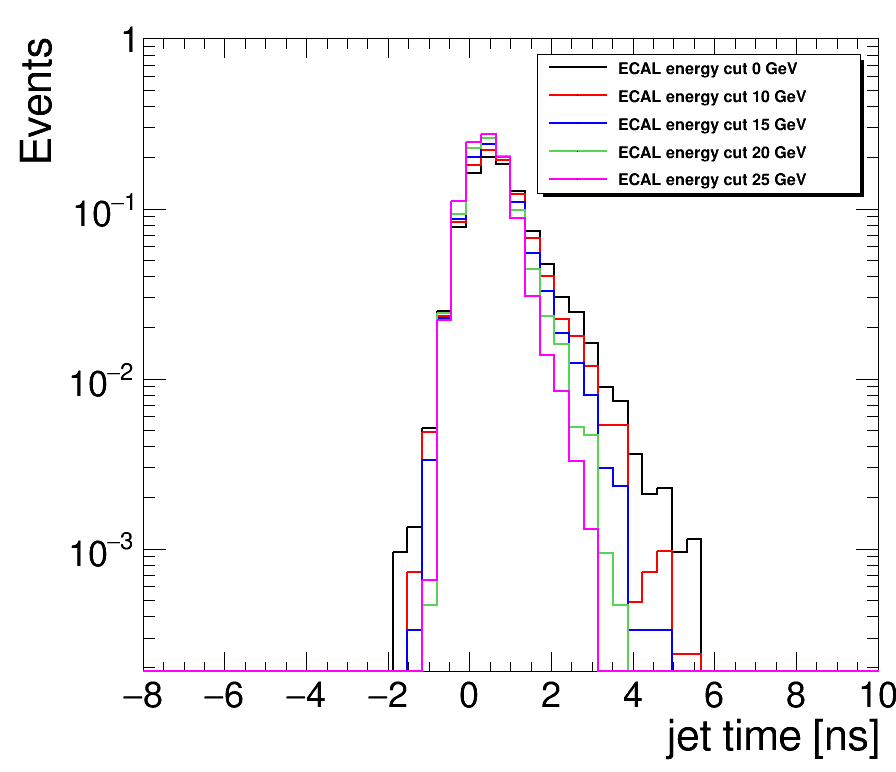

In [113]:

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.60,0.75,0.96,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
sig_et_cuts = [0,10,15,20,25]
k = 'bbbb_mh125_ctau1'
# k='QCD30'
for cut in sig_et_cuts:
    #     print(jet_frac_energy[k])
#     cond = np.ones(jet_frac_energy[k].shape,dtype=bool)
#     cond = sig_et[k] < cut
    cond = jetEcalEnergy[k] > cut
    print(len(jetEcalEnergy[k]))
#     if not k[:3] == 'QCD':
#         gLLP_decay_radius[k] = np.array(gLLP_decay_radius[k])
#         cond = gLLP_decay_radius[k] > 50
#         cond = np.logical_and(cond,gLLP_decay_z[k]>20)
    h[str(cut)] = create_TH1D(jetTime[k][cond],axis_title = ['jet time [ns]','Events'], binning=[50,-8,10])
    



#     h[k] = create_TH1D(jet_frac_energy[k][cond],axis_title = ['Energy fraction','Events'], binning=[50,0,1])
    currentMax=h[str(cut)].GetBinContent(h[str(cut)].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[str(cut)].SetMaximum(5*currentMax)
        h[str(cut)].SetMinimum(1)
    h[str(cut)].SetLineColor(std_color_list[i])
#     h[k+'e'].SetLineColor(std_color_list[i+2])


    leg.AddEntry(h[str(cut)], "ECAL energy cut "+str(cut)+ " GeV")
#     leg.AddEntry(h[k+'e'], legend[k]+'_e')



#     h[k+'e'].DrawNormalized('same')
    h[str(cut)].DrawNormalized('same')
    i+=1
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/deltar0p15vs0p4_energyfrac_matched.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

0.6474386409296216
0.6474386409336991
0.6470634101377145
0.625607684490149
0.5863424365752204
0.5446905231957471
0.5223000829312099
0.49615277979581246
0.4632630875617777
0.449246779375281
0.4356922609446706
0.4186191371011899
0.40383379715715567
0.39899806887217015
0.3903609787290389
0.3709271822772214
0.3577157758897136
0.3498818255420994
0.3520031368229067
0.33273536522651226
0.31021400169727764
0.3091217697965485
0.3006475869985754
0.285439318815347
0.3318942412073015


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: trd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: trd (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Pot

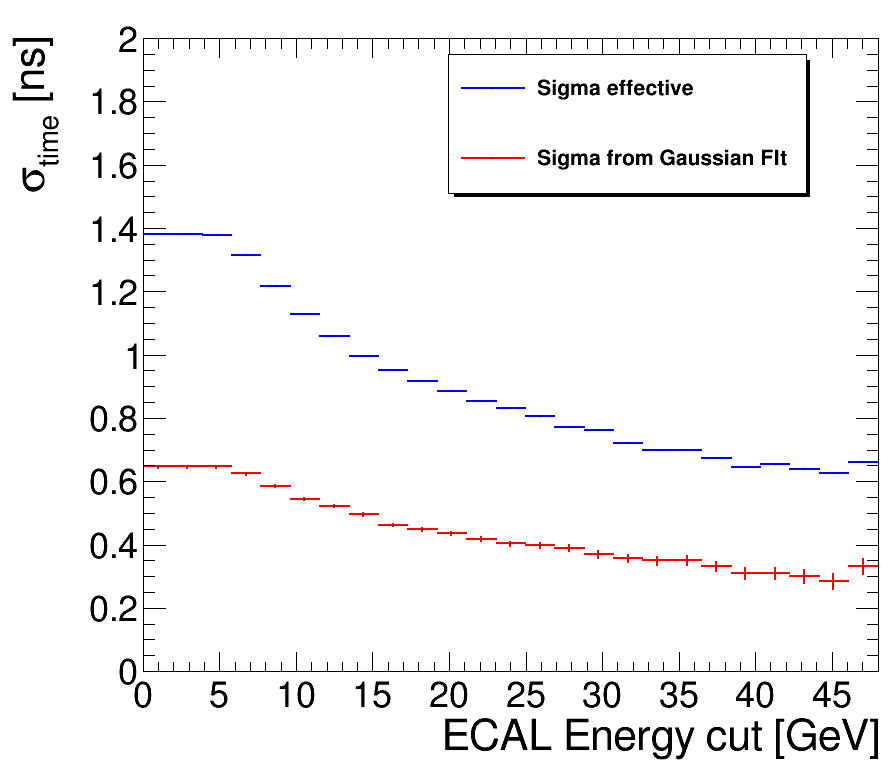

In [104]:
import array
c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.50,0.75,0.90,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
# ecal_energy_cut = [0,5,10,20,30]
ecal_energy_cut = range(0,50,2)
# k = 'bbbb_mh125_ctau1'
k='QCD30'

res = rt.TH1F('trd','res', len(ecal_energy_cut),min(ecal_energy_cut),max(ecal_energy_cut))
res_eff = rt.TH1F('trd','res_eff',len(ecal_energy_cut),min(ecal_energy_cut),max(ecal_energy_cut))

for i,cut in enumerate(ecal_energy_cut):

    cond = jetEcalEnergy[k] > cut
#     print(len(jetEcalEnergy[k]))
    hnew.Delete()
    hnew2.Delete()
    hnew= create_TH1D(jetTime[k][cond],axis_title = ['jet time [ns]','Events'], binning=[500000,-8,10])
    hnew2 = create_TH1D(jetTime[k][cond],axis_title = ['jet time [ns]','Events'], binning=[200,-8,10])

    SS = rt.TSpectrum()
    n_pks = SS.Search(hnew2, 0.1, "", 0.5)
    x_pos = SS.GetPositionX()
    y_pos = SS.GetPositionY()
    pks = []
    if n_pks == 0:
        hnew2.SetLineColor(4)
        hnew2.GetXaxis().SetRangeUser(-5,5)
        hnew2.DrawCopy()
        print('n_pks == 0',i,hnew.Integral(),n_pks)
        break
    n_pk = hnew2.FindBin(x_pos[0])
    
    thr = 0.2 * hnew2.GetBinContent(n_pk)
    n_low = n_pk
    while hnew2.GetBinContent(n_low) > thr:
        n_low -= 1
    x_low = hnew2.GetBinCenter(n_low)    
    n_up = n_pk
    while hnew2.GetBinContent(n_up) > thr:
        n_up += 1
    x_up = hnew2.GetBinCenter(n_up)
    r = hnew2.Fit('gaus', 'LRSQ+', '', x_low, x_up)
    r = r.Get()
    res.SetBinContent(i+1,r.Parameter(2))
    res.SetBinError(i+1,r.ParError(2))
    print(r.Parameter(2))
    n_pk = hnew.FindBin(r.Parameter(1))
    thr = 0.68 * hnew.Integral()
    counter = hnew.GetBinContent(n_pk)*1.0
    n_low = n_pk
    n_up = n_pk
    flag = True
    while counter < thr:
        if flag:
            n_low -= 1
            counter += hnew.GetBinContent(n_low)
        else:
            n_up += 1
            counter += hnew.GetBinContent(n_up)
        flag = not flag
    sigma_eff = (n_up - n_low) *hnew.GetBinWidth(1)
#         sigma_eff = h1.GetStdDev()
    res_eff.SetBinContent(i+1,sigma_eff)
    res_eff.SetBinError(i+1,hnew.GetBinWidth(1))
    

leg.SetTextSize(0.03)
leg.AddEntry(res_eff,'Sigma effective')
leg.AddEntry(res,'Sigma from Gaussian FIt')


res.SetXTitle('ECAL Energy cut [GeV]')
res.SetYTitle('#sigma_{time} [ns]')
#     res.GetXaxis().SetRangeUser(0,800)
res.GetYaxis().SetRangeUser(0,2)
res.SetLineColor(2)
res_eff.SetLineColor(4)
res.DrawCopy()
res_eff.DrawCopy('same')
leg.Draw()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


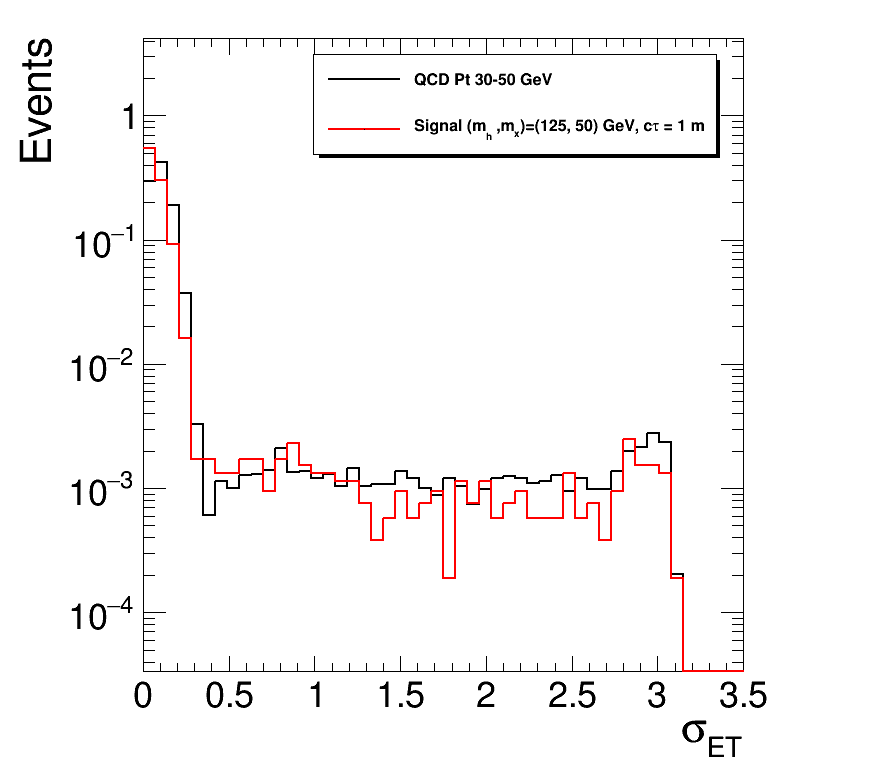

In [131]:
# Signal vs. bkg for different Ecal energy cut on time

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.35,0.80,0.80,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
keys = ['QCD30','bbbb_mh125_ctau1']
i=0
for key in keys:
#     h[key] = create_TH1D(jetPt[key], axis_title = ['jet P_{T} [GeV]','Events'], binning=[50,0,200])

#     h[key] = create_TH1D(jetEcalEnergy[key], axis_title = ['ECAL Energy [GeV]','Events'], binning=[50,0,200])
#     h[key] = create_TH1D(jetGammaMax_ET[key], axis_title = ['TMF_{ET max}','Events'], binning=[50,0,1.5])
#     h[key] = create_TH1D(jetMinDeltaRPVTracks[key], axis_title = ['#Delta R_{min}','Events'], binning=[50,0,1.5])
    h[key] = create_TH1D(sig_et[key], axis_title = ['#sigma_{ET}','Events'], binning=[50,0,3.5])

    currentMax=h[key].GetBinContent(h[key].GetMaximumBin())
    if currentMax > max_y:
        max_y = currentMax
        h[key].SetMaximum(10*currentMax)
        h[key].SetMinimum(1)
    h[key].SetLineColor(std_color_list[i])

    leg.AddEntry(h[key], legend[key])
    h[key].SetLineColor(std_color_list[i])
    h[key].DrawNormalized('same')
    i+=1


# h['QCD30'].Draw('colz')

leg.Draw()
c.SetRightMargin(0.17)


c.SetLogy()
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file ../plots/timing_studies/jettime_ecalenergycut15.png has been created


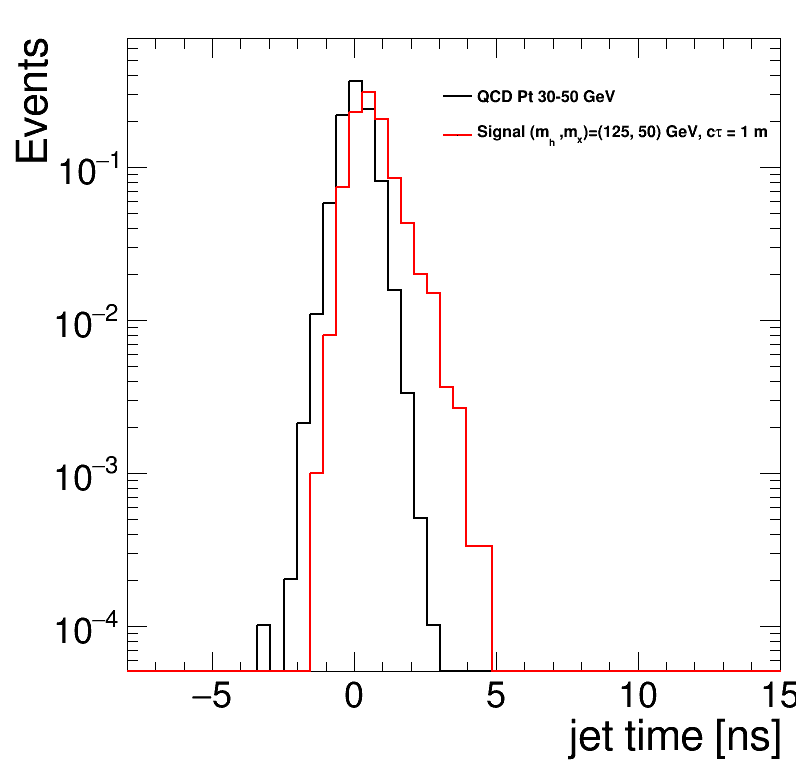

In [117]:


ecal_energy_cut = [15]

for cut in ecal_energy_cut:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.55,0.80,0.75,0.90)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)

    leg.SetEntrySeparation(0.01)
    i=0

    for k in tree_bkg.keys():
        cond = jetEcalEnergy[k] > cut
        v = jetTime[k][cond]
        h[k] = create_TH1D(v, axis_title = ['jet time [ns]','Events'], binning=[50,-8,15])


        leg.AddEntry(h[k], legend[k])
        h[k].SetLineColor(std_color_list[i])
        h[k].DrawNormalized('same')
        i+=1

    i+=1
    leg.Draw()
    c.SetLogy()
    c.Draw()
    c.SaveAs('../plots/timing_studies/jettime_ecalenergycut'+str(cut)+'.png')



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


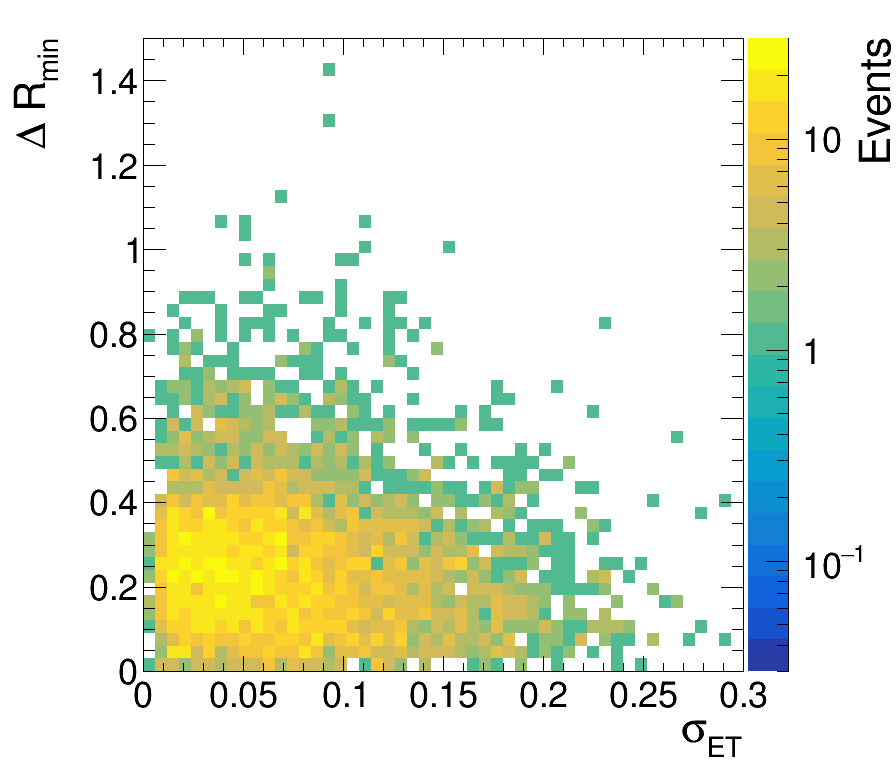

In [140]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
key = 'bbbb_mh125_ctau1'
# key = 'QCD30'
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((gLLP_decay_radius['bbbb_mh125_ctau1'],jetTime['bbbb_mh125_ctau1'])), axis_title = ['gLLP decay radius [cm]','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,140,50,-10,10])
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((gLLP_decay_radius['bbbb_mh125_ctau1'],jet_frac_energy['bbbb_mh125_ctau1'])), axis_title = ['gLLP decay radius [cm]','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,140,50,0,1])
# h['bbbb_mh125_ctau1'] = create_TH2D(np.column_stack((jet_frac_energy['bbbb_mh125_ctau1'],jetTime['bbbb_mh125_ctau1'])), axis_title = ['Energy Fraction','ECAL #Delta R = 0.15 energy fraction','Events'], binning=[50,0,1,50,-10,10])
# h['QCD30'] = create_TH2D(np.column_stack((jet_frac_energy['QCD30'],jetTime['QCD30'])), axis_title = ['Energy Fraction','jet Time','Events'], binning=[50,0,1,50,-10,10])
# h[key] = create_TH2D(np.column_stack((sig_et[key],jetTime[key])), axis_title = ['#sigma_{ET}','jet Time','Events'], binning=[50,0,1,50,-10,10])
# h[key] = create_TH2D(np.column_stack((jetEcalEnergy[key],jetTime[key])), axis_title = ['ECAL Energy [GeV]','jet Time','Events'], binning=[50,0,200,50,-10,10])
# h[key] = create_TH2D(np.column_stack((sig_et[key],jetGammaMax_ET[key])), axis_title = ['#sigma_{ET}','TMF_{ET max}','Events'], binning=[50,0,0.3,50,0,1.5])
h[key] = create_TH2D(np.column_stack((sig_et[key],jetMinDeltaRPVTracks[key])), axis_title = ['#sigma_{ET}','#Delta R_{min}','Events'], binning=[50,0,0.3,50,0,1.5])


 


# h['QCD30'].Draw('colz')

h[key].Draw('colz')

c.SetRightMargin(0.17)


c.SetLogz()
c.Draw()
# c.SaveAs('../plots/timing_studies/deltar0p15vs0p4_energyfrac_llp_decay_radius_matched.png')

# c.SaveAs('../plots/timing_studies/matched_recotime.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# Compare max time vs. energy weighted time

In [ ]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.50,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
k = 'QCD30'
# k = 'bbbb_mh125_ctau1'
bins = [50,-10,20]
h['jetTime'] = create_TH1D(jetTime[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_deltaRp15'] = create_TH1D(jetTime_deltaRp15[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_max'] = create_TH1D(jetTime_max[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_max_deltaRp15'] = create_TH1D(jetTime_max_deltaRp15[k],axis_title = ['jet time [ns]','Events'], binning=bins)
h['jetTime_median'] = create_TH1D(jetTime_median[k],axis_title = ['jet time [ns]','Events'], binning=bins)


h['jetTime'].SetLineColor(std_color_list[0])
h['jetTime_deltaRp15'].SetLineColor(std_color_list[1])
h['jetTime_max'].SetLineColor(std_color_list[2])
h['jetTime_max_deltaRp15'].SetLineColor(std_color_list[3])
h['jetTime_median'].SetLineColor(std_color_list[4])

leg.AddEntry(h['jetTime'], 'Energy weighted time, #Delta R = 0.4')
leg.AddEntry(h['jetTime_deltaRp15'], 'Energy weighted time, #Delta R = 0.15')
leg.AddEntry(h['jetTime_max'], 'Rechit time_{max E}, #Delta R = 0.4')
leg.AddEntry(h['jetTime_max_deltaRp15'], 'Rechit time_{max E}, #Delta R = 0.15')
leg.AddEntry(h['jetTime_median'], 'Rechit time_{median}, #Delta R = 0.4')

h['jetTime'].DrawNormalized('same')
h['jetTime_deltaRp15'].DrawNormalized('same')
h['jetTime_max'].DrawNormalized('same')
h['jetTime_max_deltaRp15'].DrawNormalized('same')
h['jetTime_median'].DrawNormalized('same')

    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_matched_QCDpt30-50.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# bkg vs. signal for different time definition

In [ ]:
# gen vs. reco time for matched signals

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.52,0.75,0.96,0.93)
leg.SetTextSize(0.022)
# leg.SetBorderSize(0)

# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
max_y = 0
i=0
time_vars = [jetTime, jetTime_median,jetTime_deltaRp15, jetTime_max, jetTime_max_deltaRp15]
time_xaxis = ['jetTime', 'jetTime_median','jetTime_deltaRp15', 'jetTime_max', 'jetTime_max_deltaRp15']
time_legend = ['Energy weighted time, #Delta R = 0.4','Rechit time_{median}, #Delta R = 0.4','Energy weighted time, #Delta R = 0.15',
              'Rechit time_{max E}, #Delta R = 0.4','Rechit time_{max E}, #Delta R = 0.15']

var_i=1
bins = [50,-7,15]
for k,v in time_vars[var_i].items():
    h[k] = create_TH1D(v,axis_title = ['jet time [ns]','Events'], binning=bins)
    h[k].SetLineColor(std_color_list[i])
    leg.AddEntry(h[k], legend[k])
    h[k].DrawNormalized('same')
    i+=1

    #     c.SetRightMargin(0.17)
leg.Draw()


c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/matched_recotime.png')
#     c.SaveAs('../plots/timing_studies/matched_tresponse_jetpt_'+k+'.png')

# ROC curve for the jet moments

In [ ]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}
moment_vars = [sig_et1,sig_et2,sig_e1,sig_e2,sig_e,sig_et,etD,eD]
moment_xaxis = ['sig_et1','sig_et2','sig_e1','sig_e2','sig_e','sig_et','etD','eD']
moment_legend = ['#sigma_{ET 1}','#sigma_{ET 2}','#sigma_{E 1}','#sigma_{E 2}','#sigma_{ET}','#sigma_{E}','E_{T}D','ED']


qcd_key = 'QCD30'
sig_k = 'bbbb_mh125_ctau1'
for i in range(len(moment_legend)):
    eff = {}
    thre = np.array(range(1000))/1000.0
    thre = np.array(range(2500))/100.0-10
#     print(thre)
    for k in tree_bkg.keys():
        cond = jetTime[k] > 2
        v = moment_vars[i][k][cond]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[moment_xaxis[i]] = create_TGraph(eff[sig_k],np.reciprocal(eff[qcd_key]),axis_title = ['#epsilon_{sig}','bkg rejection'])
    gr[moment_xaxis[i]].SetLineColor(std_color_list[i])
    gr[moment_xaxis[i]].SetLineWidth(2)
    gr[moment_xaxis[i]].SetMarkerColor(std_color_list[i])


#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[moment_xaxis[i]].GetXaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[moment_xaxis[i]],moment_legend[i])

    gr[moment_xaxis[i]].Draw('ac' if i==0 else 'c')
leg.Draw()
c.SetLogy()
c.Draw()
c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')



# ROC curve for the 4 different time variables

(1809,) (1809,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


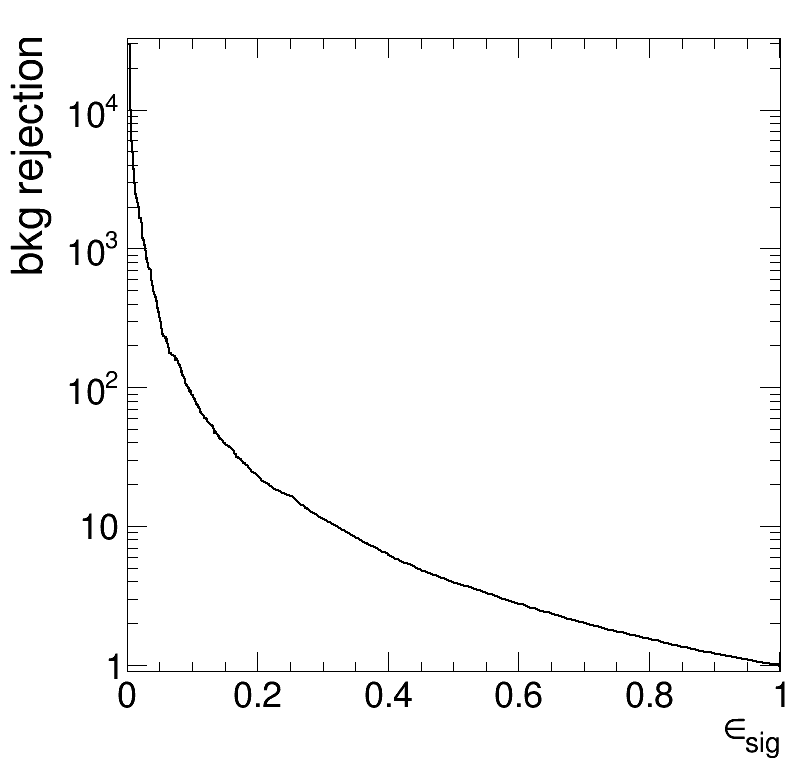

In [18]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}
time_vars = [jetTime, jetTime_median,jetTime_deltaRp15, jetTime_max, jetTime_max_deltaRp15]
time_xaxis = ['jetTime', 'jetTime_median','jetTime_deltaRp15', 'jetTime_max', 'jetTime_max_deltaRp15']
time_legend = ['Energy weighted time, #Delta R = 0.4','Rechit time_{median}, #Delta R = 0.4','Energy weighted time, #Delta R = 0.15',
              'Rechit time_{max E}, #Delta R = 0.4','Rechit time_{max E}, #Delta R = 0.15']



# time_vars = [jetEcalEnergy]
# time_xaxis = ['jetEcalEnergy']

qcd_key = 'QCD30'
sig_k = 'bbbb_mh125_ctau1'
for i in range(len(time_vars)):
    v = time_vars[i]
    eff = {}
    thre = np.array(range(1000))/1000.0
    thre = np.array(range(2000))/10.0-10
#     print(thre)
    for k in tree_bkg.keys():
        v = time_vars[i][k]
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[time_xaxis[i]] = create_TGraph(eff[sig_k],np.reciprocal(eff[qcd_key]),axis_title = ['#epsilon_{sig}','bkg rejection'])
    gr[time_xaxis[i]].SetLineColor(std_color_list[i])
    gr[time_xaxis[i]].SetLineWidth(2)
    gr[time_xaxis[i]].SetMarkerColor(std_color_list[i])

    gr[time_xaxis[i]].SetMarkerColor(std_color_list[i])

#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[time_xaxis[i]].GetXaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[time_xaxis[i]],time_legend[i])

    gr[time_xaxis[i]].Draw('ac' if i==0 else 'c')
# leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')


# Roc curve for jet time with different ECAL Energy cut

(160,) (160,)
(131,) (131,)
(129,) (129,)
(126,) (126,)
(118,) (118,)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


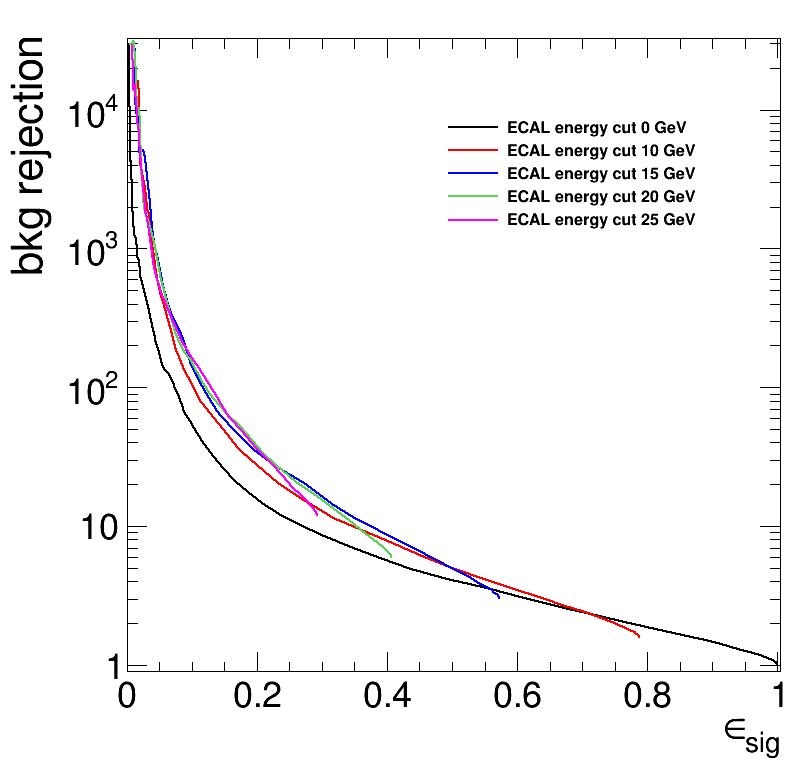

In [105]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.55,0.70,0.90,0.85)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}



time_vars = [jetTime]
time_xaxis = ['jetTime']
ecal_energy_cut = [0,10,15,20,25]
qcd_key = 'QCD30'
sig_k = 'bbbb_mh125_ctau1'
i=0
for cut in ecal_energy_cut:
    
    
    eff = {}
    thre = np.array(range(1000))/1000.0
    thre = np.array(range(2000))/10.0-10
#     print(thre)
    for k in tree_bkg.keys():
        cond = jetEcalEnergy[k] > cut
        v = jetTime[k][cond]
        eff[k] = []
        for th in thre:
#             cond = np.logical_and(cond,jetTime[k]>th)
            eff[k].append(1.0*np.count_nonzero(v>th)/len(jetTime[k]))
        eff[k] = np.array(eff[k])
#     Plotting ROC curve
    eff[sig_k] = eff[sig_k][np.logical_not(eff[qcd_key] == 0)]
    eff[qcd_key] = eff[qcd_key][np.logical_not(eff[qcd_key] == 0)]
    print(eff[qcd_key].shape, eff[sig_k].shape)
    gr[str(cut)] = create_TGraph(eff[sig_k],np.reciprocal(eff[qcd_key]),axis_title = ['#epsilon_{sig}','bkg rejection'])
    gr[str(cut)].SetLineColor(std_color_list[i])
    gr[str(cut)].SetLineWidth(2)
    gr[str(cut)].SetMarkerColor(std_color_list[i])

    gr[str(cut)].SetMarkerColor(std_color_list[i])

#     gr[name[i]].GetYaxis().SetRangeUser(0,0.3)
    gr[str(cut)].GetXaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[str(cut)],"ECAL energy cut "+str(cut)+ " GeV")

    gr[str(cut)].Draw('ac' if i==0 else 'c')
    i+=1
leg.Draw()
c.SetLogy()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')



# Check events for rechit time/ energy distribution

In [ ]:
k = 'bbbb_mh125_ctau1'
cond = jetTime[k]>-5
# cond = np.logical_and()
print(np.count_nonzero(cond))
rechitsE = jet_rechits_E[k][cond]
rechitsT = jet_rechits_T[k][cond]
rms = []
for i in range(len(rechitsE)):
#     print(i,len(rechitsE[i]),np.sum(rechitsE[i]),(np.mean(np.array(rechitsE[i])**2))**0.5,jet_frac_energy[k][cond][i])
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5/abs(jetTime[k][cond][i]))
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5)
    rms.append((np.mean(np.array(rechitsE[i])**2))**0.5/abs(jetEcalEnergy[k][cond][i]))

#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))
#     rms.append(np.max(rechitsE[i]))

index = 0
print("jetTime",jetTime[k][cond][index])
print("jetEnergy",jetEcalEnergy[k][cond][index])
print("nRechits",len(rechitsE[index]))
print("jet_frac_energy",jet_frac_energy[k][cond][index])

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


bins = [50,-5,10]
# h['time'] = create_TH1D(rechitsT[index],axis_title = ['jet time [ns]','Events'], binning=bins)
# h[k] = create_TH1D(rechitsE[index],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=bins)
# h[k] = create_TH2D(np.column_stack((rms,jetTime[k][cond])), axis_title = ['time rms fraction','jet time [ns]','Events'], binning=[50,0,10,50,-10,10])
# h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=bins)
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=[50,0,0.5])

rms = np.array(rms)
# print(rms)
print(1.0*np.count_nonzero(rms[rms>1.5])/len(rms))
h[k].Draw('colz')
print(rechitsT[index])
print(rechitsE[index])
print(rechit_deltaR[k][cond][index])
# leg.Draw()
c.SetLogz()
c.Draw()



In [ ]:
k = 'QCD30'
cond = jetTime[k]>1.5
# cond = np.logical_and()
print(np.count_nonzero(cond))
rechitsE = jet_rechits_E[k][cond]
rechitsT = jet_rechits_T[k][cond]
rms = []
for i in range(len(rechitsE)):
#     print(len(rechitsE[i]),np.sum(rechitsE[i]),(np.mean(np.array(rechitsE[i])**2))**0.5,jet_frac_energy[k][cond][i])
#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5/abs(jetTime[k][cond][i]))
    rms.append((np.mean(np.array(rechitsE[i])**2))**0.5/abs(jetEcalEnergy[k][cond][i]))

#     rms.append((np.mean(np.array(rechitsT[i])**2))**0.5)
#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))

#     rms.append((np.mean(np.array(rechitsE[i])**2))**0.5)
#     rms.append(np.max(rechitsE[i]))

#     rms.append(abs(np.max(rechitsE[i])-np.min(rechitsE[i]))/np.min(rechitsE[i]))
index = 0
print("jetTime",jetTime[k][cond][index])
print("jetEnergy",jetEcalEnergy[k][cond][index])
print("nRechits",len(rechitsE[index]))
print("jet_frac_energy",jet_frac_energy[k][cond][index])

c = rt.TCanvas('c','c', 900, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.40,0.75,0.95,0.93)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)


bins = [50,-5,10]
# h['time'] = create_TH1D(rechitsT[index],axis_title = ['jet time [ns]','Events'], binning=bins)
# h[k] = create_TH1D(rechitsE[index],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=bins)
# h[k] = create_TH1D(jetEcalEnergy[k][cond],axis_title = ['jet ECAL Energy [GeV]','Events'], binning=[50,0,50])

# h[k] = create_TH1D(rms,axis_title = ['rechit energy rms [GeV]','Events'], binning=[50,0,5])
# h[k] = create_TH2D(np.column_stack((rms,jetTime[k][cond])), axis_title = ['time rms fraction','jet time [ns]','Events'], binning=[50,0,10,50,-10,10])
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=bins)
h[k] = create_TH1D(rms,axis_title = ['time rms fraction','Events'], binning=[50,0,0.5])

rms = np.array(rms)
# print(rms)
print(1.0*np.count_nonzero(rms[rms>1.5])/len(rms))
h[k].Draw('colz')
print(rechitsT[index])
print(rechitsE[index])
print(rechit_deltaR[k][cond][index])
# leg.Draw()
c.SetLogz()
c.Draw()
